In [2]:
import os
import gzip
import itertools
import time

import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import collections
from matplotlib.gridspec import GridSpec
import seaborn as sns
# from venn import venn
# from statannotations.Annotator import Annotator
# from adjustText import adjust_text

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score, silhouette_score, silhouette_samples, calinski_harabasz_score,davies_bouldin_score

import scipy.cluster.hierarchy as sch
from scipy.stats import pearsonr, entropy, false_discovery_control, ttest_ind, mannwhitneyu, ttest_rel, wilcoxon, kruskal, brunnermunzel

# from sknetwork.clustering import Louvain

# import umap
# import cuda

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Preprocess to get raw public data

## RUN Snakemake file to process NGS RNA-Seq data

- The workflow starts on downloading fastq files from NCBI and ends with estimated abundance by salmon.
- There is file for paired-end and another for single-end experiments, Snakefile_pe and Snakefile_se, respectively. Remember to rename the files before runnnig.
- conda enviroment is in ./envs

In [6]:
# #!/bin/bash
# snakemake --dry-run
# snakemake --cores 4 --use-conda

![title](./snakemake_workflow.png)

# Download CEL files od Microarray experiments

run file ./download_MA_CEL.sh

In [ ]:
# #!/bin/bash

# gses=("GSE129166" "GSE46474" "GSE15296" "GSE14346")
# https=("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129166/suppl//GSE129166_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE46nnn/GSE46474/suppl//GSE46474_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE15nnn/GSE15296/suppl//GSE15296_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE14nnn/GSE14346/suppl//GSE14346_RAW.tar")

# for i in $(seq 0 3);
# do
#     echo "wget ${https[$i]}";
#     echo "tar -xvf ${gses[$i]}_RAW.tar -C ./posttransplant_${gses[$i]}/${gses[$i]}_CEL";
# done

# Importing housekeepingMiningPy 

package developed during the research can be installed via pip install housekeepingMinerPy or read via housekeepingMinerPy folder or clone it from github https://github.com/guilhermetabordaribas/housekeepingMinerPy

In [3]:
import sys
sys.path.append('./')
import housekeepingMinerPy as hkg

In [4]:
random_state = 42

In [636]:
sns.set_theme(style="whitegrid")

In [32]:
# Palettes blindcolor friendly
#From Paul Tol: https://personal.sron.nl/~pault/
# https://zenodo.org/records/3381072
Tol_bright = ['#EE6677', '#228833', '#4477AA', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

Tol_muted = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']

Tol_light = ['#BBCC33', '#AAAA00', '#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD']

#From Color Universal Design (CUD): https://jfly.uni-koeln.de/color/
Okabe_Ito = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"][::-1]

colors__ = ['#00000050', '#CC79A750', '#D55E0050', '#0072B250']

# Common Used Housekeeping Genes in Kidney Transplantion- literature

We tested housekeeping genes from these studies:

- [PMC8659319: Tissue](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8659319/):
    - References: GAPDH, ACTG1, REL, ACTB, SLC4AIAP, YWHAZ, RPS13, NOP10, PGAM1, PPIA, GUSB, TBP, RPL13, HNRNPL, PCBP1, RER1, PLA2G4A, B2M
 
- [PMC6580566: Tissue](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6580566/):
    - References: GAPDH, ACTB, TUBA1A
 
**hkg_kidney_ref** = ['GAPDH', 'ACTB', 'ACTG1', 'REL', 'SLC4A1AP', 'YWHAZ', 'RPS13', 'NOP10', 'PGAM1', 'PPIA', 'GUSB', 'TBP', 'RPL13', 'HNRNPL', 'PCBP1', 'RER1', 'PLA2G4A', 'B2M','TUBA1A','HPRT1']

In [34]:
hkg_kidney_ref = ['GAPDH', 'ACTB', 'ACTG1', 'REL', 'SLC4A1AP', 'YWHAZ', 'RPS13', 'NOP10', 'PGAM1', 'PPIA', 'GUSB', 'TBP', 'RPL13', 'HNRNPL', 'PCBP1', 'RER1', 'PLA2G4A', 'B2M','TUBA1A','HPRT1']

In [4]:
# Genes selected at the end of the analysis imported just for annotation in plots
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [36]:
# Biomarkers to test the machine learning models. They were discovered at  PMC9231008 https://pubmed.ncbi.nlm.nih.gov/35526671/
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']

# Calculating DEG usual housekeeping genes to verify changes in time and conditions

## R Script to calculate DEG GSE86884

In [9]:
# %%R Script
# library("tximport")
# library("readr")
# library("DESeq2")

# dir_0 = 'pre_posttransplant_PRJNA342822_GSE86884'
# dir = paste0('D:/',dir_0,'/trimmed_salmon_quant')
# metadata = read.csv(paste0('D:/',dir_0,'/metadata/metadata.csv'))
# metadata$timeOfBloodDraw = as.factor(metadata$timeOfBloodDraw)
# metadata$gender = as.factor(metadata$gender)
# metadata$age_bins = as.factor(metadata$age_bins)

# tx2gene = read_csv('D:/reference_files/homo_sapiens/gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')

# samples = metadata$Run
# files = file.path(dir, samples, "quant.sf")
# length(files)
# txi = tximport(files, type="salmon", tx2gene=tx2gene)

# # Get only protein_coding genes
# pc = tx2gene[tx2gene$Gene_type=='protein_coding',]$Gene_name
# txi$counts = txi$counts[rownames(txi$counts) %in% pc,]
# txi$abundance = txi$abundance[rownames(txi$abundance) %in% pc,] 
# txi$length = txi$length[rownames(txi$length) %in% pc,] 

# ddsTxi <- DESeq2::DESeqDataSetFromTximport(txi,
#                                            colData = metadata,
#                                            design = ~timeOfBloodDraw+gender+race+age_bins)

# dds = DESeq2::DESeq(ddsTxi)
# colnames(dds) = samples

# altHypothesis = 'greaterAbs'
# lfcThreshold = 0
# cond1 = "pre"

# for (cond2 in c('1w','3m', '6m')){
#   res = DESeq2::results(dds, lfcThreshold=lfcThreshold, altHypothesis=altHypothesis,
#                         contrast=c("timeOfBloodDraw",cond1, cond2)) #
  
#   vsd = vst(dds, blind=FALSE)
#   f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_',altHypothesis,'_',lfcThreshold,'_',cond1,'_vs_',cond2,'_') 
#   write.csv(res[order(res$padj),], file = paste0(f,'res.csv'), quote = FALSE)
# }
# f = paste0('D:/pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_') 
# write.csv(assay(vsd), file = paste0(f,'pre_pos_vsd.csv'), quote = FALSE)

In [37]:
path = './pre_posttransplant_PRJNA342822_GSE86884/hkg/'
res_dict = {f.replace('_res.csv',''):pd.read_csv( os.path.join(path,f), index_col=0 ) for f in os.listdir(path) if f.startswith('all_factors') and f.endswith('res.csv')}
for res in res_dict.values():
    res['log10baseMean'] = np.log10(res.baseMean)
    res['-log10padj'] = -np.log10(res.padj)

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: Runtime

## Fig 1B: Clustermap

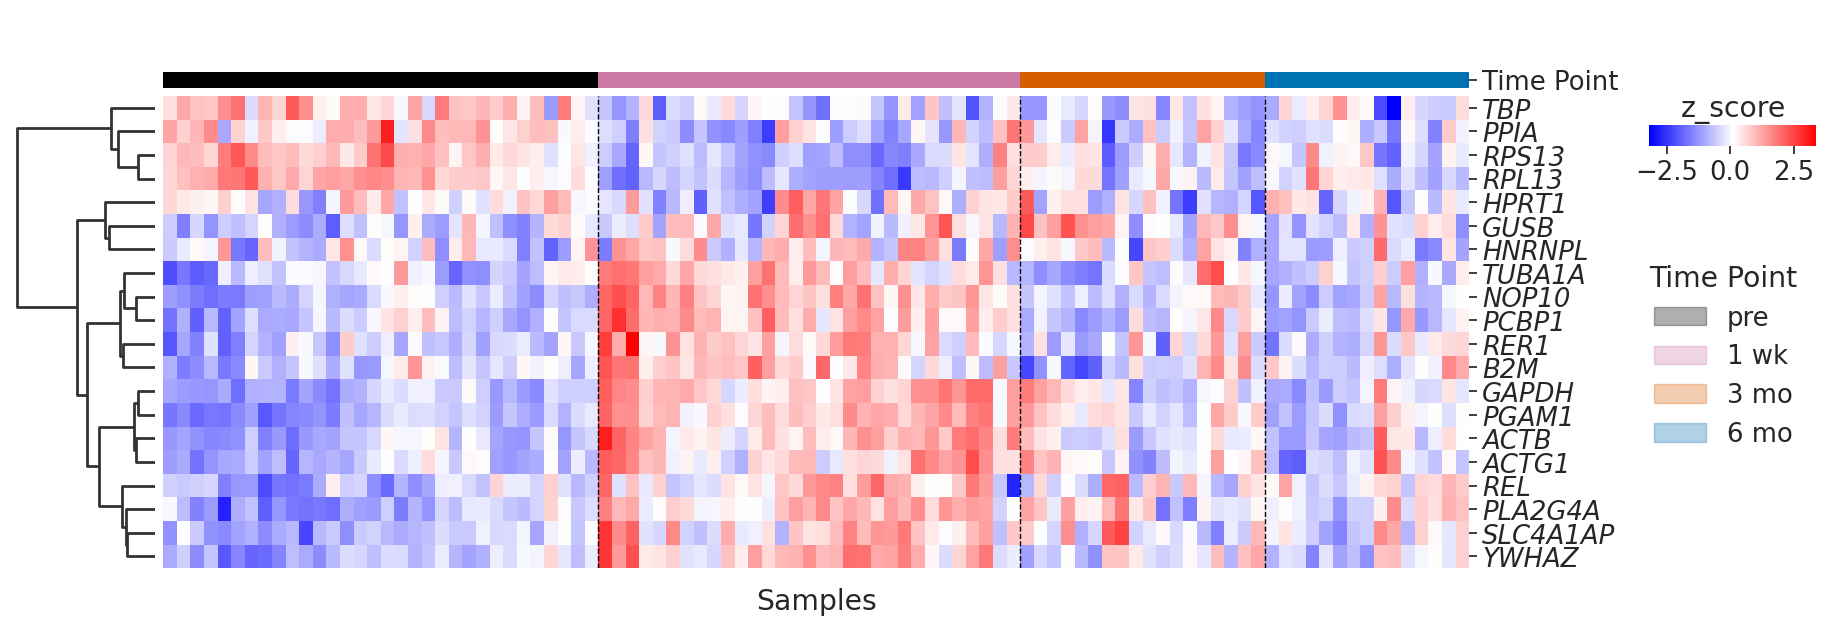

In [39]:
df_meta_cl = pd.read_csv('./pre_posttransplant_PRJNA342822_GSE86884/metadata/metadata.csv')[['Run','timeOfBloodDraw']].set_index('Run')
df_vsd = pd.read_csv('./pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_pre_pos_vsd.csv', index_col=0).loc[hkg_kidney_ref,:]
df_meta_list = []
for tp in ['pre','1w','3m','6m']:
    aux = df_meta_cl[df_meta_cl.timeOfBloodDraw==tp]
    Z = sch.linkage(df_vsd.loc[:,aux.index].T, 'ward')    
    aux = [aux.index[int(l)] for l in sch.dendrogram(Z, no_plot=True)['ivl']]
    df_meta_list.append(df_meta_cl.loc[aux,:])
    del(Z)
Run_order = pd.concat(df_meta_list).index

df_meta_cl['timeOfBloodDraw'] = df_meta_cl.timeOfBloodDraw.map(dict(zip(['pre','1w','3m','6m'],colors__)))#
df_meta_cl.columns = ['Time Point']
df_meta_cl = df_meta_cl.loc[Run_order,:]
df_vsd = pd.read_csv('./pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_pre_pos_vsd.csv', index_col=0).loc[hkg_kidney_ref,Run_order]
sns.set_theme(style="whitegrid", font_scale=1.7)
g = sns.clustermap(df_vsd, z_score=0, cmap='bwr',#'seismic',#
                   col_colors=df_meta_cl, col_cluster=False, method='ward',tree_kws={'lw':2},
                   dendrogram_ratio=.1, cbar_pos=(1.0, 0.8, 0.1, 0.025), figsize=(16.7,8.35),yticklabels=1,cbar_kws={"orientation": "horizontal"}) 
g.ax_heatmap.axvline(32, lw=1, color='black', ls='--')
g.ax_heatmap.axvline(63, lw=1, color='black', ls='--')
g.ax_heatmap.axvline(81, lw=1, color='black', ls='--')
g.ax_heatmap.set_xticklabels([])
for label in g.ax_heatmap.get_yticklabels():
    # label.set_fontsize(8)#, style='italic')
    label.set_fontstyle('italic')
g.ax_heatmap.set_xlabel('Samples')
g.ax_cbar.set_title('z_score')
legend_TP = [mpatches.Patch(color=c, label=l) for l,c in zip(['pre','1 wk','3 mo','6 mo'],colors__)]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.12,.45),handles=legend_TP,frameon=False)
l2.set_title(title='Time Point')


g.savefig('./draft/FIG1B_heatmap_usual_hkg_timepoint.pdf', bbox_inches='tight', format='pdf', dpi=300)

## Fig 1A: Barplot logfold change

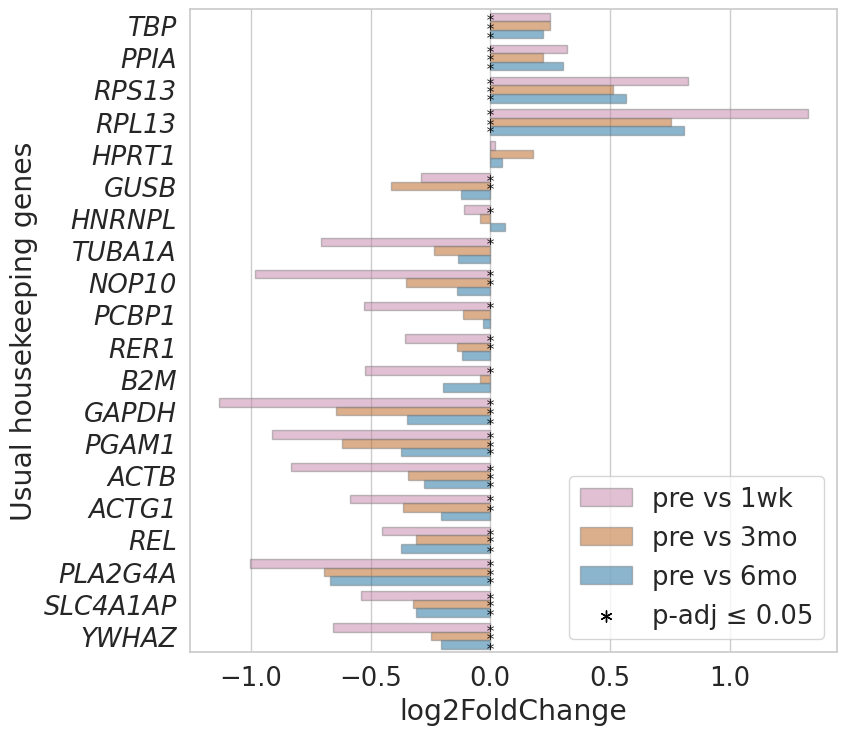

In [40]:
fig = plt.figure( figsize=(8.35,8.35) )

ax = fig.add_subplot(1,1,1)
res_keys = [k for k in res_dict.keys() if ('greaterAbs' in k) and ('_0_' in k)]
diff_genes = dict()

diff_df = []
for rk in res_keys:
    diff_df.append(res_dict[rk].loc[hkg_kidney_ref,['log2FoldChange','-log10padj']])
    diff_df[-1]['Contrast'] = rk.split('_',4)[-1]
    diff_df[-1]['sig_pv'] = np.where(diff_df[-1]['-log10padj'].values>=-np.log10(0.05), 0, 1)
    diff_df[-1]['color_pv'] = np.where(diff_df[-1]['-log10padj'].values>=-np.log10(0.05), 'green', 'red')
diff_df = pd.concat(diff_df).reset_index()

order = [t.get_text() for t in g.ax_heatmap.get_yticklabels()]
sns.stripplot(hue='Contrast',x='sig_pv', y='index', order=order, palette=['black','black','black'], marker='$*$',edgecolor='black', alpha=0.95, dodge=True, data=diff_df[diff_df.sig_pv==0], ax=ax)
sns.barplot(hue='Contrast',x='log2FoldChange', y='index', order=order, palette=Okabe_Ito[1:4], edgecolor='gray', alpha=0.5, data=diff_df, ax=ax)

handles, labels = ax.get_legend_handles_labels()#[::-1]
new_labels = []
new_handles = []
for l in labels:
    new_labels.append(l.replace('_', ' ').replace('w','wk').replace('m','mo'))
handles = handles[3:]
new_labels = new_labels[3:]
handles.append(collections.AsteriskPolygonCollection(numsides=6, color='black', sizes=(50,50)))
new_labels.append('p-adj ≤ 0.05')
ax.legend(handles=handles, labels=new_labels, loc='lower right')#, fontsize=22)
ax.set_ylabel('Usual housekeeping genes')

for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

fig.savefig('./draft/FIG1A_barplot_usual_lfc_timepoint.pdf', bbox_inches='tight', format='pdf', dpi=300)

## R Script to calculate DEG GSE120649 (16 rejection, ABMR and TCMR)

In [ ]:
# %%R
# library("tximport")
# library("readr")
# library("DESeq2")

# metadata = read.csv('./posttransplant_PRJNA493832_GSE120649/metadata/metadata.csv')
# metadata$Groups = as.factor(c(17, 17, 15, 15, 16, 16, 15, 17, 16, 15, 17, 16, 15, 15, 16, 15)) # From clustering 
# metadata$diagnosis = as.factor(metadata$diagnosis)

# dir = './posttransplant_PRJNA493832_GSE120649/trimmed_salmon_quant'
# library = 'PAIRED'

# altHypothesis = 'greaterAbs'
# lfcThreshold = 0

# samples = metadata$Run
# files = file.path(dir, samples, "quant.sf")
# tx2gene = read_csv(file.path('./', 'gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv'))

# txi = tximport::tximport(files, type="salmon", tx2gene=tx2gene)

# # Get only protein_coding genes
# pc = tx2gene[tx2gene$Gene_type=='protein_coding',]$Gene_name
# txi$counts = txi$counts[rownames(txi$counts) %in% pc,]
# txi$abundance = txi$abundance[rownames(txi$abundance) %in% pc,] 
# txi$length = txi$length[rownames(txi$length) %in% pc,] 

# ddsTxi <- DESeq2::DESeqDataSetFromTximport(txi,
#                                            colData = metadata,
#                                            design = ~ diagnosis+Groups) #
# dds = DESeq2::DESeq(ddsTxi)
# colnames(dds) = samples

# cond1 = "Normal"
# for (cond2 in c('ABMR','TCMR')){
#   res = DESeq2::results(dds, lfcThreshold=lfcThreshold, altHypothesis=altHypothesis,
#                         contrast=c("timeOfBloodDraw",cond1, cond2)) #
  
#   vsd = vst(dds, blind=FALSE)
#   f = paste0('./posttransplant_PRJNA493832_GSE120649/hkg/,library,'_',altHypothesis,'_',lfcThreshold,'_',cond1,'_vs_',cond2,'_') 
#   write.csv(res[order(res$padj),], file = paste0(f,'res.csv'), quote = FALSE)
# }
# f = paste0('./posttransplant_PRJNA493832_GSE120649/hkg/all_factors_') 
# write.csv(assay(vsd), file = paste0(f,'vsd.csv'), quote = FALSE)


In [41]:
path = './posttransplant_PRJNA493832_GSE120649/hkg/'
res_dict = {f.replace('_res.csv',''):pd.read_csv( os.path.join(path,f), index_col=0 ) for f in os.listdir(path) if f.startswith('PAIRED_greaterAbs') and f.endswith('res.csv')}
for res in res_dict.values():
    res['log10baseMean'] = np.log10(res.baseMean)
    res['-log10padj'] = -np.log10(res.padj)

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Fig 2B: Clustermap

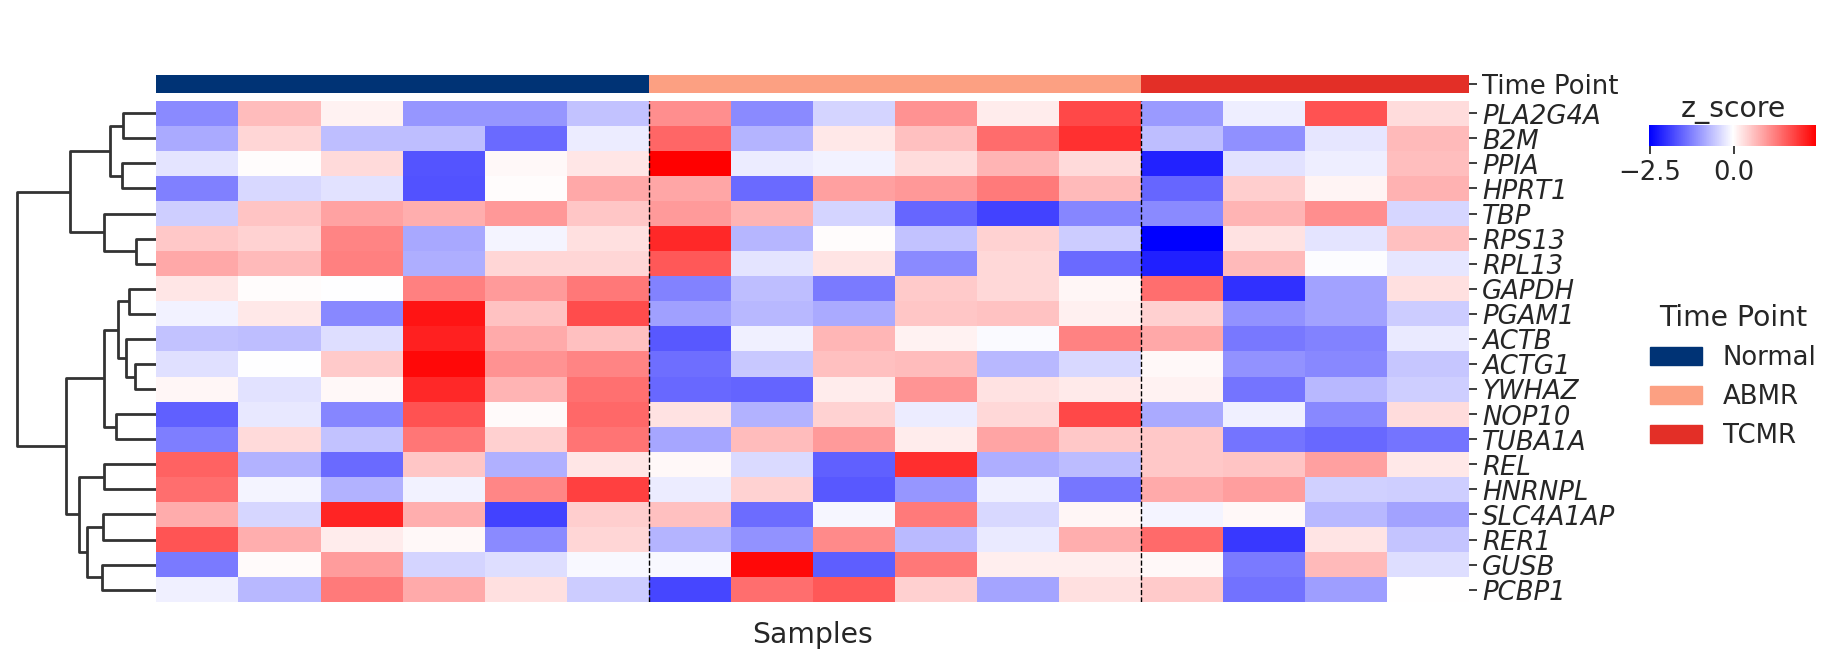

In [42]:
df_vsd = pd.read_csv('./posttransplant_PRJNA493832_GSE120649/hkg/PAIRED_greaterAbs_0_Normal_vs_ABMR_vsd.csv', index_col=0).loc[hkg_kidney_ref,:]
df_meta_cl = pd.read_csv('./posttransplant_PRJNA493832_GSE120649/metadata/metadata.csv')[['Run','diagnosis']].set_index('Run').loc[df_vsd.columns,:]
df_meta_list = []
for tp in ['Normal','ABMR','TCMR']:
    aux = df_meta_cl[df_meta_cl.diagnosis==tp]
    Z = sch.linkage(df_vsd.loc[:,aux.index].T, 'ward')    
    aux = [aux.index[int(l)] for l in sch.dendrogram(Z, no_plot=True)['ivl']]
    df_meta_list.append(df_meta_cl.loc[aux,:])
    del(Z)
Run_order = pd.concat(df_meta_list).index

df_meta_cl['diagnosis'] = df_meta_cl.diagnosis.map(dict(zip(['Normal','ABMR','TCMR'],['#003375', '#fca082', '#e32f27'])))#
df_meta_cl.columns = ['Time Point']
df_meta_cl = df_meta_cl.loc[Run_order,:]
df_vsd = pd.read_csv('./posttransplant_PRJNA493832_GSE120649/hkg/PAIRED_greaterAbs_0_Normal_vs_ABMR_vsd.csv', index_col=0).loc[hkg_kidney_ref,Run_order]
sns.set_theme(style="whitegrid", font_scale=1.7)
g = sns.clustermap(df_vsd, z_score=0, cmap='bwr',#'seismic',#
                   col_colors=df_meta_cl, col_cluster=False, method='ward',tree_kws={'lw':2},
                   dendrogram_ratio=.1, cbar_pos=(1.0, 0.8, 0.1, 0.025), figsize=(16.7,8.35),yticklabels=1,cbar_kws={"orientation": "horizontal"}) 
g.ax_heatmap.axvline(6, lw=1, color='black', ls='--')
g.ax_heatmap.axvline(12, lw=1, color='black', ls='--')
# g.ax_heatmap.axvline(81, lw=1, color='black', ls='--')
g.ax_heatmap.set_xticklabels([])
for label in g.ax_heatmap.get_yticklabels():
    # label.set_fontsize(8)#, style='italic')
    label.set_fontstyle('italic')
g.ax_heatmap.set_xlabel('Samples')
g.ax_cbar.set_title('z_score')
legend_TP = [mpatches.Patch(color=c, label=l) for l,c in zip(['Normal','ABMR','TCMR'],['#003375', '#fca082', '#e32f27'])]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.12,.45),handles=legend_TP,frameon=False)
l2.set_title(title='Time Point')


g.savefig('./draft/FIG1C_heatmap_usual_hkg_ABMR_TCMR.pdf', bbox_inches='tight', format='pdf', dpi=300)

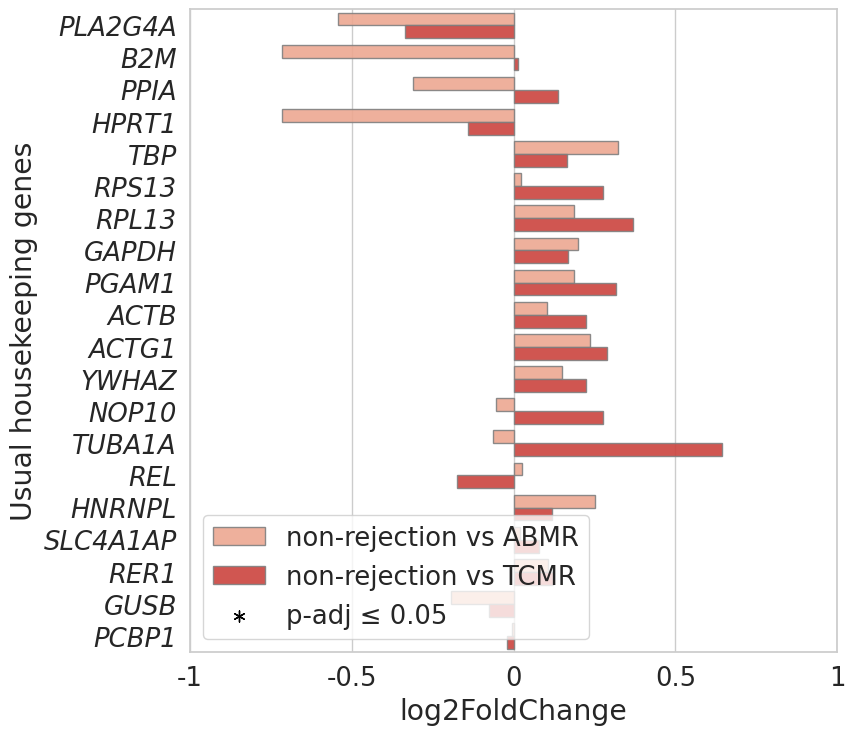

In [43]:
fig = plt.figure( figsize=(8.35,8.35) )
ax = fig.add_subplot(1,1,1)
res_keys = [k for k in res_dict.keys() if ('greaterAbs_0_' in k) and ('_Normal_' in k)]
diff_genes = dict()

diff_df = []
for rk in res_keys:
    diff_df.append(res_dict[rk].loc[hkg_kidney_ref,['log2FoldChange','-log10padj']])
    diff_df[-1]['Contrast'] = rk.split('_',4)[-1]
    diff_df[-1]['sig_pv'] = np.where(diff_df[-1]['-log10padj'].values>=-np.log10(0.1), 0, 1)
    diff_df[-1]['aux_pv'] = 0
diff_df = pd.concat(diff_df).reset_index()

order = [t.get_text() for t in g.ax_heatmap.get_yticklabels()]

sns.barplot(hue='Contrast',x='log2FoldChange', y='index', order=order, palette=['#fca082', '#e32f27'], edgecolor='gray', alpha=0.9, data=diff_df, ax=ax)
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    new_labels.append('non-rejection ' + l.replace('_', ' '))
handles.append(collections.AsteriskPolygonCollection(numsides=6, color='black', sizes=(50,50)))
new_labels.append('p-adj ≤ 0.05')
ax.legend(handles=handles, labels=new_labels, loc='lower left')
ax.set_ylabel('Usual housekeeping genes')
ax.set_xlim([-1,1])
ax.set_xticks([-1,-.5,0,.5,1])
ax.set_xticklabels([-1,-.5,0,.5,1])

for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

fig.savefig('./draft/FIG1D_barplot_usual_lfc_ABMR_TCMR.pdf', bbox_inches='tight', format='pdf', dpi=300)

# Discovery hkg are based on RNAseq:

- GSE175718 (384)
- GSE120649 (16)
- GSE112927 (235 pre)
- GSE86884 (96 nr)

# Calculating equivalent genes from study GSE86884 with DESeq2

## R Scritp to equivalent genes

In [ ]:
# %%R Script
# library("tximport")
# library("readr")
# library("DESeq2")

# dir_0 = 'pre_posttransplant_PRJNA342822_GSE86884'
# dir = paste0('./',dir_0,'/trimmed_salmon_quant')
# metadata = read.csv(paste0('D:/',dir_0,'/metadata/metadata.csv'))
# metadata$timeOfBloodDraw = as.factor(metadata$timeOfBloodDraw)
# metadata$gender = as.factor(metadata$gender)
# metadata$age_bins = as.factor(metadata$age_bins)

# tx2gene = read_csv('./gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')

# samples = metadata$Run
# files = file.path(dir, samples, "quant.sf")
# length(files)
# txi = tximport(files, type="salmon", tx2gene=tx2gene)

# # Get only protein_coding genes
# pc = tx2gene[tx2gene$Gene_type=='protein_coding',]$Gene_name
# txi$counts = txi$counts[rownames(txi$counts) %in% pc,]
# txi$abundance = txi$abundance[rownames(txi$abundance) %in% pc,] 
# txi$length = txi$length[rownames(txi$length) %in% pc,] 

# ddsTxi <- DESeq2::DESeqDataSetFromTximport(txi,
#                                            colData = metadata,
#                                            design = ~timeOfBloodDraw+gender+race+age_bins)

# dds = DESeq2::DESeq(ddsTxi)
# colnames(dds) = samples

# altHypothesis = 'lessAbs'
# lfcThreshold = 0.5
# cond1 = "pre"

# for (cond2 in c('1w','3m', '6m')){
#   res = DESeq2::results(dds, lfcThreshold=lfcThreshold, altHypothesis=altHypothesis,
#                         contrast=c("timeOfBloodDraw",cond1, cond2)) #
  
#   vsd = vst(dds, blind=FALSE)
#   f = paste0('./pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_',altHypothesis,'_',lfcThreshold,'_',cond1,'_vs_',cond2,'_') 
#   write.csv(res[order(res$padj),], file = paste0(f,'res.csv'), quote = FALSE)
# }
# f = paste0('./pre_posttransplant_PRJNA342822_GSE86884/hkg/all_factors_') 
# write.csv(assay(vsd), file = paste0(f,'pre_pos_vsd.csv'), quote = FALSE)

## Fig 2-ABC: Equivalent Genes from GSE86884 study

In [46]:
path = './pre_posttransplant_PRJNA342822_GSE86884/hkg/'
res_dict = {f.replace('_res.csv',''):pd.read_csv( os.path.join(path,f), index_col=0 ) for f in os.listdir(path) if f.startswith('all_factors') and f.endswith('res.csv')}
for res in res_dict.values():
    res['log10baseMean'] = np.log10(res.baseMean)
    res['-log10padj'] = -np.log10(res.padj)

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/arraylike.py:402: Runtime

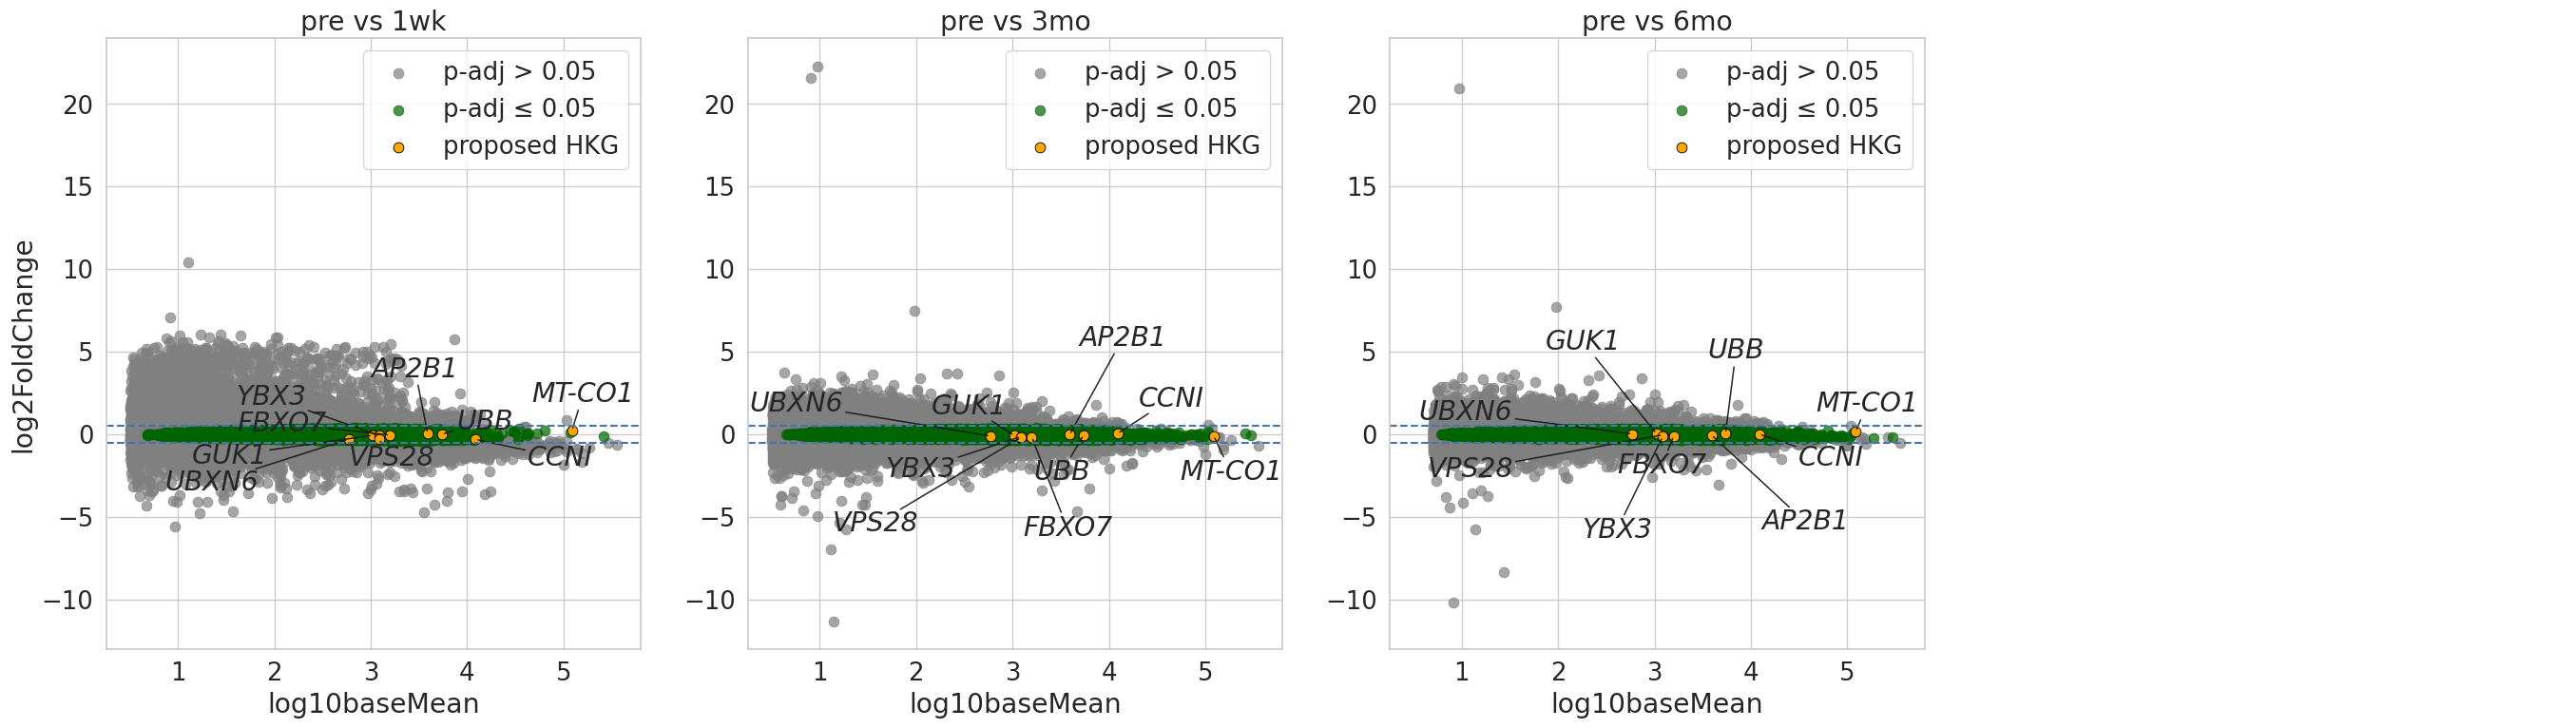

In [49]:
fig = plt.figure( figsize=(8.35*4,8.35) )
res_keys = [k for k in res_dict.keys() if ('lessAbs' in k) and ('0.5' in k)]
eq_genes = dict()

stable_genes = genes
i = 0 
# xlim_list = []
# ylim_list = []
title_list = ['pre vs 1wk', 'pre vs 3mo','pre vs 6mo']
for rk in res_keys:
    texts = []
    if i == 0:        
        ax = fig.add_subplot(1, len(res_keys)+1, i+1)
        ax_1 = ax
    else:
        ax = fig.add_subplot(1, len(res_keys)+1, i+1, sharey=ax_1, sharex=ax_1 )
    
    lfc_null = float(rk.split('_')[3])    
    ref_not_p = res_dict[rk].loc[(res_dict[rk].index.isin(hkg_kidney_ref)) & (res_dict[rk].padj>0.05),:].index.tolist()
    ref_not_lfc = res_dict[rk].loc[(res_dict[rk].index.isin(hkg_kidney_ref)) & (res_dict[rk].log2FoldChange.abs()>lfc_null),:].index.tolist()
    eq_genes[' vs '.join(rk.replace('vs_','').split('_')[-2:])] = set(res_dict[rk][(res_dict[rk].baseMean>0) & (res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05)].index.tolist())
    
    
    ax.axhline(-lfc_null, ls='--', lw=1.5)
    ax.axhline(+lfc_null, ls='--', lw=1.5)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='gray', alpha=.7, edgecolor=None, label='p-adj > 0.05', s=60, data=res_dict[rk].loc[(res_dict[rk].padj>0.05),:], ax=ax)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='darkgreen', alpha=.7, edgecolor=None, label='p-adj ≤ 0.05', s=60, data=res_dict[rk].loc[(res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05) & (~res_dict[rk].index.isin(stable_genes)),:], ax=ax)
    sns.scatterplot(x='log10baseMean', y='log2FoldChange', color='orange', alpha=1, edgecolor='black', label='proposed HKG', s=60, data=res_dict[rk].loc[(res_dict[rk].log2FoldChange.abs()<=lfc_null) & (res_dict[rk].padj<=0.05) & (res_dict[rk].index.isin(stable_genes)),:], ax=ax)
    ax.set_title(title_list[i])
    # , style='italic'    
    if i > 0:
        ax.set_ylabel('')
        
    # ax.set_xlim(xlim_list[i])
    # ax.set_ylim(ylim_list[i])
    
    i+=1
   
    for l,x,y in res_dict[rk].loc[(res_dict[rk].index.isin(stable_genes)),:][['log10baseMean','log2FoldChange']].reset_index().values:
        texts.append(ax.text(x, y, l,  va='center',ha='center', fontstyle='italic',
                            ))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
                expand=(2, 2),
               )

    # xlim_list.append(ax.get_xlim())
    # ylim_list.append(ax.get_ylim())

    # ax.get_legend().remove()
    # ax.grid(False)
    # ax.spines[['left','right', 'top','bottom']].set_visible(False)
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    # ax.set_xlabel('')
    # ax.set_ylabel('')
    
ax = fig.add_subplot(144)
ax.grid(False)
ax.spines[['left','right', 'top','bottom']].set_visible(False)
ax.set_yticklabels([])
ax.set_xticklabels([])


fig.savefig('./draft/FIG2ABC_TOST_hkg_ann.pdf', bbox_inches='tight', format='pdf', dpi=300)

## Fig 1D: Venn diagram with equivalent genes in different timepoints

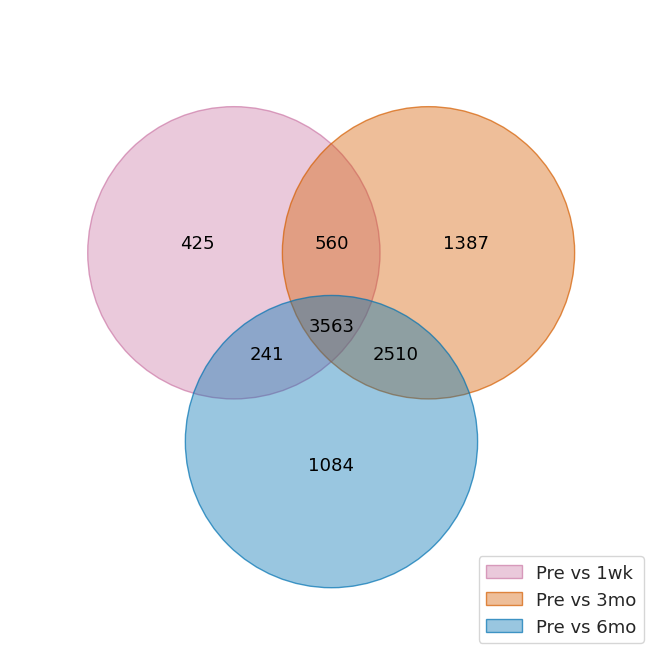

In [50]:
fig = plt.figure( figsize=(8.35,8.35) )   

ax = fig.add_subplot(1,1,1)
venn(eq_genes, cmap=Okabe_Ito[1:],  ax=ax)
legend = ax.get_legend()
legend.get_texts()[0].set_text('Pre vs 1wk')
legend.get_texts()[1].set_text('Pre vs 3mo')
legend.get_texts()[2].set_text('Pre vs 6mo')
legend.set_loc('lower right')
fig.savefig('./draft/FIG2D_Venn.pdf', format='pdf', dpi=300)

# Mining HKG from RNA-Seq studies (GSE175718, GSE120649, GSE112927, GSE86884)

The matrices were generated with Salmon

### Import Equivalent from GSE86884 study to filter them on next steps

In [22]:
path = './pre_posttransplant_PRJNA342822_GSE86884/hkg/'
lfc_null = 0.5
pv = 0.05
res_files = ['all_factors_lessAbs_0.5_pre_vs_1w_res.csv', 'all_factors_lessAbs_0.5_pre_vs_3m_res.csv', 'all_factors_lessAbs_0.5_pre_vs_6m_res.csv']
res = set()

for i,r in enumerate(res_files):
    aux = pd.read_csv(os.path.join(path,r), index_col=0)
    aux = aux[(aux['log2FoldChange'].abs()<=0.5) & ((aux['padj']<=0.05))]
    if i == 0:
        res = set(aux.index)
    else:
        res = res.intersection(set(aux.index))
print('There are',len(res),'common genes in pre vs 1wk, pre vs 3m and pre vs 6m')

There are 3563 common genes in pre vs 1wk, pre vs 3m and pre vs 6m


## Import RNAseq TMP and counts from Salmon output

### TPM and Counts

In [4]:
tx2gene = pd.read_csv('./gene_id2gene_nameWgene_lenght_biotype_gencode.v44.annotation.csv')

In [5]:
salmon_paths = ['./posttransplant_PRJNA733336_GSE175718/trimmed_salmon_quant/',                
                './posttransplant_PRJNA493832_GSE120649/trimmed_salmon_quant/',
                './pretransplant_PRJNA449520_GSE112927/trimmed_salmon_quant/',
                './pre_posttransplant_PRJNA342822_GSE86884/trimmed_salmon_quant/']
tpm = []
counts_tpm = []

for path in salmon_paths:
    tpm_aux = []
    counts_aux = []
    srr_list = os.listdir(path)
    print(path.split('/')[3], end=': ')
    for j,srr in enumerate(srr_list):
        df_aux = pd.read_csv(os.path.join(path,srr,'quant.sf'), sep='\t')[['Name','TPM','EffectiveLength','NumReads']].merge(tx2gene[['Transcript_ID','Gene_name']], left_on='Name', right_on='Transcript_ID')
        df_aux = df_aux.groupby('Gene_name').sum(numeric_only=True)  
        df_aux['counts_tpm'] = np.round(df_aux.NumReads,0).astype(int)
        tpm_aux.append(df_aux.TPM.values)
        counts_aux.append(df_aux.counts_tpm.values)
        print(j+1, end=' ')
    tpm.append(pd.DataFrame(tpm_aux, columns=df_aux.index, index=srr_list))
    counts_tpm.append(pd.DataFrame(counts_aux, columns=df_aux.index, index=srr_list))
    print('\n')
    
df_tpm = pd.concat(tpm, axis=0)
df_counts = pd.concat(counts_tpm, axis=0)

posttransplant_PRJNA733336_GSE175718: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 26

In [6]:
adata = ad.AnnData(df_tpm)
adata.layers['count'] = df_counts.loc[adata.obs.index,adata.var.index].values
adata

AnnData object with n_obs × n_vars = 731 × 60883
    layers: 'count'

### Metadata

#### GSE175718

In [7]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('./postransplant_cristian_colab/metadata/GSE175718_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE175718_meta = pd.DataFrame(aux).set_index(0).T
df_GSE175718_meta.columns = ['Title', 'Sample Name', 'ar', 'abmrh', 'tcmr', 'polyoma', 'dsa']
df_GSE175718_meta = pd.read_csv('./postransplant_cristian_colab/metadata/SraRunTable.txt')[['Sample Name', 'Run']].merge(df_GSE175718_meta, on='Sample Name').set_index('Sample Name')
df_GSE175718_meta['ar'] = df_GSE175718_meta.ar.str.split(':').str[1].str.strip()
df_GSE175718_meta['abmrh'] = df_GSE175718_meta.abmrh.str.split(':').str[1].str.strip()
df_GSE175718_meta['tcmr'] = df_GSE175718_meta.tcmr.str.split(':').str[1].str.strip()
df_GSE175718_meta['dsa'] = df_GSE175718_meta.dsa.str.split(':').str[1].fillna('0').str.strip()
df_GSE175718_meta['polyoma'] = df_GSE175718_meta.polyoma.str.split(':').str[-1].str.strip()
# no: 0_viremia:1_pvan:2_unknown:3
df_GSE175718_meta['abmrh_tcmr_dsa'] = df_GSE175718_meta[['abmrh', 'tcmr', 'dsa']].agg('-'.join,axis=1)
df_GSE175718_meta[['Title_GC','Title_LN']] = df_GSE175718_meta.Title.str.split('_', expand=True)
df_GSE175718_meta['Title_N'] = df_GSE175718_meta.Title_LN.str[1:]
df_GSE175718_meta['Title_L'] = df_GSE175718_meta.Title_LN.str[0]
df_GSE175718_meta = df_GSE175718_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE175718_meta['gse'] = 'GSE175718'
df_GSE175718_meta['gse_time'] = np.nan
df_GSE175718_meta['gse_patient'] = np.nan

#### GSE120649

In [8]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('./posttransplant_PRJNA493832_GSE120649/metadata/GSE120649_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
            
df_GSE120649_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE120649_meta.columns = ['Title', 'Sample Name']
df_GSE120649_meta['abmrh'] = np.where(df_GSE120649_meta.Title.str.contains('with antibody mediated rejection'), 1, 0)
df_GSE120649_meta['tcmr'] = np.where(df_GSE120649_meta.Title.str.contains('with T cell mediated rejection'), 1, 0)
df_GSE120649_meta['ar'] = df_GSE120649_meta.abmrh | df_GSE120649_meta.tcmr
df_GSE120649_meta = df_GSE120649_meta.merge(pd.read_csv('./posttransplant_PRJNA493832_GSE120649/metadata/SraRunTable.txt')[['Run','Sample Name']], on='Sample Name')
df_GSE120649_meta = df_GSE120649_meta[df_GSE120649_meta.Run.isin(adata.obs.index)]
df_GSE120649_meta = df_GSE120649_meta.set_index('Run')[['abmrh','tcmr','ar']]
df_GSE120649_meta['gse'] = 'GSE120649'
df_GSE120649_meta['gse_time'] = np.nan
df_GSE120649_meta['gse_patient'] = np.nan

#### GSE112927

In [9]:
df_GSE112927_meta = pd.read_csv('./pretransplant_PRJNA449520_GSE112927/metadata/SraRunTable.txt')[['Run','acr_before_or_at_6m','acr_after_6m','LibraryLayout']].set_index('Run')
df_GSE112927_meta['acr_before_or_at_6m'] = df_GSE112927_meta.acr_before_or_at_6m.replace('None', np.nan).replace('ACR or Borderline', '_b6mo')
df_GSE112927_meta['acr_after_6m'] = df_GSE112927_meta.acr_after_6m.replace('None', np.nan).replace('ACR', '_a6mo').replace('Borderline', '_a6mo')
df_GSE112927_meta = df_GSE112927_meta.fillna('')
df_GSE112927_meta['gse'] = 'GSE112927'
df_GSE112927_meta['gse_time'] = df_GSE112927_meta.gse + df_GSE112927_meta.acr_before_or_at_6m + df_GSE112927_meta.acr_after_6m
df_GSE112927_meta['gse_patient'] = df_GSE112927_meta.gse + '_' + df_GSE112927_meta.LibraryLayout
df_GSE112927_meta['abmrh'] = 0
df_GSE112927_meta['tcmr'] = 0
df_GSE112927_meta['ar'] = np.where((df_GSE112927_meta.acr_before_or_at_6m != '') | (df_GSE112927_meta.acr_after_6m != ''), '1', '0')
df_GSE112927_meta = df_GSE112927_meta.drop(['acr_before_or_at_6m', 'acr_after_6m', 'LibraryLayout'], axis=1)

#### GSE86884

In [10]:
keys_tags = ['!Sample_title', '!Sample_geo_accession', '!Sample_characteristics_ch1']#'!Series_sample_id', 
aux = []
with gzip.open('./pre_posttransplant_PRJNA342822_GSE86884/metadata/GSE86884_series_matrix.txt.gz') as gse_f:
    for line in gse_f:
        if line.decode().split('\t')[0] in keys_tags:
            aux.append(line.decode().replace('\n','').replace('"','').split('\t'))
df_GSE86884_meta = pd.DataFrame(aux).set_index(0).T.iloc[:,:2]
df_GSE86884_meta.columns = ['patient','Sample Name']

df_GSE86884_meta = df_GSE86884_meta.merge(pd.read_csv('./pre_posttransplant_PRJNA342822_GSE86884/metadata/SraRunTable.txt')[['Run','time_of_blood_draw','Sample Name']], on='Sample Name').set_index('Run')
condlist = [df_GSE86884_meta.time_of_blood_draw.str.startswith('pre'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('1'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('3'),
            df_GSE86884_meta.time_of_blood_draw.str.startswith('6')]
choicelist = ['GSE86884_'+'pre', 'GSE86884_'+'1wk', 'GSE86884_'+'3mo', 'GSE86884_'+'6mo']
df_GSE86884_meta['gse_time'] = np.select(condlist=condlist, choicelist=choicelist)

df_GSE86884_meta['gse'] = 'GSE86884'
df_GSE86884_meta['gse_patient'] = df_GSE86884_meta.patient.str.split('-').str[2]
df_GSE86884_meta['abmrh'] = 0
df_GSE86884_meta['tcmr'] = 0
df_GSE86884_meta['ar'] = 0
df_GSE86884_meta = df_GSE86884_meta.drop(['patient','Sample Name','time_of_blood_draw'], axis=1)

In [11]:
adata.obs[['abmrh', 'tcmr', 'ar', 'gse','gse_time','gse_patient']] = pd.concat([df_GSE175718_meta,df_GSE120649_meta,df_GSE112927_meta,df_GSE86884_meta]).loc[adata.obs.index,:].astype(str).values

In [12]:
adata.var['equivalent'] = np.where(adata.var.index.isin(res), 'equivalent','non_equivalent')

In [13]:
adata

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient'
    var: 'equivalent'
    layers: 'count'

## Create groups by unsupervised clustering
The groups are created based on TPM and Louvain clustering. Since the package of Louvain doesn't support random_seed, the cluster can differ from ours. But we saved the annData with estimated cluster.

In [14]:
hkg.pp.create_groups(adata, study_col='gse')

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

## SUPPLEMENTAL FIG S1: Unsupervised clustering

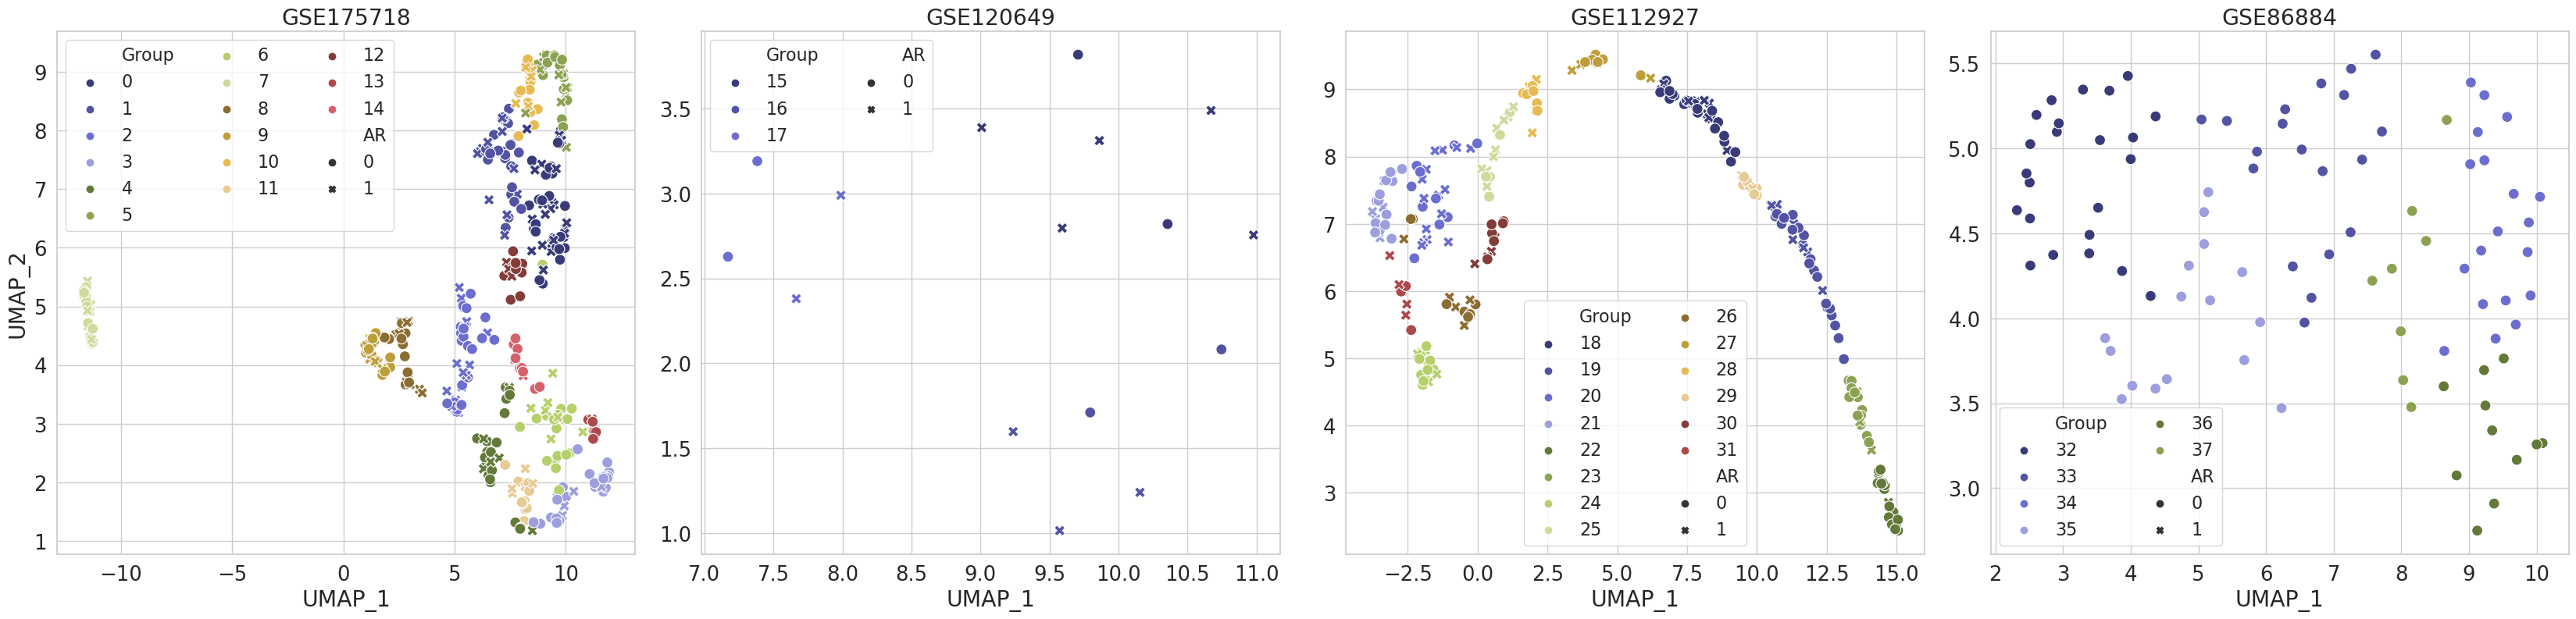

In [52]:
fig = plt.figure(figsize=(8.35*4,8.35))
for i, gse in enumerate(['GSE175718','GSE120649','GSE112927','GSE86884']):
    ax = fig.add_subplot(1,4,i+1)
    if gse == 'GSE86884':
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='ar', s=100, palette='tab20b', data=adata.obs[adata.obs.gse==gse].dropna(), ax=ax)
    else:
        sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='louvain_group', style='ar', s=100, palette='tab20b', data=adata.obs[adata.obs.gse==gse], ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    labels = [l.replace('louvain_group','Group').replace('ar', 'AR') for l in labels]
    ncol = 2
    if gse in ['GSE175718']:
        ncol=3
    ax.legend(handles=handles, labels=labels, ncol=ncol, fontsize=16)
    ax.set_title(gse)

    if i > 0:
        ax.set_ylabel('')
fig.tight_layout()
fig.savefig('./draft/FIGS1_louvain.pdf', format='pdf', dpi=300)

## Read UNpreprocessed adata
Until clustering groups by similarity between samples 

In [51]:
# adata.write_h5ad('./adata_RNAseq_louvain.h5ad')
adata = ad.read_h5ad('./adata_RNAseq_louvain.h5ad')
adata

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

## Mapping types off transformation

Setting type o transformation for each study separately

In [294]:
adata.obs['type'] = adata.obs.gse.map({'GSE175718': 'MRN', 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})

In [295]:
trns_dict = dict(adata.obs[['louvain_group','type']].values)
hkg.pp.transform_exprs(adata, layer='count', groups_col='louvain_group', trns_dict=trns_dict)

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr'

## Log transforming trans_expr

In [296]:
hkg.pp.log_transform(adata, layer='trns_expr', method='log1p')
hkg.pp.log_transform(adata, layer='trns_expr', method='arcsinh')

AnnData object with n_obs × n_vars = 731 × 60883
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

## Keepping only equivalent genes calculated in FIG 1-ABCD
excluding GSE86884 because there is only non-rejection and it was already used to calculate equivalent genes by DESeq2

In [297]:
adata = adata[adata.obs.gse!='GSE86884',adata.var.equivalent=='equivalent']
adata

View of AnnData object with n_obs × n_vars = 635 × 3563
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

## Exclude genes with high number of zeros expressions

We calclulated the number of zero expression for each gene and excluded genes with high number of zeros in samples.

In [298]:
aux = adata.to_df()
print('non-zero expr median quantity:', (aux>0).sum().quantile(.5))

non-zero expr median quantity: 627.0


In [299]:
cols = aux.loc[:,((aux>0).sum()>=600).values].columns.values.tolist()
print('Qty. of genes with non-zero counts >= 600:', len(cols))

Qty. of genes with non-zero counts >= 600: 2638


## Keep only genes with at least 600 non zeros expression

In [35]:
adata = adata[:,cols]
adata

View of AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'log1p', 'arcsinh'

## Calculate genes clusters by cv, stability and gini

### Calculate CV, stb_cv and gene with housekeepingMiningPy package

In [61]:
hkg.mining.exprs_cv(adata, layer='arcsinh', groups_col='louvain_group')
hkg.mining.stability_cv(adata, layer='arcsinh', groups_col='louvain_group')
hkg.mining.gene_gini_coeff(adata, layer='arcsinh')

CV: computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
Stability: computing groups data: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 


AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

In [62]:
adata.var['log_pool_mean'] = np.log(adata.var.pool_mean)
adata.var['log_pool_cv'] = np.log(adata.var.pool_cv)
adata.var['log_pool_stability_cv'] = np.log(adata.var.pool_stability_cv)
adata.var['log_gini_coefficient'] = np.log(adata.var.gini_coefficient)

### Clustering most similar genes by cv, gini and stb

In [63]:
nearestNeighbors_object = NearestNeighbors()
louvain_object = Louvain(random_state=42, resolution=.5)
scaler_object = StandardScaler()

In [64]:
hkg.mining.uclustering_cv_stb_gini(adata, cl_cols=['log_pool_cv','log_pool_stability_cv','log_gini_coefficient'],
                                   nearestNeighbors_object=nearestNeighbors_object,
                                   louvain_object=louvain_object,scaler_object=scaler_object)

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'count', 'log1p', 'trns_expr', 'trns_expr_per_louvain_group', 'arcsinh_per_louvain_group', 'log1p_per_louvain_group'

### FIG 2E-J

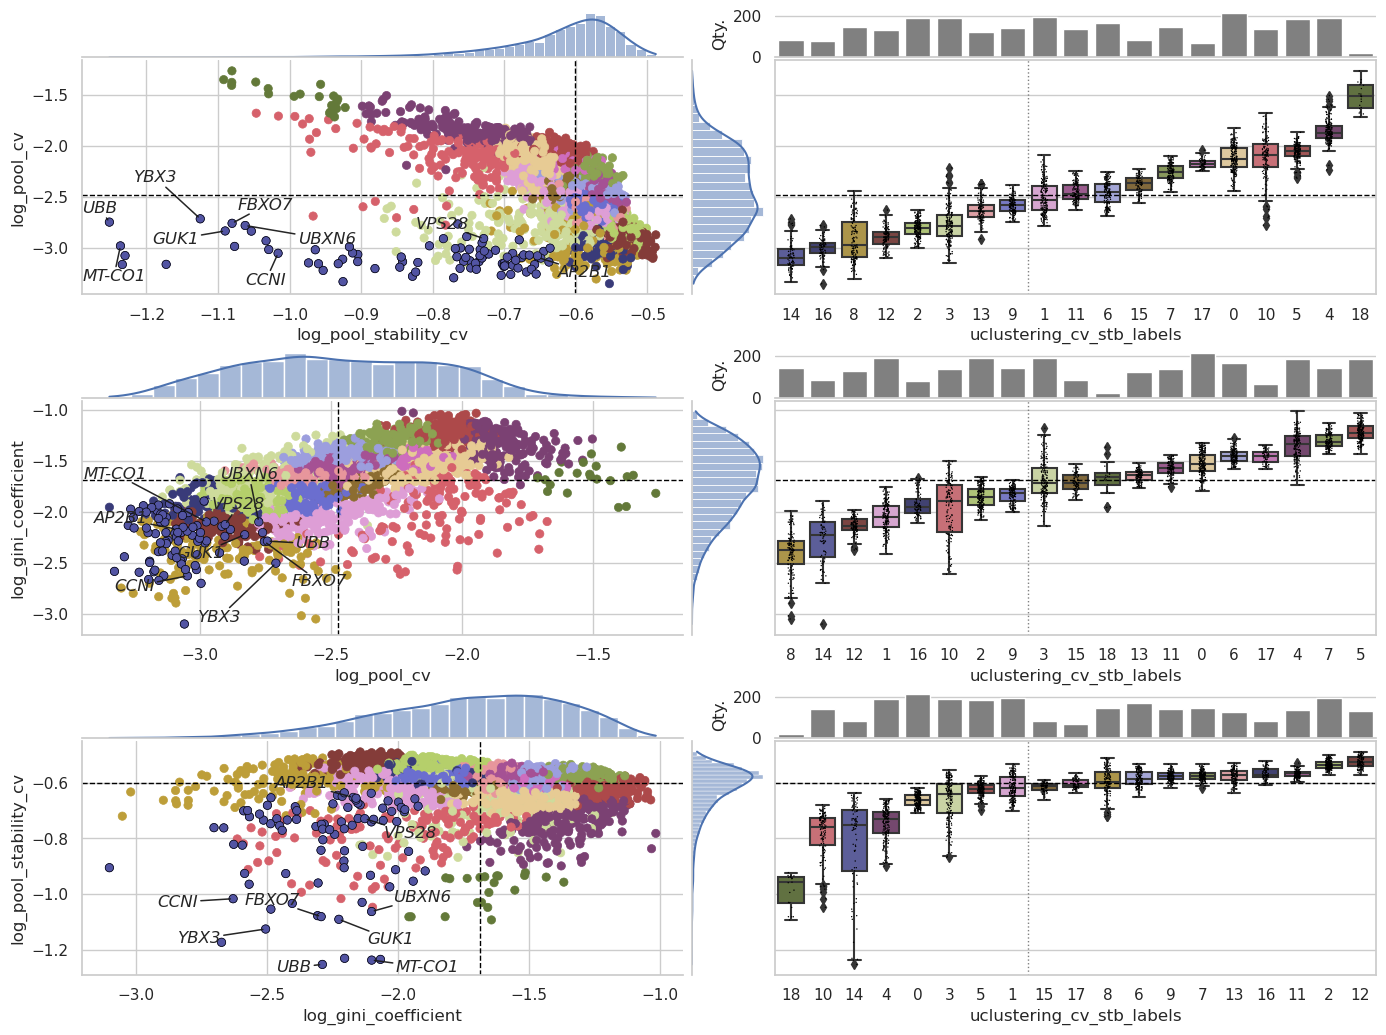

In [57]:
# feats_3 = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']
hkg.plot.plot_stb_cv_gini(adata, x='log_pool_stability_cv', y='log_pool_cv', z='log_gini_coefficient', hue='uclustering_cv_stb_labels', palette='tab20b_r',figsize=(8.35*2,8.35*3/2), ann_genes=genes, highlight_group=14, savefig={'fname':'./draft/FIG2EJ_CV_cvSTB_GINI.pdf', 'bbox_inches':'tight', 'format':'pdf', 'dpi':300})

### Read preprocessed adata

Since the Louvain algorithm doesn't support random_seed, we saved the data, so the folloeing process can be reproducible.

In [53]:
# adata.write_h5ad('./adata_RNAseq_pre_processed.h5ad')
adata = ad.read_h5ad('./adata_RNAseq_pre_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

### Since group 14 is entirely bellow the median of all metrics (cv, gini, stb). We chose it to following analysis

We named the genes as feats_1

In [175]:
adata[:,adata.var.uclustering_cv_stb_labels==14]

View of AnnData object with n_obs × n_vars = 635 × 85
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

In [59]:
feats_1 = adata[(adata.obs.gse=='GSE175718'), (adata.var.uclustering_cv_stb_labels.isin([14]))].var.index.tolist()
print(len(feats_1),feats_1)

85 ['AKNA', 'AKT2', 'ANKRD11', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'BTG1', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'CYLD', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'EWSR1', 'FBXO7', 'FNBP1', 'FUS', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PRRC2C', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']


## Kruskal Wallis DEG

Exclude significant expressed genes for Kruskal Wallis H testing between non-rejection, ABMR and TCMR. We ran only on **GSE175718**

In [60]:
condlist = [(adata.obs.abmrh=='0') & (adata.obs.tcmr=='0'), (adata.obs.abmrh=='0') & (adata.obs.tcmr=='1'), (adata.obs.abmrh=='1') & (adata.obs.tcmr=='0'), (adata.obs.abmrh=='1') & (adata.obs.tcmr=='1')]
choicelist = ['non-rejection', 'TCMR', 'ABMR', 'ABMR and TCMR']

adata.obs['conditions_GSE175718'] = np.select(condlist=condlist, choicelist=choicelist)

In [61]:
# rename layers to rerun trans MRN on remaining genes
adata.layers['trns_expr_per_louvain_group'] = adata.layers['trns_expr'].copy()
adata.layers['arcsinh_per_louvain_group'] = adata.layers['arcsinh'].copy()
adata.layers['log1p_per_louvain_group'] = adata.layers['log1p'].copy()

In [62]:
trns_dict = dict(adata.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata, layer='count', groups_col='gse', trns_dict=trns_dict)
hkg.pp.log_transform(adata, layer='trns_expr', method='arcsinh')

AnnData object with n_obs × n_vars = 635 × 2638
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'type', 'conditions_GSE175718'
    var: 'equivalent', 'pool_mean', 'pool_std', 'pool_cv', 'pool_stability_cv', 'gini_coefficient', 'log_pool_mean', 'log_pool_cv', 'log_pool_stability_cv', 'log_gini_coefficient', 'uclustering_cv_stb_labels'
    layers: 'arcsinh', 'arcsinh_per_louvain_group', 'count', 'log1p', 'log1p_per_louvain_group', 'trns_expr', 'trns_expr_per_louvain_group'

### Calculating Kruskall Wallis H with scipy

In [63]:
aux = adata[(adata.obs.gse=='GSE175718'), feats_1].to_df('trns_expr')
aux['conditions_GSE175718'] = adata[adata.obs.gse=='GSE175718',:].obs.conditions_GSE175718.values
genes = aux.columns[:-1]
pv = []
for g in genes:
    pv.append(kruskal(aux.loc[(aux.conditions_GSE175718=='non-rejection'),g], aux.loc[(aux.conditions_GSE175718=='ABMR'),g], aux.loc[(aux.conditions_GSE175718=='TCMR'),g]).pvalue)

In [64]:
aux_pv = pd.DataFrame(zip(aux.columns[:-1],pv))
aux_pv.columns = ['Genes','Kruskal_Wallis_pv']
aux_pv.to_csv('./draft/Kruskal_Wallis_H_test_differences_HKG.csv', index=0)

In [65]:
aux_pv = aux_pv.set_index('Genes')
pv_kr = aux_pv[aux_pv['Kruskal_Wallis_pv']<=.05].index.tolist()
print(pv_kr)

['AKT2', 'ANKRD11', 'BTG1', 'CYLD', 'EWSR1', 'FUS', 'PRRC2C']


### The genes 'AKT2', 'ANKRD11', 'BTG1', 'CYLD', 'EWSR1', 'FUS', 'PRRC2C' are statistic significantly diferent between conditions.

We excluded those genes and create a new set without them, feats_2

In [66]:
feats_2 = [f for f in feats_1 if f not in pv_kr]
print(len(feats_2),feats_2)

78 ['AKNA', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'FBXO7', 'FNBP1', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']


In [54]:
feats_2 = ['AKNA', 'ANKRD44', 'AP2B1', 'BRD2', 'BRD4', 'CALM1', 'CCNI', 'CD74', 'CELF1', 'CELF2', 'CHD2', 'COX4I1', 'CSDE1', 'CTDNEP1', 'CYFIP2', 'DDX17', 'DDX5', 'DDX6', 'DYNC1H1', 'EIF1', 'EIF3A', 'FBXO7', 'FNBP1', 'GSTK1', 'GUK1', 'HAGH', 'HMGB1', 'HNRNPC', 'HNRNPL', 'HNRNPU', 'HNRNPUL1', 'HSP90AA1', 'IDS', 'IKZF1', 'ITGAL', 'MACF1', 'MAVS', 'MDM4', 'MT-CO1', 'N4BP2L2', 'NAP1L1', 'NLRP1', 'OIP5-AS1', 'PABPC1', 'PCBP2', 'PNISR', 'POLR2J3', 'PPIA', 'PRMT2', 'PTP4A2', 'RBM25', 'RBM39', 'RBM5', 'RPS9', 'SEPTIN6', 'SERBP1', 'SET', 'SF1', 'SF3B2', 'SFPQ', 'SON', 'SPG7', 'SRRM2', 'SUN2', 'TCF25', 'TMSB10', 'TRIM56', 'TSPAN14', 'TUBB', 'TUG1', 'UBB', 'UBC', 'UBXN6', 'VPS28', 'YBX1', 'YBX3', 'ZBTB7A', 'ZNF207']

## [TOST](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5502906/)
Keeping only the equivalent genes in the study **GSE175718**

We didn't calculate TOST by louvain group because there were some groups with low values of hits in some conditions.

We consider an equivalent distribution if the difference is in between cohen's d <=.3 and tested two-one-sided with brunnermunzel test

### exluding sample SRR14675592 since all values are equal zero.

In [67]:
adata['SRR14675592',feats_2].X

ArrayView([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0.]])

In [69]:
pv_tost = hkg.mining.tost(adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592'), feats_2],
                          combinations_list=[('non-rejection', 'ABMR'), ('non-rejection', 'TCMR')], layer='trns_expr', class_col='conditions_GSE175718',
                          cohens_d=.3,is_parametric=False, is_paired=False, correct_fdr=True)

In [70]:
### We choose genes with adjusted pvalue <= 0.05

In [71]:
feats_3 = np.sort(pv_tost.loc[:,(pv_tost<=0.05).sum()>=2].columns).tolist()
pv_tost = pv_tost.loc[:,(pv_tost<=0.05).sum()>=2]
pv_tost.index = pv_tost.index.str.replace('pv_','').str.split('_')
print(len(feats_3),feats_3)

9 ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']


In [72]:
# feats_3 = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'MT-CO1', 'UBB', 'UBXN6', 'VPS28', 'YBX3']

In [73]:
pv_tost.to_csv('./draft/FIG2K_TOST_KW.csv')

In [74]:
aux = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718!='ABMR and TCMR'), feats_3].to_df('arcsinh')
aux['conditions_GSE175718'] = adata[(adata.obs.gse=='GSE175718') & (adata.obs.index!='SRR14675592') & (adata.obs.conditions_GSE175718!='ABMR and TCMR'),feats_3].obs.conditions_GSE175718.values
aux = aux.melt(id_vars='conditions_GSE175718')

### FIG 2K: Equivalence test

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UBXN6_non-rejection vs. UBXN6_ABMR: Custom statistical test, P_val:1.642e-03
AP2B1_non-rejection vs. AP2B1_ABMR: Custom statistical test, P_val:1.657e-02
FBXO7_non-rejection vs. FBXO7_ABMR: Custom statistical test, P_val:2.838e-02
CCNI_non-rejection vs. CCNI_ABMR: Custom statistical test, P_val:1.039e-02
VPS28_non-rejection vs. VPS28_ABMR: Custom statistical test, P_val:9.481e-03
MT-CO1_non-rejection vs. MT-CO1_ABMR: Custom statistical test, P_val:1.046e-02
GUK1_non-rejection vs. GUK1_ABMR: Custom statistical test, P_val:4.526e-02
UBB_non-rejection vs. UBB_ABMR: Custom statistical test, P_val:1.642e-03
YBX3_non-rejection vs. YBX3_ABMR: Custom statistical test, P_val:4.980e-02
UBXN6_non-rejection vs. UBXN6_TCMR: Custom statistical test, P_val:1.397e-02
FBXO7_non-rejection vs. FBXO7_TCMR: Custom sta

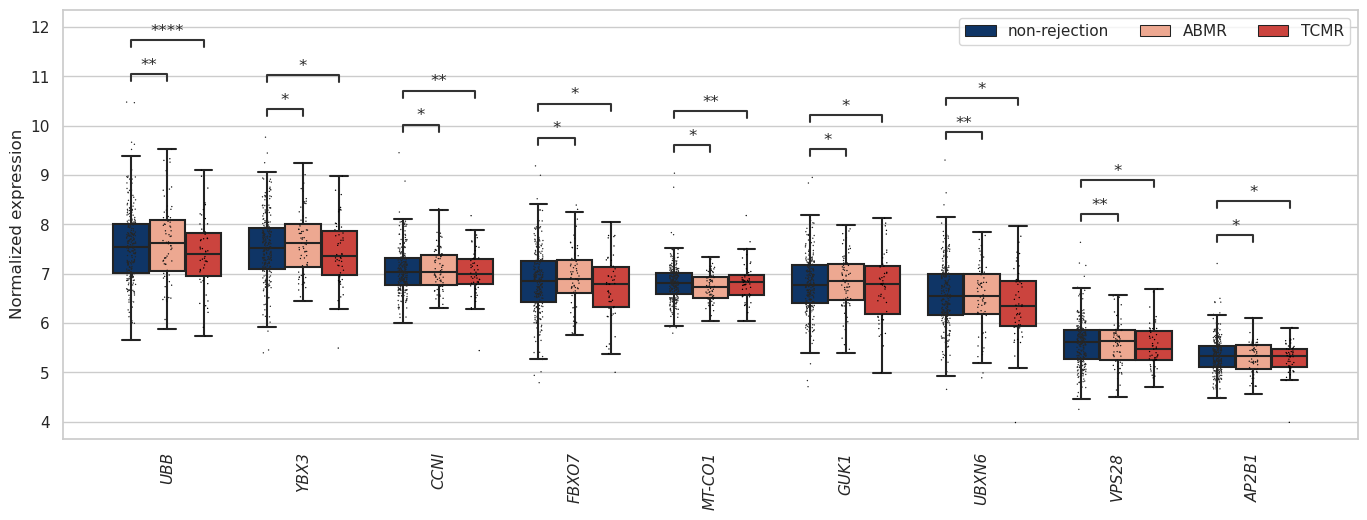

In [75]:
fig = plt.figure(figsize=(8.35*2, 8.35*2/3))
ax = fig.add_subplot(111)

x='Gene_name'
y='value'
hue='conditions_GSE175718'
hue_order=['non-rejection','ABMR','TCMR']
order = aux.groupby(['Gene_name']).median(numeric_only=True).sort_values('value', ascending=False).index

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=1, dodge=True, data=aux, ax=ax)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, palette=['#003375', '#fca082', '#e32f27'], fliersize=False, data=aux, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels[3:], ncol=3)

for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_fontstyle('italic')

ax.set_xlabel('')
ax.set_ylabel('Normalized expression')

pairs = []
p_test = []
for c in pv_tost.columns:
    p_test.extend(pv_tost[c].values.tolist())
    for i in pv_tost.index:        
        pairs.append(((c,i[0]),(c,i[1])))
        
annot_test = Annotator(ax, pairs, data=aux, x=x, y=y, order=order, hue=hue, hue_order=hue_order)
annot_test.configure(test=None, text_format='star', loc='inside', verbose=1)
annot_test.set_pvalues(p_test)
annot_test.annotate()

plt.show()
fig.savefig('./draft/FIG2K_TOST_KW.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Validation in Microarray dataset

The microarray dataset were background corrected via affy::rma functiona. But the quantile normalization was made by scikitlearning

*We had to use this [**table**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570) to find the probes symbols for genes MT-CO1 and UBNX6. Since we didn't find the microarray data after translate with mygene package.

In [ ]:
# download_MA_CEL.sh
# Run to download microarray files
# #!/bin/bash

# gses=("GSE129166" "GSE46474" "GSE15296" "GSE14346")
# https=("https://ftp.ncbi.nlm.nih.gov/geo/series/GSE129nnn/GSE129166/suppl//GSE129166_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE46nnn/GSE46474/suppl//GSE46474_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE15nnn/GSE15296/suppl//GSE15296_RAW.tar" "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE14nnn/GSE14346/suppl//GSE14346_RAW.tar")

# for i in $(seq 0 3);
# do
#     echo "wget ${https[$i]}";
#     echo "tar -xvf ${gses[$i]}_RAW.tar -C ./posttransplant_${gses[$i]}/${gses[$i]}_CEL";
# done

In [114]:
# R script to get _CEL.tsv
# %%R
# library(affy)

# dir = 'D:/posttransplant_GSE129166/hkg/GSE129166_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/posttransplant_GSE129166/hkg/GSE129166_CEL.tsv')

# dir = 'D:/posttransplant_GSE14346/hkg/GSE14346_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/posttransplant_GSE14346/hkg/GSE14346_CEL.tsv')

# dir = 'D:/posttransplant_GSE15296/hkg/GSE15296_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/posttransplant_GSE15296/hkg/GSE15296_CEL.tsv')

# dir = 'D:/posttransplant_GSE46474/hkg/GSE46474_CEL'
# filenames = list.files(dir, pattern="*.CEL.gz", full.names=TRUE)
# raw_data = affy::ReadAffy(filenames=filenames)
# eset = affy::rma(raw_data, normalize=FALSE)
# write.exprs(eset, file='D:/posttransplant_GSE46474/hkg/GSE46474_CEL.tsv')

## Read translation probe_id to gene symbol 

In [76]:
df_gens = pd.read_csv('./Microarray_RNAseq_mygene_translation.csv', index_col=0, header=None, names=['GeneNames','TranslationStatus'])

## Replace manually UBXN6 and MT-CO1

In [77]:
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'GeneNames'] = 'MT-CO1'
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'GeneNames'] = 'UBXN6'
df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'TranslationStatus'] = 'ok'

## Read expression and metadata files

In [78]:
df_GSE14346 = pd.read_csv('./posttransplant_GSE14346/GSE14346_CEL.tsv', sep='\t', index_col=0)
df_GSE14346 = df_GSE14346.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T

df_GSE14346.index = df_GSE14346.index.str.replace('.CEL.gz', '', regex=False)
df_GSE14346_meta = pd.read_csv('./posttransplant_GSE14346/GSE14346_meta.tsv', sep='\t', index_col=0)[['characteristics_ch1','disease state:ch1']]
df_GSE14346_meta = df_GSE14346_meta[df_GSE14346_meta['characteristics_ch1']=='Kidney, Peripheral Blood']
df_GSE14346_meta['ar'] = np.where(df_GSE14346_meta['disease state:ch1'].str.contains('AR'), 1, 0)
df_GSE14346_meta['gse'] = 'GSE14346'

df_GSE15296 = pd.read_csv('./posttransplant_GSE15296/GSE15296_CEL.tsv', sep='\t', index_col=0) #GSE14346#GSE15296
df_GSE15296 = df_GSE15296.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE15296.index = df_GSE15296.index.str.replace('.CEL.gz', '', regex=False)
df_GSE15296_meta = pd.read_csv('./posttransplant_GSE15296/GSE15296_meta.tsv', sep='\t', index_col=0)[['phenotype:ch1']]
df_GSE15296_meta['ar'] = np.where(df_GSE15296_meta['phenotype:ch1'].str.contains('Rejection'), 1, 0)
df_GSE15296_meta['gse'] = 'GSE15296'

df_GSE129166 = pd.read_csv('./posttransplant_GSE129166/GSE129166_CEL.tsv', sep='\t', index_col=0)
df_GSE129166 = df_GSE129166.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE129166 = df_GSE129166.loc[df_GSE129166.index.str.contains('Blood')]
df_GSE129166.index = df_GSE129166.index.str.split('_').str[0]
df_GSE129166_meta = pd.read_csv('./posttransplant_GSE129166/GSE129166_meta.tsv', sep='\t', index_col=0).T
df_GSE129166_meta = df_GSE129166_meta[ df_GSE129166_meta['!Sample_source_name_ch1'].str.contains('Blood') ]
df_GSE129166_meta['ar'] = np.where( (df_GSE129166_meta.iloc[:,-3].str.endswith('1')) | (df_GSE129166_meta.iloc[:,-2].str.endswith('1')), 1, 0 )
df_GSE129166_meta['gse'] = 'GSE129166'
df_GSE129166 = df_GSE129166.loc[df_GSE129166_meta.index,:]

df_GSE46474 = pd.read_csv('./posttransplant_GSE46474/GSE46474_CEL.tsv', sep='\t', index_col=0)
df_GSE46474 = df_GSE46474.merge(df_gens[['GeneNames']], left_index=True, right_index=True).groupby('GeneNames').median().T
df_GSE46474.index = df_GSE46474.index.str.split('_').str[0]
df_GSE46474_meta = pd.read_csv('./posttransplant_GSE46474/GSE46474_meta.tsv', sep='\t', index_col=0).T
df_GSE46474_meta['ar'] = np.where( df_GSE46474_meta['!Sample_source_name_ch1'].str.contains('AR'), 1, 0)
df_GSE46474_meta['gse'] = 'GSE46474'

In [79]:
meta_cols = ['ar', 'gse']
meta_ma = pd.concat([df_GSE14346_meta[meta_cols], df_GSE15296_meta[meta_cols], df_GSE129166_meta[meta_cols], df_GSE46474_meta[meta_cols]]) 

In [110]:
adata_ma = ad.AnnData(pd.concat([df_GSE14346, df_GSE15296,df_GSE129166,df_GSE46474]).loc[:,
                      [c for c in pd.concat([df_GSE14346, df_GSE15296,df_GSE129166,df_GSE46474]).columns if not c.endswith('_at')]])


adata_ma = adata_ma[meta_ma.index,:]
adata_ma.obs = meta_ma.loc[adata_ma.obs.index,:]

In [111]:
trns_dict = {gse:'quantile' for gse in adata_ma.obs.gse.unique()}
hkg.pp.transform_exprs(adata_ma, groups_col='gse', trns_dict=trns_dict)

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    layers: 'trns_expr'

## Calculate CV, STB and Gini for microarray dataset

In [112]:
layer = None
hkg.mining.exprs_cv(adata_ma, layer=layer, groups_col='gse',return_mean_per_group = True, return_cv_per_group= True)
hkg.mining.stability_cv(adata_ma, layer=layer, groups_col='gse', return_stb_cv_per_group=True)
hkg.mining.gene_gini_coeff(adata_ma, layer=layer, groups_col='gse')

CV: computing groups data: 0 1 2 3 
Stability: computing groups data: 0 1 2 3 
Gini: computing groups data: 0 1 2 3 


AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [113]:
for c in adata_ma.var.columns:
    adata_ma.var['log_'+c] = np.log(adata_ma.var[c])

In [80]:
# adata_ma.write_h5ad('/mnt/d/housekeeping_genes/adata_MA.h5ad')
adata_ma = ad.read_h5ad('./adata_MA.h5ad')
adata_ma

AnnData object with n_obs × n_vars = 291 × 20828
    obs: 'ar', 'gse'
    var: 'mean_GSE14346', 'cv_GSE14346', 'mean_GSE15296', 'cv_GSE15296', 'mean_GSE129166', 'cv_GSE129166', 'mean_GSE46474', 'cv_GSE46474', 'pool_mean', 'pool_std', 'pool_cv', 'stb_GSE14346', 'stb_GSE15296', 'stb_GSE129166', 'stb_GSE46474', 'pool_stability_cv', 'gini_coefficient', 'gini_coefficient_GSE14346', 'gini_coefficient_GSE15296', 'gini_coefficient_GSE129166', 'gini_coefficient_GSE46474', 'log_mean_GSE14346', 'log_cv_GSE14346', 'log_mean_GSE15296', 'log_cv_GSE15296', 'log_mean_GSE129166', 'log_cv_GSE129166', 'log_mean_GSE46474', 'log_cv_GSE46474', 'log_pool_mean', 'log_pool_std', 'log_pool_cv', 'log_stb_GSE14346', 'log_stb_GSE15296', 'log_stb_GSE129166', 'log_stb_GSE46474', 'log_pool_stability_cv', 'log_gini_coefficient', 'log_gini_coefficient_GSE14346', 'log_gini_coefficient_GSE15296', 'log_gini_coefficient_GSE129166', 'log_gini_coefficient_GSE46474'
    layers: 'trns_expr'

In [81]:
feats_3_ma = feats_3

## FIG 3A-L: Plot CV, GINI and Stability cv

0 1 2 3 4 5 6 7 8 9 10 11 

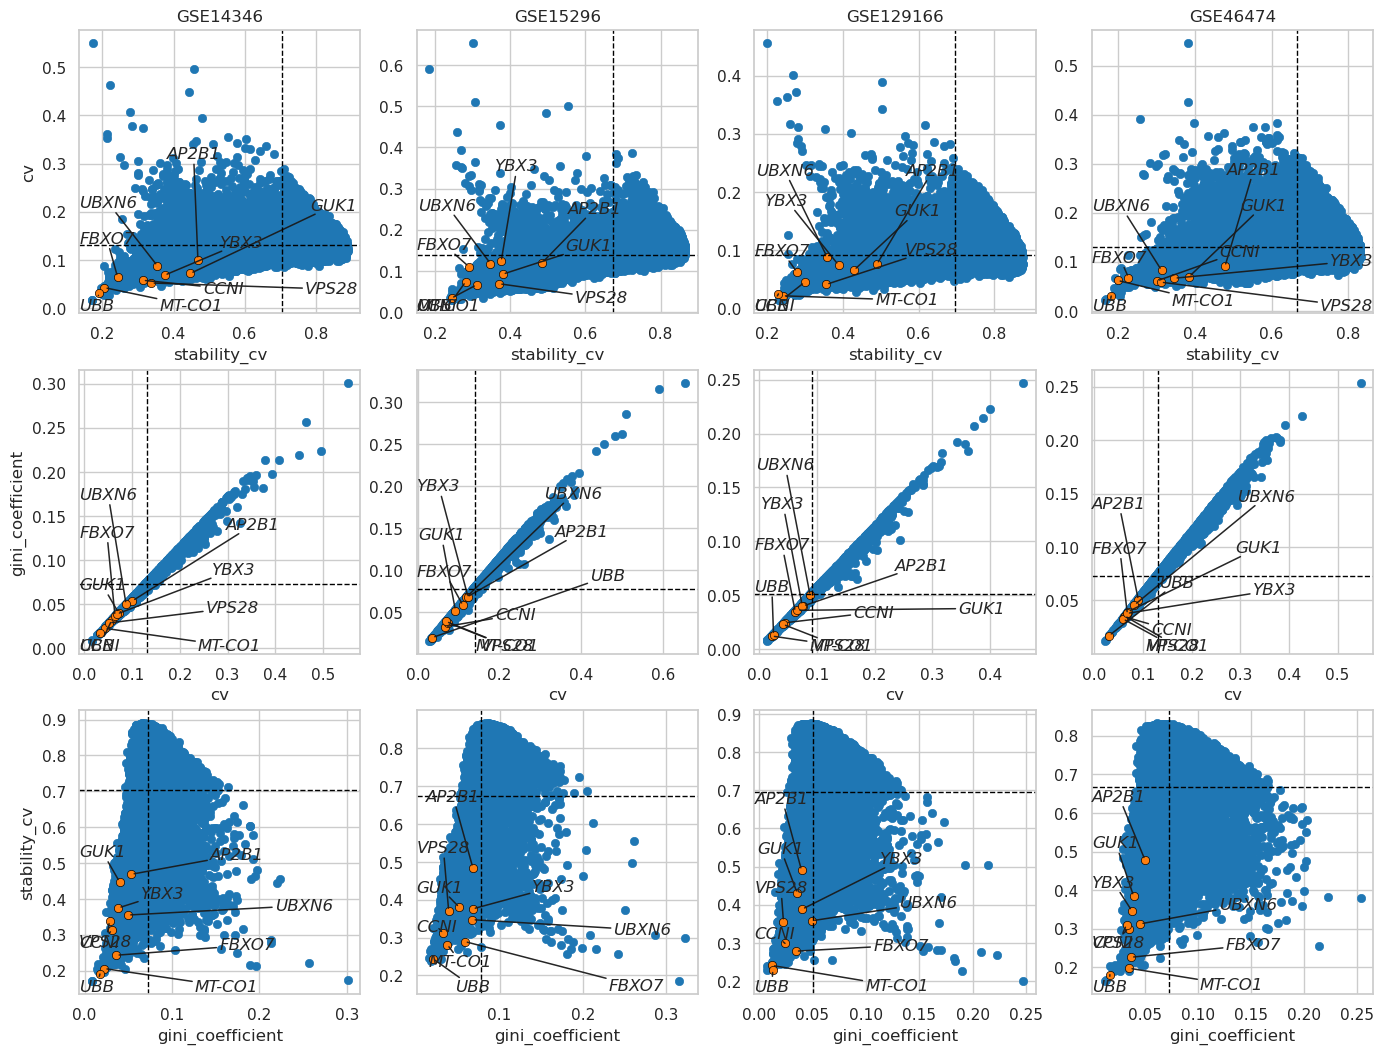

In [83]:
fig = plt.figure(figsize=(8.35*2,8.35*3/2))

x = ['stb_']*4 + ['cv_']*4 + ['gini_coefficient_']*4
y = ['cv_']*4 + ['gini_coefficient_']*4 + ['stb_']*4
# x = ['log_stb_']*4 + ['log_cv_']*4 + ['log_gini_coefficient_']*4
# y = ['log_cv_']*4 + ['log_gini_coefficient_']*4 + ['log_stb_']*4

nrow = 3
ncols = len(adata_ma.obs.gse.unique())

for i,gse in enumerate(adata_ma.obs.gse.unique().tolist()*nrow):
    ax = fig.add_subplot(nrow, ncols, i+1)
    aux = adata_ma.var
    sns.scatterplot(y=y[i]+gse, x=x[i]+gse, edgecolor=None, color='#1f77b4', data=aux.loc[[c for c in aux.index if c not in feats_3_ma ]])
    sns.scatterplot(y=y[i]+gse,x=x[i]+gse, edgecolor='black', color='#ff7f0e', data=aux.loc[feats_3_ma,:])
    ax.axhline(aux[y[i]+gse].median(), color='black', ls='--', lw=1)
    ax.axvline(aux[x[i]+gse].median(), color='black', ls='--', lw=1)
    if i in range(4):
        ax.set_title(gse)
    else:
        ax.set_title('')
    if i not in [0,4,8]:
        ax.set_ylabel('')
    else:
        ax.set_ylabel(y[i][:-1].replace('stb','stability_cv'))
    
    ax.set_xlabel(x[i][:-1].replace('stb','stability_cv'))
    
    texts = []
    for l,x_,y_ in aux.loc[feats_3_ma,[x[i]+gse, y[i]+gse]].reset_index().values:
        texts.append(ax.text(x_, y_, l,  va='center',ha='center', fontsize=12, style='italic'))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='k', lw=1.1, alpha=.95),
                expand=(2.5, 2.5),
               )

    # ax.set_xlim(xlim_list[i])
    # ax.set_ylim(ylim_list[i])
    # xlim_list.append(ax.get_xlim())
    # ylim_list.append(ax.get_ylim())

    # # ax.get_legend().remove()
    # ax.grid(False)
    # ax.spines[['left','right', 'top','bottom']].set_visible(False)
    # ax.set_yticklabels([])
    # ax.set_xticklabels([])
    # ax.set_xlabel('')
    # ax.set_ylabel('')
    # ax.set_title('')
    


    print(i, end=' ')
# fig.tight_layout()
fig.savefig('./draft/FIG3AL_MA_VALIDATION_HKG.pdf', format='pdf', dpi=300, bbox_inches='tight')
# fig.savefig('/mnt/d/housekeeping_genes/draft/MA_VALIDATION_v2.jpeg', format='jpeg', dpi=300)

## Entropy of cluster based on proposed Housekeeping genes

The ellipses are constructed based on code from matplotlib [website](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
]

In [84]:
# https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):    
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

## FIG 3M-P: Entropy by Kmeans clusters k=2

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f

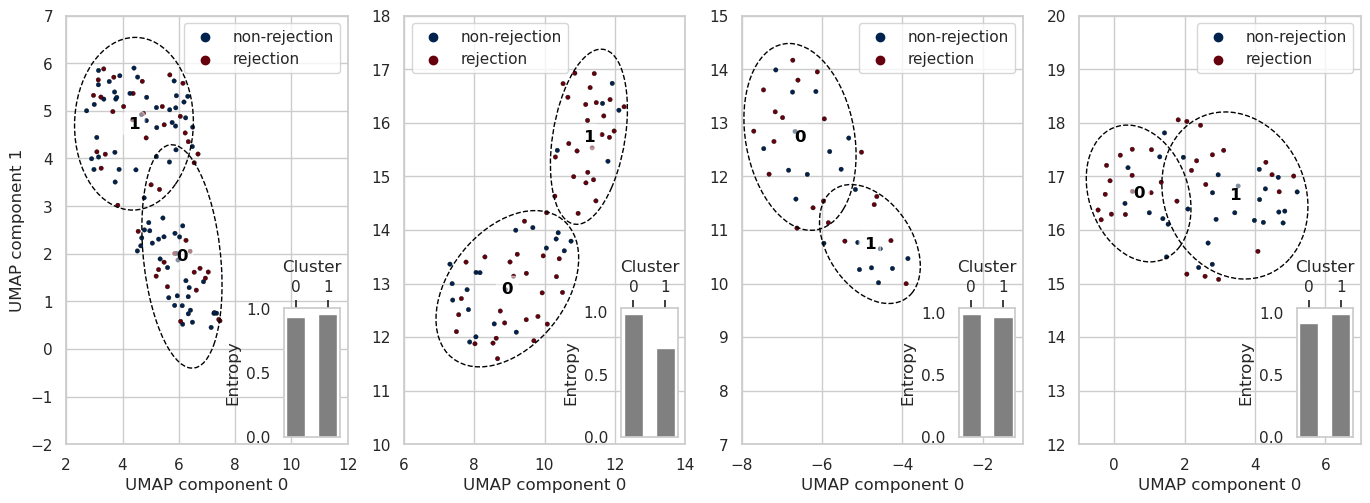

In [89]:
fig = plt.figure(figsize=(8.35*2,8.35*2/3))

xlim_list = [[2,12],[6,14],[-8,-1],[-1,7]]
ylim_list = [[-2,7],[10,18],[7,15],[12,20]]

colors = ['#00224e', '#67000d']

for i,g in enumerate(['GSE129166','GSE15296','GSE46474','GSE14346']):
    if i == 0:
        ax_pca = fig.add_subplot(1,4,1+i)
    else:
        ax_pca = fig.add_subplot(1,4,1+i)
        
    pca = umap.UMAP(n_neighbors=30, random_state=42)
    df_pca = StandardScaler().fit_transform(adata_ma[adata_ma.obs.gse==g, feats_3].to_df('trns_expr').values)

    ##
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(df_pca)
    labels = kmeans.labels_
    ##    

    df_pca = pd.DataFrame(pca.fit_transform(df_pca))
    df_pca.index = adata_ma[adata_ma.obs.gse==g, feats_3].obs.index
    df_pca['acr'] = adata_ma[adata_ma.obs.gse==g, feats_3].obs.ar# df_pca.index.map(dict(meta[g].acr))
    df_pca['clusters'] = labels
    x=0
    y=1
    hue='acr'
    hue_order = [0,1]
    sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, palette=colors,edgecolor='black', s=10, data=df_pca)
    ax_pca.set_ylim(ylim_list[i])
    ax_pca.set_xlim(xlim_list[i])
    handles, labels = ax_pca.get_legend_handles_labels()
    labels = ['non-rejection', 'rejection']
    ax_pca.legend(handles=handles, labels=labels, ncol=1)

    if i != 0:
        ax_pca.set_ylabel('')
    else:
        ax_pca.set_ylabel('UMAP component 1')

    ax_pca.set_xlabel('UMAP component 0')

    entropy_list = []
    cl_list = []
    texts= []
    
    for cl in np.sort(df_pca.clusters.unique()):
        confidence_ellipse(df_pca[df_pca.clusters==cl][0].values,
                       df_pca[df_pca.clusters==cl][1].values, ax_pca, edgecolor='black', ls='--', n_std=2)

        x, y = (df_pca[df_pca.clusters==cl][[0,1]].sum()/df_pca[df_pca.clusters==cl][[0,1]].shape[0]).values[:2]
        ax_pca.text(x, y, cl,  color='black',  weight='bold', va='center',ha='center',bbox=dict(boxstyle='round', facecolor='white', edgecolor=None, alpha=0.5))#

        entrp = np.round(entropy(np.unique(df_pca[df_pca.clusters==cl].acr.values, return_counts=True)[1]/np.unique(df_pca[df_pca.clusters==cl].acr.values,
                                                                                                                  return_counts=True)[1].sum(), base=2),2)
        entropy_list.append(entrp)
        cl_list.append(str(cl))

    
    width_bar=.6
    align = 'center'
    width="20%"
    height="30%"
    
    ax_com = inset_axes(ax_pca, width=width, height=height, loc=4)  

    ax_com.bar(x=cl_list, height=entropy_list,color='gray', width=width_bar, align=align)
    ax_com.set_ylabel('Entropy')#, fontsize=20)    
    ax_com.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax_com.set_title('Cluster')
    ax_com.set_yticks([0.0,.5,1.0],[0.0,.5,1.0])
    ax_com.set_yticklabels([0.0,.5,1.0])
    ax_com.grid(False)
        
fig.savefig('./draft/FIG3ML_microarray_entropy.pdf', format='pdf', dpi=300, bbox_inches='tight')

# GSEA enrichment analysis

In [95]:
import gseapy as gp
from gseapy import barplot, dotplot

In [106]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']
gene_list = adata.var.loc[genes,].sort_values('pool_cv').index.tolist()
gene_sets = ['GO_Molecular_Function_2023','GO_Biological_Process_2023']
background = adata.var.index.tolist()

In [107]:
enr = gp.enrichr(gene_list=gene_list+['COX1','COX-1'],
                 gene_sets=gene_sets,
                 organism='homo sapiens', 
                 outdir=None,
                 background=background,
                )

In [108]:
enr.results.to_csv('./draft/FIG4A_GSEA_enrichemnt_analysis.csv', index=0)

In [111]:
res = enr.results.copy()
res['qty_genes'] = res.Genes.str.split(';').apply(len)
res['GO'] = res.Term.str.split('(').str[-1].str.replace(')','', regex=False).values
res['Term_2'] = res.Term.str.split('(').str[0].values
res['-log10(p-adj)'] = -np.log10(res['Adjusted P-value'])

res = pd.concat([res[(res['P-value']<=0.05) & (res['Gene_set']=='GO_Molecular_Function_2023')].sort_values('P-value', ascending=True),
                 res[(res['P-value']<=0.05) & (res['Gene_set']=='GO_Biological_Process_2023')].sort_values('P-value', ascending=True).drop_duplicates(subset='Genes')])
res['Gene_set'] = res.Gene_set.map({'GO_Molecular_Function_2023':'GO MF','GO_Biological_Process_2023':'GO BP'})

res['Term_2'] = res.Term_2.str.replace('Kinase Activity', 'KA')
res['Term_2'] = res.Term_2.str.replace('Catabolic Process', 'CP')
res['Term_2'] = res.Term_2.str.replace('Metabolic Process', 'MP')
res['Term_2'] = res.Term_2.str.replace('Ligase Binding', 'LB')
res['Term_2'] = res.Term_2.str.replace('Regulation', 'Reg.')
res['Term_2'] = res.Term_2.str.replace('Cyclin-Dependent Protein Serine/Threonine Kinase Regulator Activity', 'Serine/Threonine KA Regulator')
res['Term_2'] = res.Term_2.str.replace('Positive Reg. Of Intrinsic Apoptotic Signaling Pathway By P53 Class Mediator ', 'Reg. Of Intrinsic Apoptotic Signaling')
res['Term_2'] = res.Term_2.str.replace('Reg. Of Plasma Membrane Bounded Cell Projection Organization', 'Reg. Of Plasma Membrane')
res['Term_2'] = res.Term_2.str.replace('Endosome Transport Via Multivesicular Body Sorting Pathway', 'Endosome Transport')

/tmp/ipykernel_17258/3271940133.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  res['Term_2'] = res.Term_2.str.replace('Positive Reg. Of Intrinsic Apoptotic Signaling Pathway By P53 Class Mediator ', 'Reg. Of Intrinsic Apoptotic Signaling')
/tmp/ipykernel_17258/3271940133.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  res['Term_2'] = res.Term_2.str.replace('Reg. Of Plasma Membrane Bounded Cell Projection Organization', 'Reg. Of Plasma Membrane')


## FIG 4A: Enrichment analysis

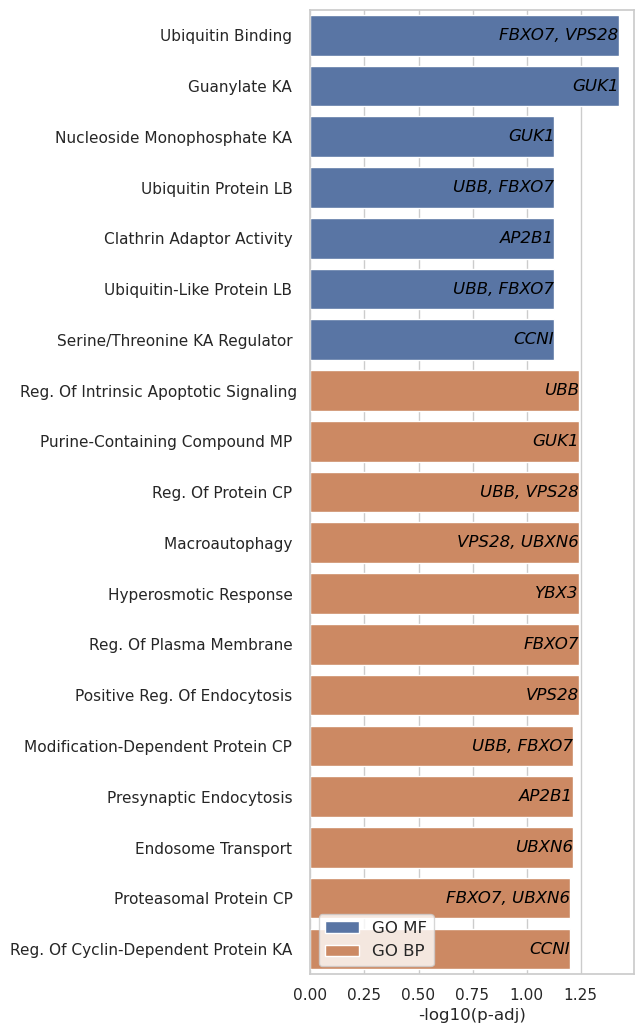

In [112]:
fig = plt.figure(figsize=(8.35*1/2,8.35*3/2))
ax = fig.add_subplot(111)

plots = sns.barplot(y='Term_2', x='-log10(p-adj)', hue='Gene_set', dodge=False, data=res, ax=ax)
ax.legend(loc='lower left', fontsize=12)

texts=[]
for y,x,l in res[['-log10(p-adj)','Genes']].reset_index(drop=True).reset_index().values:
    texts.append(ax.text(x,y,l.replace(';',', '), ha='right', va='center', color='black', fontsize=12, style='italic'))
ax.set_ylabel('')

# plt.tight_layout()
fig.savefig('./draft/FIG4A_GSEA_enrichemnt_analysis.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Orthology analaysis

We used datasets program from NCBI to dowload the sequences of HKG. Since MT-CO1 is not recognized by the database, we used the synonymous COX1.

In [113]:
from upsetplot import from_contents
from upsetplot import plot

## bash file to download files from orthology

In [70]:
#FILE ./ortholog_retrieve.sh
#!/bin/bash

# genes='AP2B1 CCNI FBXO7 GUK1 COX1 UBB UBXN6 VPS28 YBX3'
# path='./orthology/'
# for g in ${genes}; do
#     datasets download gene symbol ${g} --ortholog all
#     unzip ${path}ncbi_dataset.zip
#     mv ${path}ncbi_dataset ${path}${g}
# done

## Code to extarct all children tax_id from ortholog

In [114]:
orth_dict = {g:[] for g in genes}#os.listdir(path)}
orth_dict_c = dict()
path = './orthology/'
all_tax = set()
for g in genes:#os.listdir(path):
    with open(os.path.join(path+g+'/data/data_report.jsonl'), 'r') as f:
        for line in f:
            txn = eval(line)['taxId']
            if txn not in orth_dict[g]:
                orth_dict[g].append(txn)
                all_tax.update([txn])
    orth_dict_c[g] = len(orth_dict[g])

## bash file to get all tax_children

In [336]:
# I ran ./taxonomy_retrieve.sh to get tax_children
# print(' '.join(all_tax))

#!/bin/bash

# taxids='175797 34773 9483 109280 89462 173247 54380 8868 48193 194408 1234273 8524 40204 7938 59472 372321 9986 80427 90313 30522 59534 310571 59894 221976 1706337 61383 447135 9601 61156 441366 59463 386614 215358 8996 10141 2290929 38626 9157 188344 9708 31138 1094192 143292 214514 225400 8030 9657 27610 13397 9031 308060 9715 80972 10181 8023 244447 130825 9135 60746 7782 1002788 452646 54343 270530 8884 8036 81927 1884717 9694 68408 8017 1415580 9685 43346 37293 93934 286419 300417 13013 35019 90988 62283 9238 9531 9749 309878 51298 259920 30455 84834 32507 51853 202280 9838 575201 8081 9995 13735 100897 9423 89673 59729 8795 99487 889875 7955 8520 36176 38654 233779 9666 260615 75329 48699 723540 47969 303518 161584 9974 8345 9606 9054 77151 992332 8153 127582 27675 1230840 9103 8467 8267 79684 75038 9940 77932 77115 51337 48139 564181 7998 106734 9365 9565 8018 91951 93162 29139 336983 37032 9874 51338 9755 79690 48698 9541 48849 80966 34884 1047088 409849 279965 40151 143302 933632 8957 42254 72105 8663 9244 260995 56313 10090 8260 103695 55661 415023 8167 9690 109478 7888 52904 9994 9430 56716 9258 125878 43689 685728 28377 9886 300413 327740 73337 278164 2962859 175792 7830 202946 29064 148594 50402 146911 69293 170820 9823 13676 13616 296741 70543 7962 7753 32536 27706 460621 160734 101364 61452 8932 208062 9402 37040 48708 30464 9716 210632 451745 161448 159646 9711 30419 499056 2587831 8208 30427 9771 43700 546530 1914991 187106 345164 481883 27771 9796 9983 1868482 240206 75485 1608454 9627 27622 219594 106582 143291 8969 9999 7957 8384 9689 103944 30608 7950 194338 291302 161590 184585 9767 941984 9728 8845 8010 29144 443677 7936 9447 337641 147949 9590 82168 9600 586833 9172 10117 64144 9544 9555 8478 187451 90735 2489341 407982 321398 52239 176057 98922 13677 184440 369639 38775 9598 72004 9669 61221 9978 2857394 33562 94835 34839 495146 8019 7994 185453 2746895 1250792 1606681 10089 7897 109905 328815 109475 1142201 27606 9915 191870 1203425 9568 257877 9002 48701 54180 134902 109678 283035 10093 27697 2059687 9361 82655 35005 30331 649802 80720 75352 44398 10047 10036 74926 74940 87175 433684 9615 13146 30732 8128 57412 41426 60711 7906 299123 433405 9233 27679 205130 2546036 154827 9595 379532 482537 932674 181472 34886 8040 1042646 1825980 9160 27687 43150 46844 27794 1582913 50954 90069 2857398 114329 37181 187382 10029 28737 2871759 85066 8364 195615 1676925 181119 54383 7757 32473 1608482 1192867 38674 488313 9713 8032 8083 156563 8790 9731 8262 9643 9209 1574408 30538 164674 42636 65483 109293 307959 8240 8895 9597 10041 64668 7959 61621 415032 391180 8954 9720 76717 8469 89248 55291 161450 105255 48883 111838 61853 42100 693459 61384 9417 8078 229290 134920 198806 59861 13489 43179 28829 9742 33528 191477 8897 161453 137520 188132 29088 8673 33616 34880 30532 9470 37003 150288 293821 8090 9261 10116 113540 8005 417921 42410 375764 144197 127875 223781 119488 885580 8084 3053191 9913 884348 9515 1841481 13085 57421 52644 8154 491861 61388 90247 9837 186990 9704 27615 159077 9798 56723 678569 8049 97097 42526 8038 9305 10020 345155 31033 9644 441894 121530 230844 34816 132908 94885 63155 478635 9733 188379 356909 9017 39638 310915 129043 8839 52670 208333 109042 158456 36300 419612 3119969 2715852 9691 10160 241271 9662 261503 9371 175836 9117 57068 54374 7918 9739 8168 40690 8236 61622 44394 59479 8496 118200 30640 118141 128390 161592 35540 36723 95912 217509 35658 508554 591936 8177 3034132 494514 30410 9906 29078 8218 176946 9860 64176 7868 2939378 8355 161469 2991368 8502 94827 9793 257770 57397 8407 1196302 41447 66913 8187 175006 246437 42514 30611 161455 28743 9785 29073 100784 299321 81572 9337 8175 8103 105023 37029 120794 48891 29151 10129 286002 269649 1026970 8245 75366 9646 56733 8022 8255 84645 118797 390379 192404 9545 9407 415028 88082 158779 68294 7913 9925 8869 9696 110931'

# path='./orthology/tax_children/'
# for txid in ${taxids}; do
#     datasets download taxonomy taxon ${txid} --children
#     unzip ${path}ncbi_dataset.zip
#     mv ${path}ncbi_dataset ${path}${txid}
#     rm ${path}ncbi_dataset.zip README.md
# done

## Get information of Phylum, class, order, family, genus and species for each HKG

In [115]:
tx_phylum_dict = dict()
tx_class_dict = dict()
tx_order_dict = dict()
tx_family_dict = dict()
tx_genus_dict = dict()
tx_species_dict = dict()
not_found_dict = {t:[] for t in ['phylum','class','order','family','genus','species','not_in_all_tax']}
path = './orthology/tax_children/'
for tx in os.listdir(path):
    with open(os.path.join(path+tx+'/data/taxonomy_report.jsonl'), 'r') as f:
        txn = eval(f.readline().strip('\n').replace('true','"true"'))
        if 'phylum' in txn['taxonomy']['classification'].keys():
            tx_phylum_dict[tx] = txn['taxonomy']['classification']['phylum']['name']
        else:
            not_found_dict['phylum'].append(tx)
            
        if 'class' in txn['taxonomy']['classification'].keys():
            tx_class_dict[tx] = txn['taxonomy']['classification']['class']['name']
        else: 
            not_found_dict['class'].append(tx)
            
        if 'order' in txn['taxonomy']['classification'].keys():
            tx_order_dict[tx] = txn['taxonomy']['classification']['order']['name']
        else:
            not_found_dict['order'].append(tx)
            
        if 'family' in txn['taxonomy']['classification'].keys():
            tx_family_dict[tx] = txn['taxonomy']['classification']['family']['name']
        else:
            not_found_dict['family'].append(tx)

        if 'genus' in txn['taxonomy']['classification'].keys():
            tx_genus_dict[tx] = txn['taxonomy']['classification']['genus']['name']
        else:
            not_found_dict['genus'].append(tx)
            
        if 'species' in txn['taxonomy']['classification'].keys():
            tx_species_dict[tx] = txn['taxonomy']['classification']['species']['name']
        else:
            not_found_dict['species'].append(tx)

        if tx not in all_tax:
            not_found_dict['not_in_all_tax'].append(tx)

In [116]:
print('Total of phylum: ',set(tx_phylum_dict.values()))
print('Total of classes: ',len(set(tx_class_dict.values())),set(tx_class_dict.values()))
print('Total of order: ',len(set(tx_order_dict.values())))
print('Total of family: ',len(set(tx_family_dict.values())))
print('Total of genus: ',len(set(tx_genus_dict.values())))
print('Total of species: ',len(set(tx_species_dict.values())))

Total of phylum:  {'Chordata'}
Total of classes:  8 {'Actinopteri', 'Aves', 'Chondrichthyes', 'Lepidosauria', 'Hyperoartia', 'Amphibia', 'Cladistia', 'Mammalia'}
Total of order:  111
Total of family:  288
Total of genus:  500
Total of species:  630


## FIG S2: upsetplot for taxons.
Only well defined clade were considered

Total of classes:  8


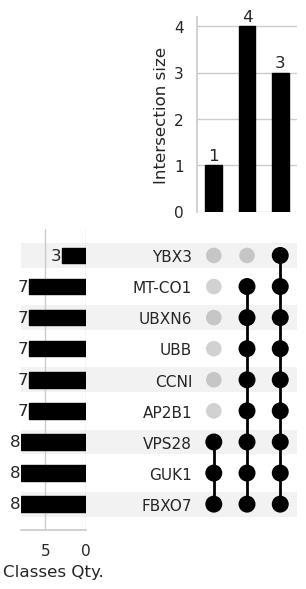

In [122]:
fig = plt.figure(figsize=(8.35*3/2, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_class_dict[tx] for tx in orth_dict[k] if tx in tx_class_dict.keys()]))
print('Total of classes: ',len(set(tx_class_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True, fig=fig)#, facecolor="darkblue")
up['totals'].set_xlabel("Classes Qty.")
# plt.show()
fig.savefig('./draft/FIGS2A_orthologous_class.pdf', bbox_inches='tight', format='pdf', dpi=300)

Total of orders:  111


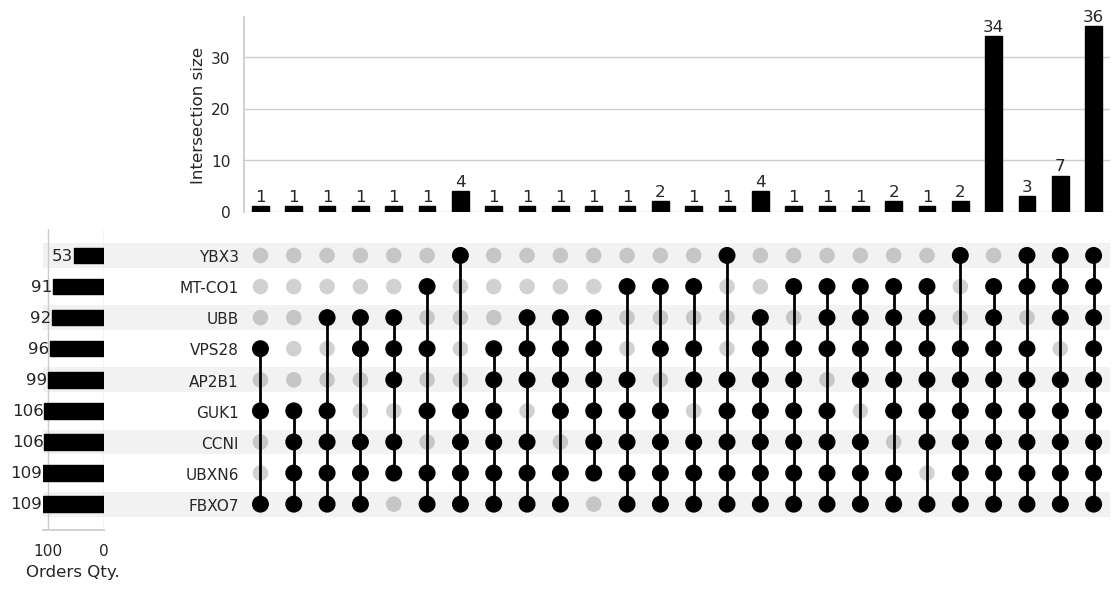

In [123]:
fig = plt.figure(figsize=(8.35*3/2, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_order_dict[tx] for tx in orth_dict[k] if tx in tx_order_dict.keys()]))
print('Total of orders: ',len(set(tx_order_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True, fig=fig)#, facecolor="darkblue")
up['totals'].set_xlabel("Orders Qty.")
# plt.show()
fig.savefig('./draft/FIGS2B_orthologous_order.pdf', bbox_inches='tight', format='pdf', dpi=300)

Total of families:  288


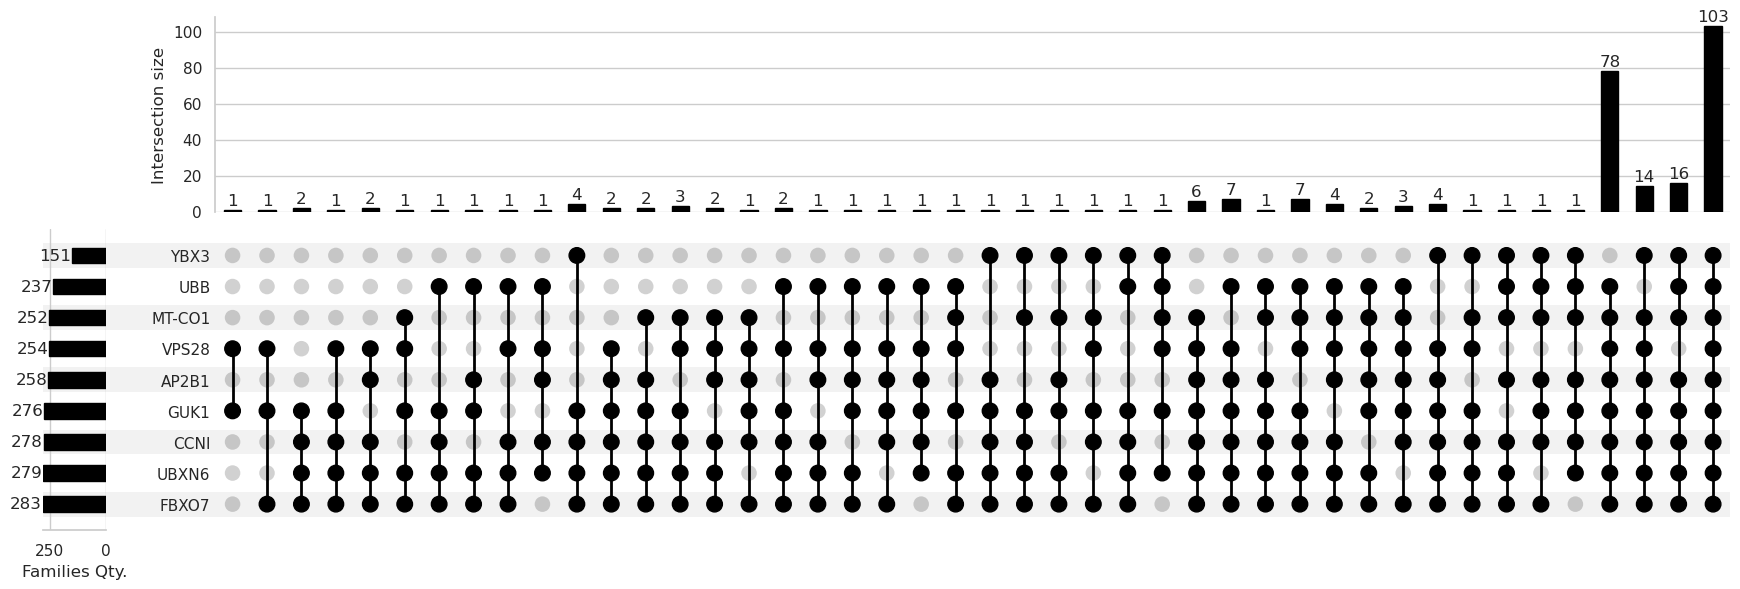

In [125]:
fig = plt.figure(figsize=(8.35*2, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_family_dict[tx] for tx in orth_dict[k] if tx in tx_family_dict.keys()]))
print('Total of families: ',len(set(tx_family_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True, fig=fig)#, min_subset_size=2)#, facecolor="darkblue")
up['totals'].set_xlabel("Families Qty.")
# plt.show()
fig.savefig('./draft/FIGS2C_orthologous_family.pdf', bbox_inches='tight', format='pdf', dpi=300)

Total of genus:  500


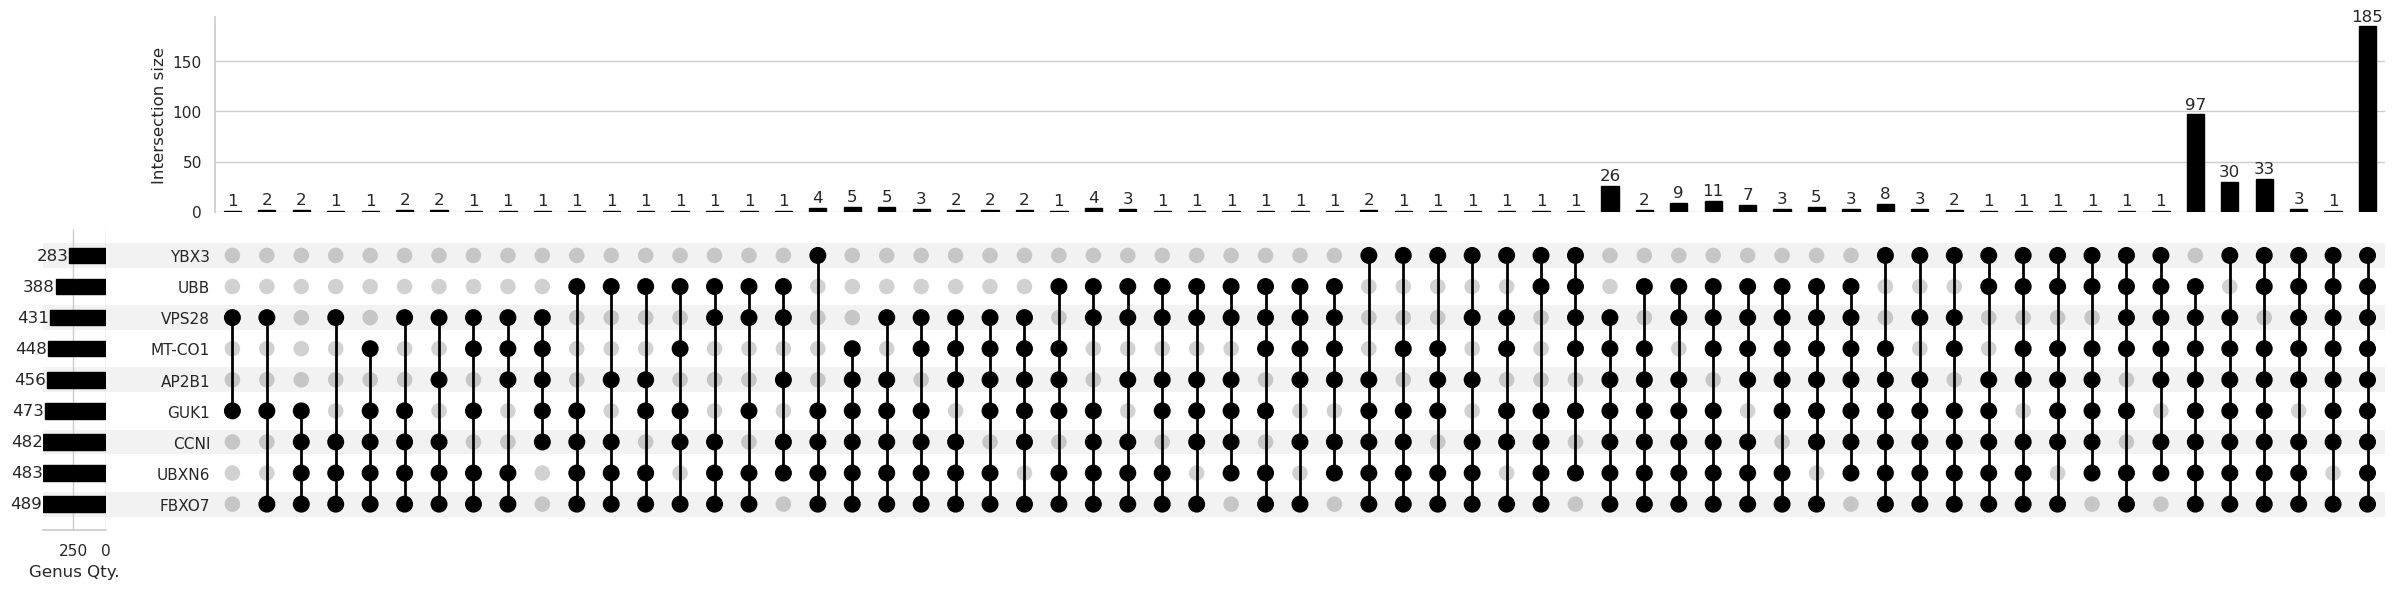

In [126]:
fig = plt.figure(figsize=(8.35*3, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_genus_dict[tx] for tx in orth_dict[k] if tx in tx_genus_dict.keys()]))
print('Total of genus: ',len(set(tx_genus_dict.values())))
orth_genes = from_contents(orth_dict_aux)
up = plot(orth_genes, orientation="horizontal", show_counts=True, fig=fig)#, min_subset_size=3)#, facecolor="darkblue")
up['totals'].set_xlabel("Genus Qty.")
# plt.show()
fig.savefig('./draft/FIGS2D_orthologous_genus.pdf', bbox_inches='tight', format='pdf', dpi=300)

Total of species:  630


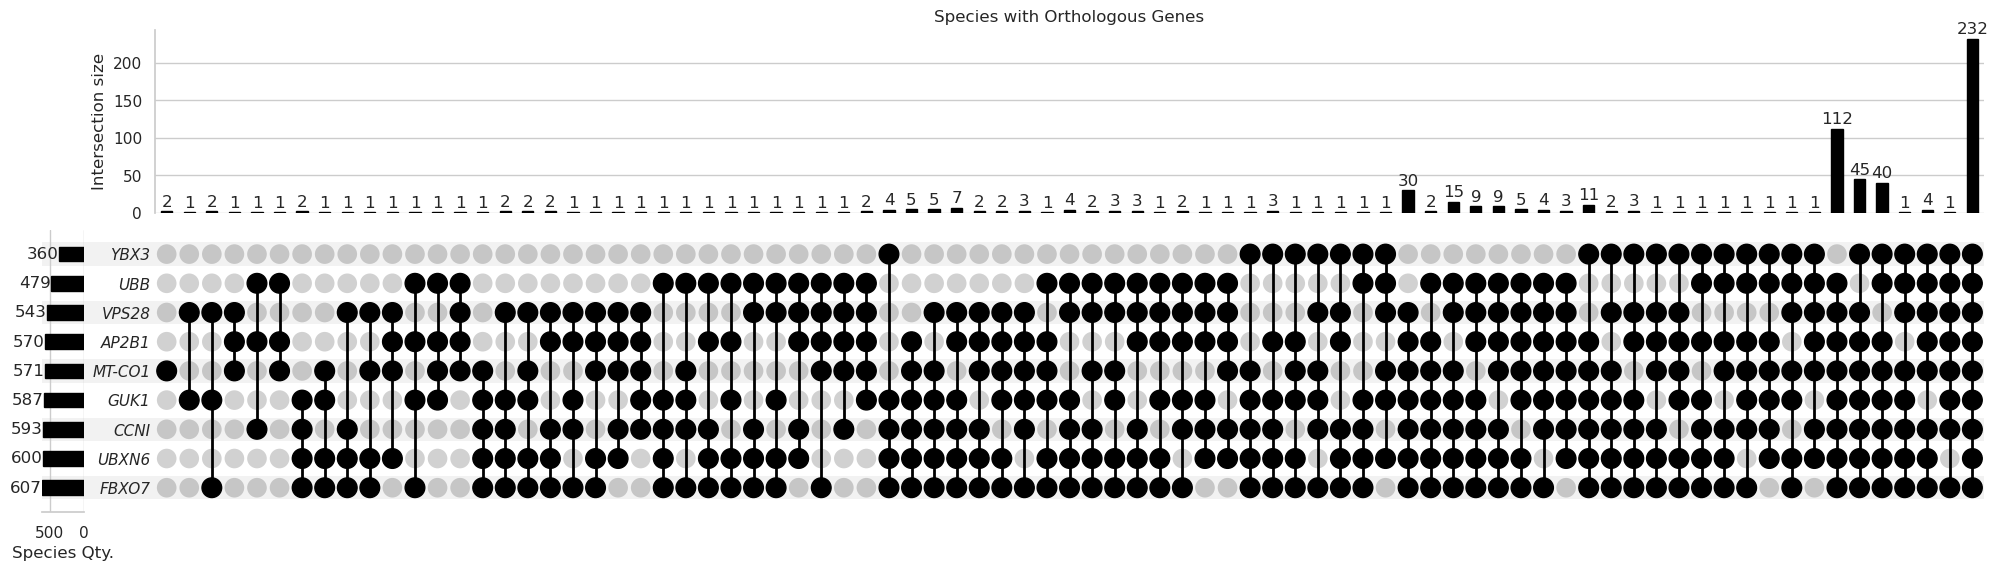

In [130]:
fig = plt.figure(figsize=(8.35*3, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_species_dict[tx] for tx in orth_dict[k] if tx in tx_species_dict.keys()]))
print('Total of species: ',len(set(tx_species_dict.values())))
orth_genes = from_contents(orth_dict_aux)
# up = plot(orth_genes, orientation="horizontal", show_counts=True, min_degree=7, element_size=30, totals_plot_elements=4)#, min_subset_size=3)#, facecolor="darkblue")fig=fig
up = plot(orth_genes, orientation="horizontal", show_counts=True, show_percentages=False,  fig=fig, element_size=None)
up['totals'].set_xlabel("Species Qty.")
up['intersections'].set_title("Species with Orthologous Genes")
for lbl in up['matrix'].get_yticklabels():
    lbl.set_style('italic')
# plt.show()
fig.savefig('./draft/FIGS2E_orthologous_species.pdf', bbox_inches='tight', format='pdf', dpi=300)

## FIG 4B: orthologues sharing at least 7 genes

Total of species:  630


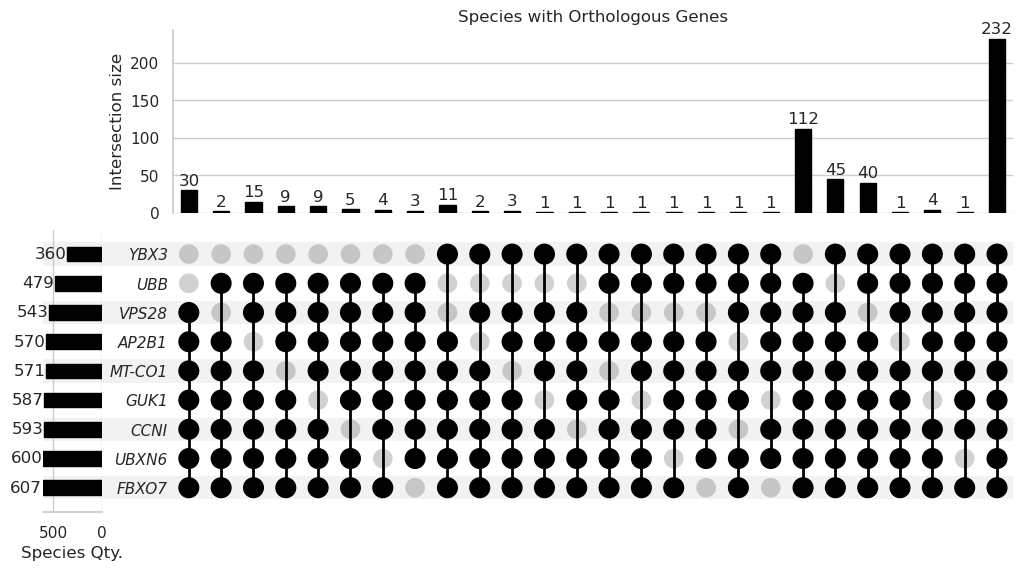

In [131]:
fig = plt.figure(figsize=(8.35*3/2, 8.35*3/4))
orth_dict_aux = dict()
for k in orth_dict.keys():
    orth_dict_aux[k] = list(set([tx_species_dict[tx] for tx in orth_dict[k] if tx in tx_species_dict.keys()]))
print('Total of species: ',len(set(tx_species_dict.values())))
orth_genes = from_contents(orth_dict_aux)
# up = plot(orth_genes, orientation="horizontal", show_counts=True, min_degree=7, element_size=30, totals_plot_elements=4)#, min_subset_size=3)#, facecolor="darkblue")fig=fig
up = plot(orth_genes, orientation="horizontal", show_counts=True, show_percentages=False, min_degree=7,  fig=fig, element_size=None)
up['totals'].set_xlabel("Species Qty.")
up['intersections'].set_title("Species with Orthologous Genes")
for lbl in up['matrix'].get_yticklabels():
    lbl.set_style('italic')
# plt.show()
fig.savefig('./draft/FIG4B_orthologous.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [132]:
print('At least 8 genes: ', 232+1+4+1+40+45+112)
print('At least 7 genes: ', 232+1+4+1+40+45+112+8*1+3+2+11+3+4+5+9+9+15+2+30)

At least 8 genes:  435
At least 7 genes:  536


In [133]:
# Gens present in Homo Sapiens
orth_genes.reset_index().set_index('id').sum(axis=1)['Homo sapiens']

9

## Preparing sequences to align. We considered only the first isoform of each sequence

In [134]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']#'COX1']
genes

['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [135]:
path = './orthology/'
for g in genes:
    flag = False
    header_aux = ['','','']
    with open(os.path.join(path,g,'data/protein.faa'), 'r') as fastaobject:
        txt = ''
        for line in fastaobject:
            if line.startswith('>'):
                line = line.replace('isoform=a','isoform=X1')
                line = line.replace('isoform=1 precursor','isoform=X1') #problem with COX1 header for Homo sapiens
                line = line.replace('isoform=1','isoform=X1')                
            if line.startswith('>') and (header_aux[2] != line.split(' ')[2]) and (('[isoform=X1]' in  line) or (not '[isoform' in line)):
                txt += line
                flag = True
                header_aux = line.split(' ')
            elif (not line.startswith('>')) and flag:
                txt += line
            else:
                flag = False
    with open(os.path.join(path,g,'data/one_seq_protein.faa'), 'w') as new_fastaobject:
        new_fastaobject.write(txt)

    print(g, end=' ')

AP2B1 CCNI FBXO7 GUK1 UBB UBXN6 VPS28 YBX3 MT-CO1 

## Run Clustal Omega to align orthologues

In [136]:
import subprocess

In [137]:
path = './orthology/'

In [138]:
# for g in genes:
#     subprocess.call(['clustalo', '-i', os.path.join(path,g,'data/one_seq_rna.fna'),
#                      '-o', os.path.join(path,g,'data/one_seq_rna.afa'),
#                      '-t', 'DNA'], cwd='./',stdout=subprocess.PIPE)
#     print(g, end=' ')

# for g in ['COX1']:#genes:
#     subprocess.call(['clustalo', '-i', os.path.join(path,g,'data/one_seq_protein.faa'),
#                      '-o', os.path.join(path,g,'data/one_seq_protein.afa'),
#                      '-t', 'Protein', '--force'], cwd='./',stdout=subprocess.PIPE)
#     print(g, end=' ')

## Orthology entropy distribution

### get motifs code on [CDD](https://www.ncbi.nlm.nih.gov/cdd)

In [139]:
from scipy.stats import entropy
from Bio.Seq import Seq
from Bio import motifs
from Bio import AlignIO

In [140]:
def get_aln_pos(aln, seq_pos):
    aln_pos = []
    a_pos = 0
    hs_idx = 0
    for aa in aln:
        if 'organism=Homo sapiens' in aa.description:
            break
        hs_idx +=1
        
    for i,aa in enumerate(aln.alignment[hs_idx]):
        if aa != '-':
            a_pos += 1
        if a_pos in seq_pos:
            aln_pos.append(i)
            a_pos += 1
    return np.array(aln_pos).reshape(-1,2)

## FIG 4C: Entropy of conserved positions

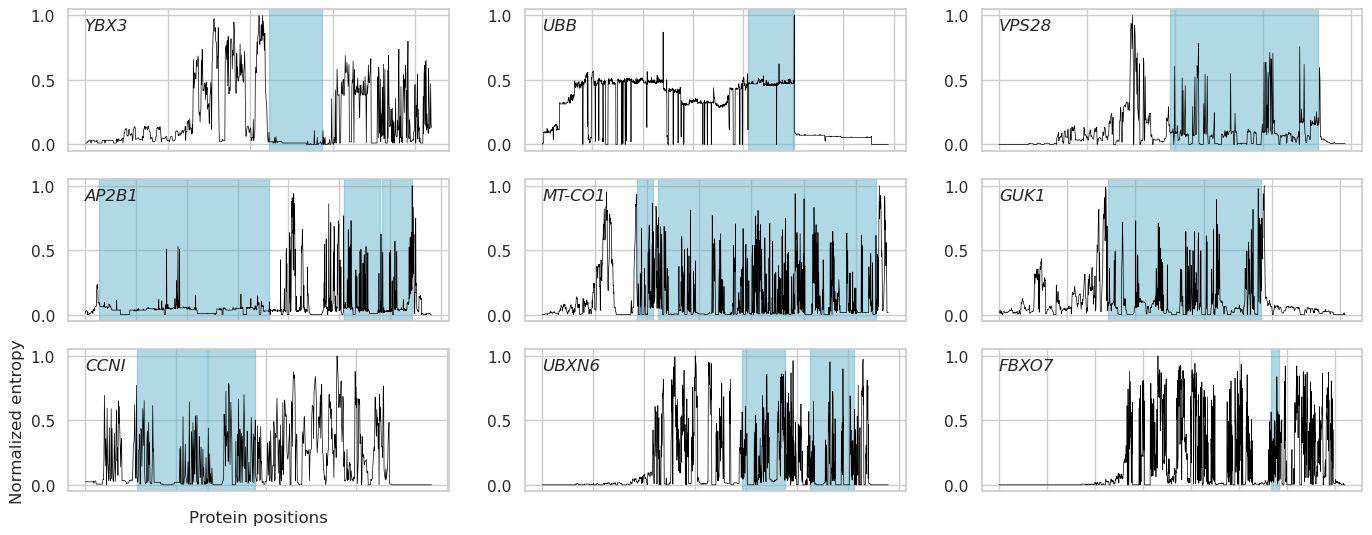

In [142]:
fig = plt.figure(figsize=(8.35*2,8.35*3/4))
path = './orthology/'
# for i,f in enumerate([f for f in os.listdir(path) if f.endswith('.afa')]):
for i,g in enumerate(['YBX3', 'UBB', 'VPS28', 'AP2B1', 'MT-CO1', 'GUK1', 'CCNI', 'UBXN6', 'FBXO7']):
    if i == 0:
        ax=fig.add_subplot(3,3,1+i)
    else:
        ax=fig.add_subplot(3,3,1+i, sharey=ax)

    fasta = os.path.join(path,g,'data/one_seq_protein.afa')
    alignment = AlignIO.read(os.path.join(path,g,'data/one_seq_protein.afa'), 'fasta')

    df = pd.DataFrame([aln.seq for aln in alignment], index=[aln.id for aln in alignment])
    entropy_list = []
    for c in df.columns:
        entropy_list.append(entropy(np.unique(df.loc[:,c], return_counts=True)[1]/np.unique(df.loc[:,c], return_counts=True)[1].sum(), base=2))
    entropy_list = np.array(entropy_list).reshape(-1, 1)
    entropy_list = MinMaxScaler().fit_transform(entropy_list).reshape( len(df.columns) )
    
    ax.plot(range(len(entropy_list)), entropy_list, lw=.5, color='black')
    ax.set_title('')#g.upper(), style='italic')
    ax.set_xticklabels([])
    if i in [6]:
        ax.set_ylabel('Normalized entropy')
    else:
        ax.set_ylabel('')
    if i in [6]:
        ax.set_xlabel('Protein positions')
    else:
        ax.set_xlabel('')

    ax.text(-.5, .89, g, fontdict={'style':'italic'})#, bbox=dict(fc="white", ec='white', lw=.5,alpha=.25))

    if g == 'AP2B1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [11, 534, 731, 831, 840, 950])]
    elif g == 'CCNI':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [44, 142, 146, 218])]
    elif g == 'FBXO7':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [332, 376])]
    elif g == 'GUK1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [26, 208])]
    elif g == 'UBB':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [1, 228])]
    elif g == 'UBXN6':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [158, 263, 336, 409])]
    elif g == 'VPS28':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [39, 219])]
    elif g == 'YBX3':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [91, 160])]
    elif g == 'MT-CO1':
        [ax.axvspan(i, j, alpha=0.5, color='c') for i,j in get_aln_pos(alignment, [32, 69, 89, 575])]
        
# fig.tight_layout()
fig.savefig(fname='./draft/FIG4C_entropy_conservative_sites_v2.pdf', bbox_inches='tight', format='pdf', dpi=300)
# fig.savefig(**{'fname':'./housekeeping_genes/draft/FIG4C_entropy_conservative_sites_v2.pdf', 'bbox_inches':'tight','format':'pdf', 'dpi':300})

- **AP2B1:**
    - 11-534 aa pfam01602 Adaptin_N: Adaptin N terminal region -> Clathrin Adaptor Activity: This family consists of the N terminal region of various alpha, beta and gamma subunits of the AP-1, AP-2 and AP-3 adaptor protein complexes. The adaptor protein (AP) complexes are involved in the formation of clathrin-coated pits and vesicles [1]. The N-terminal region of the various adaptor proteins (APs) is constant by comparison to the C-terminal which is variable within members of the AP-2 family[2]; and it has been proposed that this constant region interacts with another uniform component of the coated vesicles [2]. [link](https://www.ebi.ac.uk/interpro/entry/pfam/PF01602/)
    - 731-831 aa 
smart0080 
Alpha_adaptinC2: Adaptin C-terminal doma: 
Adaptins are components of the adaptor complexes which link clathrin to receptors in coated vesicles. Clathrin-associated protein complexes are believed to interact wit  the cytoplasmic tails of membrane proteins, leading to their selection and concentration. Gamma-adaptin is a subunit of the golgi adaptor. Alpha adaptin is a heterotetramer tha  regulates clathrin-bud formation. The carboxyl-terminal appendage of the alpha subunit regulates translocation of endocytic accessory proteins to the bud site. This Ig-fold domain i  found in alpha, beta and gamma adaptins and consists of a beta-sandwich containing 7 strands in 2 beta-sheets in a greek-key topology.. The adaptor appendage contains an additional  -terminal strand [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=smart00809).
    - 840-950 aa 
smart0102 
B2-adapt-app_C: Beta2-adaptin appendage, C-terminal sub-dom: Members of this family adopt a structure consisting of a 5 stranded beta-sheet, flanked by one alpha helix on the outer side, and by two alpha helices on the inner side. This domain is required for binding to clathrin, and its subsequent polymerisation. Furthermore, a hydrophobic patch present in the domain also binds to a subset of D-phi-F/W motif-containing proteins that are bound by the alpha-adaptin appendage domain.  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=smart01020).ainin

- **CCNI:**
    - 44-142 aa 
cd2052 
CYCLIN_CCNI-like: cyclin box found in cyclin-I (CCNI) and similar protei. CCNI is an atypical cyclin because it is most abundant in post-mitotic cells. It is involved in various biological processes, such as cell survival, angiogenesis, cell differentiation, and cell cycle progression. CCNI contains a typical cyclin box near the N-terminus and a PEST sequence near the C-terminus. The cyclin box is a protein binding domain. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd20526)
    - 146-218 aa 
cl4045 
CYCLIN_SF: Cyclin box fold superfami. The cyclin box is a protein binding domain that functions in cell-cycle and transcriptional control. It is about 100 amino acids in length, composed of five helices, and is present in cyclins, transcription initiation factor IIB (TFIIB), and retinoblastoma tumour suppressor protein (Rb). Cyclins consist of 8 classes of cell cycle regulators that function as regulatory subunits of cyclin-dependent kinases (CDKs), which are serine/threonine kinases. The catalytic activities of CDKs are modulated not only by their interactions with cyclins but also by CDK inhibitors (CKIs). CDKs, cyclins and CKIs play key roles in transcription, epigenetic regulation, metabolism, stem cell self-renewal, neuronal functions, and spermatogenesis. TFIIB is a transcription factor that binds the TATA box. Members in this superfamily contain one or two copies of the cyclin box. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cl40454)lyns

- **FBXO7:**
    - 332-376 aa FBXO7, also called FBX7, is the substrate-recognition component of an SCF (SKP1-CUL1-F-box protein) E3 ubiquitin-protein ligase complex which mediates the ubiquitination and subsequent proteasomal degradation of target proteins. It recognizes BIRC2 and DLGAP5. FBXO7 plays a role downstream of PINK1 in the clearance of damaged mitochondria via selective autophagy (mitophagy) by targeting PRKN to dysfunctional depolarized mitochondria. It promotes MFN1 ubiquitination. FBXO7 acts as a cell cycle regulator by enhancing cyclin D/cyclin-dependent kinase 6 (Cdk6) complex formation and stabilizing levels of p27, a cyclin-dependent kinase inhibitor. Mutations in the FBXO7 (PARK15) gene have been implicated in a juvenile form of parkinsonism called parkinsonian pyramidal syndrome (PPS), characterized by Parkinsonian symptoms and pyramidal tract signs. The F-box domain has a role in mediating protein-protein interactions in a variety of contexts, such as polyubiquitination, transcription elongation, centromere binding and translational repression. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=438859)

- **GUK1:**
    - 26-208 aa 
TIGR0326 
guanyl_kin: guanylate kina. Members of this family are the enzyme guanylate kinase, also called GMP kinase. This enzyme transfers a phosphate from ATP to GMP, yielding ADP and GDP. (Purines, pyrimidines, nucleosides, and nucleotides, Nucleotide and nucleoside interconversions) [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=TIGR03263)se

- **UBB:**
    - 1-76 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. Ubiquitin is a protein modifier in eukaryotes that is involved in various cellular processes, including transcriptional regulation, cell cycle control, and DNA repair. Ubiquitination is comprised of a cascade of E1, E2 and E3 enzymes that results in a covalent bond between the C-terminus of ubiquitin and the epsilon-amino group of a substrate lysine. Ubiquitin-like (Ubl) proteins have similar ubiquitin beta-grasp fold and attach to other proteins in a Ubl manner but with biochemically distinct roles. Ubiquitin (Ub)and Ubl proteins conjugate and deconjugate via ligases and peptidases to covalently modify target polypeptides. Ub includes Ubq/RPL40e and Ubq/RPS27a fusions as well as homopolymeric multiubiquitin protein chains. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd01803)
    - 77-152 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. "
    - 153-228 aa 
cd0180 
Ubl_ubiquitin: ubiquitin-like (Ubl) domain found in ubiquit. "ininin

- **UBXN6:**
    - 158-263 aa 
cd1046 
PUB_UBXD1: PNGase/UBA or UBX (PUB) domain of UBX. This PUB domain is found in p97 adaptor protein UBXD1 (UBX domain-containing protein 1, also called UBXD6). It functions as a p97 (also known as valosin-containing protein or VCP) adaptor by interacting with the D1 and/or D2 ATPase domains. The type II AAA+ ATPase p97 is involved in a variety of cellular processes such as the deglycosylation of ERAD substrates, membrane fusion, transcription factor activation and cell cycle regulation through differential binding to specific adaptor proteins. The PUB domain in UBX-domain protein 1 (UBXD1), which is widely expressed in higher eukaryotes, except for fungi, and which is involved in substrate recruitment to p97, interacts strongly with the C-terminus of p97. UBXD1 also interacts with HRD1 and HERP, both components of the ERAD pathway, via p97. It is possibly involved in aggresome formation; aggresomes are perinuclear compartments that contain misfolded proteins colocalized with centrosome markers.[link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd10460)
    - 336-409 aa 
cd1611 
UBX_UBXN6: Ubiquitin regulatory domain X (UBX) found in UBX domain protein 6 (UBXN6) and similar protei. UBXN6, also termed UBX domain-containing protein 1 (UBXD1), and UBXDC2, belongs to the UBXD family of proteins that contains the ubiquitin regulatory domain X (UBX) with a beta-grasp ubiquitin-like fold, but without the C-terminal double glycine motif. UBX domain is typically located at the carboxyl terminus of proteins, and participates broadly in the regulation of protein degradation. UBXN6 acts as a cofactor of p97 (also known as VCP or Cdc48), which is a homohexameric AAA ATPase (ATPase associated with a variety of activities) involved in a variety of functions ranging from cell-cycle regulation to membrane fusion and protein degradation. Unlike other p97 cofactors that binds the N-domain of p97 through their UBX domain, UBXN6 binds p97 in two regions, at the p97 C terminus via a PUB domain and at the p97 N-domain with a short linear interaction motif termed VIM. Its UBX domain is not functional for the binding of p97. The UBXN6-p97 complex regulates the endolysosomal sorting of ubiquitylated plasma membrane protein caveolin-1 (CAV1), as well as the trafficking of ERGIC-53-containing vesicles by controlling the interaction of transport factors with the cytoplasmic tail of ERGIC-53. In addition, UBXN6 is a regulatory component of endoplasmic reticulum-associated degradation (ERAD) that may modulate the adaptor binding to p97. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd16119)nsD1

- **VPS28:**
    - 39-219 aa 
pfam0399 
VPS28: VPS28 prote. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=pfam03997)in

- **YBX3:**
    - 91-160 aa 
pfam0031 
CSD: 'Cold-shock' DNA-binding doma. [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=pfam00313)in

- **MT-CO1 (COX1)**:
    - 32-69 aa 
cd0005 
EGF_CA: Calcium-binding EGF-like domain, present in a large number of membrane-bound and extracellular (mostly anima proteins. Calcium-binding EGF-like domain, present in a large number of membrane-bound and extracellular (mostly animal) proteins. Many of these proteins require calcium for their biological function and calcium-binding sites have been found to be located at the N-terminus of particular EGF-like domains; calcium-binding may be crucial for numerous protein-protein interactions. Six conserved core cysteines form three disulfide bridges as in non calcium-binding EGF domains, whose structures are very similar. EGF_CA can be found in tandem repeat arrangements  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00054).
    - 89-575 aa 
cd0981 
prostaglandin_endoperoxide_synthase: Animal prostaglandin endoperoxide synthase and related bacterial protei. Animal prostaglandin endoperoxide synthase and related bacterial proteins. 
Animal prostaglandin endoperoxide synthases, including prostaglandin H2 synthase and a set of similar bacterial proteins which may function as cyclooxygenases. Prostaglandin H2 synthase catalyzes the synthesis of prostaglandin H2 from arachidonic acid. In two reaction steps, arachidonic acid is converted to Prostaglandin G2, a peroxide (cyclooxygenase activity) and subsequently converted to the end product via the enzyme's peroxidase activity. Prostaglandin H2 synthase is the target of aspirin and other non-steroid anti-inflammatory drugs such as ibuprofen, which block the substrate's access to the active site and may acetylate a conserved serine residue. In humans and other mammals, prostaglandin H2 synthase (PGHS), also called cyclooxygenase (COX) is present as at least two isozymes, PGHS-1 (or COX-1) and PGHS-2 (or COX-2), respectively. PGHS-1 is expressed constitutively in most mammalian cells, while the expression of PGHS-2 is induced via inflammation response in endothelial cells, activated macrophages, and others. COX-3 is a splice variant of COX-1  [link](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd09816).nsns

# Find biomarkers in
RNA-SEQ GSE175718

## Read adata with all genes

We keep only genes that are in microarray as well. So we can test the model in this kind of data

In [143]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']

In [144]:
df_gens = pd.read_csv('./Microarray_RNAseq_mygene_translation.csv', index_col=0, header=None, names=['GeneNames','TranslationStatus'])

df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'GeneNames'] = 'MT-CO1'
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'GeneNames'] = 'UBXN6'
df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'TranslationStatus'] = 'ok'

In [145]:
adata_ml = ad.read_h5ad('./adata_RNAseq_louvain.h5ad')

# Keep only samples from study GSE175718
# Keep genes present on Macroarray datasets
adata_ml = adata_ml[adata_ml.obs.gse=='GSE175718',
                    adata_ml.var.index.isin(df_gens[df_gens.TranslationStatus=='ok'].GeneNames.unique())]

# Rename housekeeping genes from equivalent vs non_equivalent
adata_ml.var['equivalent'] = adata_ml.var.equivalent.astype(str)
adata_ml.var.loc[genes, 'equivalent'] = 'housekeeping_genes'
adata_ml.var['equivalent'] = adata_ml.var.equivalent.astype('category')

adata_ml

/tmp/ipykernel_17258/2276922270.py:9: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_ml.var['equivalent'] = adata_ml.var.equivalent.astype(str)


AnnData object with n_obs × n_vars = 384 × 20147
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

# Machine learning modeling

In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV , cross_validate, KFold, ShuffleSplit, GroupKFold, LeaveOneOut, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline

import hdbscan

In [147]:
# Markers from paper of this dataset
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']
gn = np.where(adata_ml.var.index.isin(mkr))[0]

## Detect outliers with HDBSCAN

Detec outliers to exclude them from the traning-testing process. this algorithm flag outliers with -1

In [148]:
ol_detection = hdbscan.HDBSCAN().fit(adata_ml.X)
print(np.unique(ol_detection.labels_, return_counts=True))
adata_ml.obs.loc[:,'outliers_hdbscan'] = ol_detection.labels_

(array([-1,  0,  1]), array([  5, 351,  28]))


We excluded SRR14675592 because it is only zeros for hkg

In [149]:
adata_ml[adata_ml.obs.index=='SRR14675592', gn].X

ArrayView([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [150]:
adata_ml.obs.loc[adata_ml.obs.index=='SRR14675592','outliers_hdbscan'] = -1

In [151]:
adata_ml.obs.groupby('outliers_hdbscan').count()

abmrh  tcmr   ar  gse  gse_time  gse_patient  louvain_group  \
outliers_hdbscan                                                                
-1                    6     6    6    6         6            6              6   
 0                  351   351  351  351       351          351            351   
 1                   27    27   27   27        27           27             27   

                  UMAP_1  UMAP_2  
outliers_hdbscan                  
-1                     6       6  
 0                   351     351  
 1                    27      27

## Excluding outliers

In total 6 sampels were excluded from the samples.

In [152]:
adata_ml = adata_ml[adata_ml.obs.outliers_hdbscan!=-1]

## Calculate regular normalization methods (TMM, MRN, TPM)

We calculated the TMM and MRN after excluding outlier samples.

### Normalization by MRN

In [153]:
adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'MRN'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})
trns_dict = dict(adata_ml.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata_ml, layer='count', groups_col='gse', trns_dict=trns_dict)
adata_ml.layers['MRN'] = adata_ml.layers['trns_expr']

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


### Normalization by TMM

In [154]:
adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'TMM'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})
trns_dict = dict(adata_ml.obs[['gse','type']].values)
hkg.pp.transform_exprs(adata_ml, layer='count', groups_col='gse', trns_dict=trns_dict)
adata_ml.layers['TMM'] = adata_ml.layers['trns_expr']

/tmp/ipykernel_17258/2045834543.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata_ml.obs.loc[:,'type'] = adata_ml.obs.gse.map({'GSE175718': 'TMM'})#, 'GSE120649':'MRN', 'GSE112927':'MRN', 'GSE86884':'MRN'})


### Normalization of TMM to log(TMM) using arcsinh transformation

In [155]:
hkg.pp.log_transform(adata_ml, layer=None, method='arcsinh')

# TPM
adata_ml.layers['TPM'] = adata_ml.X

# TMM + 1
adata_ml.layers['TPM1p'] = 1 + adata_ml.X

In [156]:
adata_ml

AnnData object with n_obs × n_vars = 378 × 20147
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [157]:
# Exclude equivalent genes to find biomarkers
adata_ml = adata_ml[:,adata_ml.var.equivalent!='equivalent']

## Excluding genes with zeros expression in half of samples in each condition at same time

In [158]:
adata_ml.obs.groupby('ar').count()

abmrh  tcmr  gse  gse_time  gse_patient  louvain_group  UMAP_1  UMAP_2  \
ar                                                                           
0     243   243  243       243          243            243     243     243   
1     135   135  135       135          135            135     135     135   

    outliers_hdbscan  type  
ar                          
0                243   243  
1                135   135

In [159]:
md_0 = np.median((adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0))
md_1 = np.median((adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0))

set_0 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0) >= md_0].var.index)
set_1 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0) >= md_1].var.index)

len(set_0), len(set_1), len(set_0.intersection(set_1))

(8491, 8488, 8372)

In [160]:
adata_ml = adata_ml[:, list(set(adata_ml.var.index).difference( set_0.intersection(set_1) ))]

In [161]:
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 8582
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

## Excluding high correlated/redundat genes

We used TPM to calculate correlation between genes.
In distance correlation, low distance means low correlation

In [162]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples, silhouette_score

In [163]:
# https://stackoverflow.com/questions/5323818/condensed-matrix-function-to-find-pairs
def row_col_from_condensed_index(d,index):
    b = 1 - (2 * d) 
    i = (-b - np.sqrt(b ** 2 - 8 * index)) // 2
    j = index + i * (b + i + 2) // 2 + 1
    return [int(i),int(j)]

In [32]:
t1 = time.time()

corr_0 = pdist(adata_ml[adata_ml.obs.ar=='0',:].X.T, 'correlation')
corr_1 = pdist(adata_ml[adata_ml.obs.ar=='1',:].X.T, 'correlation')

t2 = time.time()
print((t2-t1)/60, 'min')

0.9493465900421143 min


In [165]:
t1 = time.time()
ind_genes_0 = []
for i in np.where(corr_0<=0.1)[0]:
    ind_genes_0.extend(row_col_from_condensed_index(8582, i))
ind_genes_0 = set(ind_genes_0)

ind_genes_1 = []
for i in np.where(corr_1<=0.1)[0]:
    ind_genes_1.extend(row_col_from_condensed_index(8582, i))
ind_genes_1 = set(ind_genes_1)

t2 = time.time()
print((t2-t1)/60, 'min')

0.0007401227951049805 min


In [166]:
adata_ml_corr = adata_ml[:,list(set(adata_ml[:,list((ind_genes_0.intersection(ind_genes_1)))].var.index).union( set(genes+mkr) ))]
adata_ml_corr

View of AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

In [167]:
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 8582
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type'
    var: 'equivalent'
    layers: 'count', 'trns_expr', 'MRN', 'TMM', 'arcsinh', 'TPM', 'TPM1p'

## FIG 5A: Hierachical clustering based on correlation

### Calculate hirechical cluster for HKG

In [168]:
Z = sch.linkage(adata[adata.obs.gse!='GSE86884',genes].X.T, metric='correlation', method='average', optimal_ordering=True)

### Calculate silhouette_score calinski_harabasz_score davies_bouldin_score to evaluate t for flat clustering

In [169]:
s_score_mean = dict()
s_score_samples = dict()

for t in range(2,10):
    nodes = sch.fcluster(Z, t=t, criterion="maxclust")
    s_score_mean[t] = [silhouette_score(adata[adata.obs.gse!='GSE86884',genes].X.T , nodes, metric='correlation'),
                       calinski_harabasz_score(adata[adata.obs.gse!='GSE86884',genes].X.T , nodes),
                       davies_bouldin_score(adata[adata.obs.gse!='GSE86884',genes].X.T , nodes)]
    
    s_score_samples[t] = silhouette_samples(adata[adata.obs.gse!='GSE86884',genes].X.T , nodes, metric='correlation')

df_scores = pd.DataFrame(s_score_mean, index=['silhouette_score','calinski_harabasz_score','davies_bouldin_score']).T
df_scores

silhouette_score  calinski_harabasz_score  davies_bouldin_score
2          0.535851                 0.469538              1.043350
3          0.344415                 7.595948              0.638481
4          0.307841                 6.090403              0.928828
5          0.351290                 5.177456              1.025010
6          0.335078                 3.384461              0.977609
7          0.262565                 1.922714              0.940866
8          0.262565                 1.922714              0.940866
9          0.262565                 1.922714              0.940866

In [170]:
df_scores.to_csv('./draft/FIGS3_scores.csv')

**Besides t=3 give the best clusters for two of three metric. We chose t=4 (second best metrics) just for give more options of testing for normalization.**

In [171]:
nodes = sch.fcluster(Z, t=3, criterion="maxclust")
print('t=3', nodes, genes)

nodes = sch.fcluster(Z, t=4, criterion="maxclust")
print('t=4', nodes, genes)

t=3 [3 1 1 1 2 1 1 1 1] ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']
t=4 [4 2 2 1 3 1 1 2 1] ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']


## FIGS3: Supplemental for correlation plot

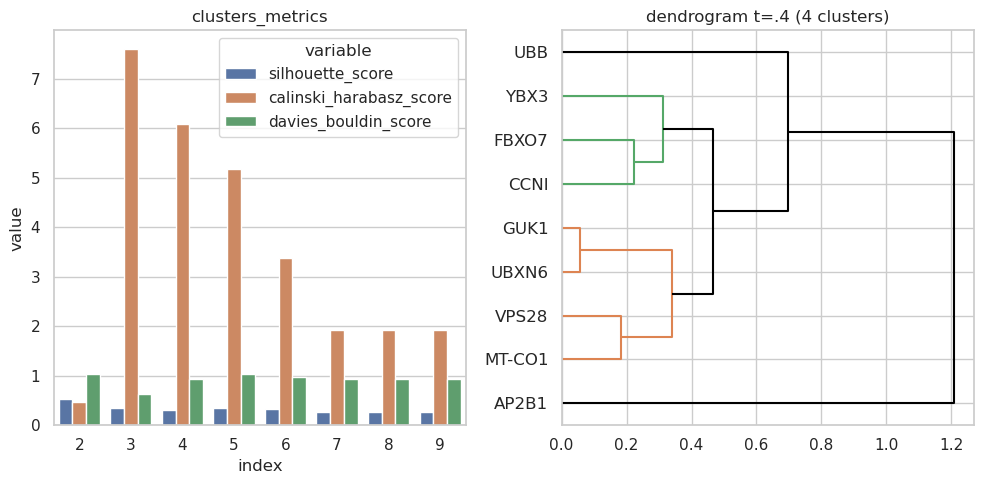

In [173]:
fig = plt.figure(figsize=(10,5))
ax_bar = fig.add_subplot(121)
ax_dn = fig.add_subplot(122)
sns.barplot(x='index',y='value',hue='variable',data=df_scores.iloc[:,:3].melt(ignore_index=False).reset_index(), ax=ax_bar)
ax_bar.set_title('clusters_metrics')

Z = sch.linkage(adata[adata.obs.gse!='GSE86884',genes].X.T, metric='correlation', method='average', optimal_ordering=True)
dn = sch.dendrogram(Z, orientation='right', no_labels=False, labels=genes,color_threshold=.4, above_threshold_color='black',  ax=ax_dn)
ax_dn.set_title('dendrogram t=.4 (4 clusters)')
fig.tight_layout()
fig.savefig(fname='./draft/FIGS3_scores.pdf', bbox_inches='tight', format='pdf', dpi=300)

## FIG 5A: Correlation between HKG

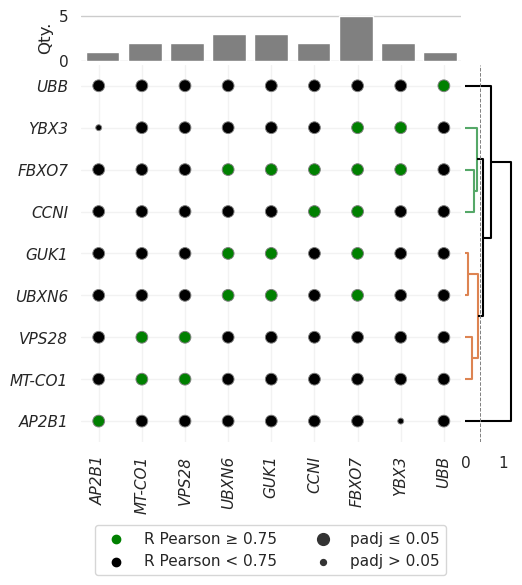

In [174]:
hkg.plot.plot_corr(adata[adata.obs.gse!='GSE86884',genes],r_pearson_lim=0.75, bbox_to_anchor=(.98, -.2), figsize=(8.35*2/3,8.35*2/3),color_threshold=.4, savefig={'fname':'./draft/FIG5A_correlation_distance.pdf', 'bbox_inches':'tight', 'format':'pdf', 'dpi':300})

## Calculate Arithmetic Average, Root Mean Square, Harmonic Mean and geometric mean.

We based on pairs of high correlated genes on hierachical cluster on FIG 5A

In [175]:
from scipy.stats.mstats import gmean, hmean

In [176]:
hkg_sets = [['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1'],
            ['VPS28','MT-CO1'],['UBXN6','GUK1'],['FBXO7','CCNI'],
            ['FBXO7','CCNI','YBX3'],['VPS28','MT-CO1','UBXN6','GUK1'],
            ['UBB'],['AP2B1']]

for i,s in enumerate(hkg_sets):
    if len(s) >= 9:
        # Root Mean Square (RMS)
        adata_ml_corr.layers['rms_all'] = (adata_ml_corr.layers['arcsinh'].T - np.sqrt((np.square(adata_ml_corr[:,s].layers['arcsinh']).sum(axis=1))/len(s))).T
        # Harmonic Mean (HM)
        # adata_aux.layers['hm_all'] = (adata_aux.layers['arcsinh'].T - (len(s)/(1/adata_aux[:,s].layers['arcsinh']).sum(axis=1))).T
        adata_ml_corr.layers['hm_all'] = (adata_ml_corr.layers['arcsinh'].T - hmean(adata_ml_corr[:,s].layers['arcsinh'],axis=1)).T
        # Geometric Mean (GM)
        adata_ml_corr.layers['gm_all'] = (adata_ml_corr.layers['arcsinh'].T - gmean(adata_ml_corr[:,s].layers['arcsinh'],axis=1)).T
        # Arithimetic Mean
        # adata_aux.obs['fs_mean_arcs'] = adata_aux[:,adata_aux.var.index.isin(s)].layers['arcsinh'].mean(axis=1).tolist()
        adata_ml_corr.layers['am_all']= (adata_ml_corr.layers['arcsinh'].T - adata_ml_corr[:,adata_ml_corr.var.index.isin(s)].layers['arcsinh'].mean(axis=1)).T

    elif len(s) >= 2:
        # Root Mean Square (RMS)
        adata_ml_corr.layers['rms_'+'_'.join(s)] = (adata_ml_corr.layers['arcsinh'].T - np.sqrt((np.square(adata_ml_corr[:,s].layers['arcsinh']).sum(axis=1))/len(s))).T
        # Harmonic Mean (HA)
        adata_ml_corr.layers['hm_'+'_'.join(s)] = (adata_ml_corr.layers['arcsinh'].T - hmean(adata_ml_corr[:,s].layers['arcsinh'],axis=1)).T
        # Geometric Mean (GM)
        adata_ml_corr.layers['gm_'+'_'.join(s)] = (adata_ml_corr.layers['arcsinh'].T - gmean(adata_ml_corr[:,s].layers['arcsinh'],axis=1)).T
        # Arithimetic Mean
        adata_ml_corr.layers['am_'+'_'.join(s)] = (adata_ml_corr.layers['arcsinh'].T - adata_ml_corr[:,s].layers['arcsinh'].mean(axis=1)).T
    else:
        adata_ml_corr.layers['diff_'+'_'.join(s)] = (adata_ml_corr.layers['arcsinh'] - adata_ml_corr[:,s].layers['arcsinh'])

/tmp/ipykernel_17258/3617067643.py:9: ImplicitModificationWarning: Setting element `.layers['rms_all']` of view, initializing view as actual.
  adata_ml_corr.layers['rms_all'] = (adata_ml_corr.layers['arcsinh'].T - np.sqrt((np.square(adata_ml_corr[:,s].layers['arcsinh']).sum(axis=1))/len(s))).T


## Boruta excluding features that can differetiate between 2 KMEANS clusters for the same label

In [359]:
# for non-rejection
clusterer_0 = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.ar=='0',:].X)
print(np.unique(clusterer_0.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.ar=='0', 'boruta_groups_0'] = clusterer_0.labels_

# for rejection
clusterer_1 = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.ar=='1',:].X)
print(np.unique(clusterer_1.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.ar=='1', 'boruta_groups_1'] = clusterer_1.labels_

# for tcmr
clusterer_1_tcmr = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.tcmr=='1',:].X)
print(np.unique(clusterer_1_tcmr.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.tcmr=='1', 'boruta_groups_1_tcmr'] = clusterer_1_tcmr.labels_

# for abmrh
clusterer_1_abmrh = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[adata_ml_corr.obs.abmrh=='1',:].X)
print(np.unique(clusterer_1_abmrh.labels_, return_counts=True))
adata_ml_corr.obs.loc[adata_ml_corr.obs.abmrh=='1', 'boruta_groups_1_abmrh'] = clusterer_1_abmrh.labels_

# for abmrh + tcmr
clusterer_1_abmrh_tcmr = KMeans(n_clusters=2, random_state=42).fit(adata_ml_corr[(adata_ml_corr.obs.abmrh=='1') & (adata_ml_corr.obs.tcmr=='1'),:].X)
print(np.unique(clusterer_1_abmrh_tcmr.labels_, return_counts=True))
adata_ml_corr.obs.loc[(adata_ml_corr.obs.abmrh=='1') & (adata_ml_corr.obs.tcmr=='1'), 'boruta_groups_1_abmrh_tcmr'] = clusterer_1_abmrh_tcmr.labels_

(array([0, 1], dtype=int32), array([167,  76]))
(array([0, 1], dtype=int32), array([40, 95]))
(array([0, 1], dtype=int32), array([45, 22]))
(array([0, 1], dtype=int32), array([66, 20]))
(array([0, 1], dtype=int32), array([16,  2]))


**We saved de AnnData to run several python scripts at same time**

In [177]:
# adata_ml_corr.write_h5ad('./adata_corr_b.h5ad')
adata_ml_corr = ad.read_h5ad('./adata_corr_b.h5ad')
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'boruta_groups_0', 'boruta_groups_1', 'boruta_groups_1_tcmr', 'boruta_groups_1_abmrh', 'boruta_groups_1_abmrh_tcmr'
    var: 'equivalent'
    layers: 'MRN', 'TMM', 'TPM', 'TPM1p', 'am_FBXO7_CCNI', 'am_FBXO7_CCNI_YBX3', 'am_UBXN6_GUK1', 'am_VPS28_MT-CO1', 'am_VPS28_MT-CO1_UBXN6_GUK1', 'am_all', 'arcsinh', 'count', 'diff_AP2B1', 'diff_UBB', 'gm_FBXO7_CCNI', 'gm_FBXO7_CCNI_YBX3', 'gm_UBXN6_GUK1', 'gm_VPS28_MT-CO1', 'gm_VPS28_MT-CO1_UBXN6_GUK1', 'gm_all', 'hm_FBXO7_CCNI', 'hm_FBXO7_CCNI_YBX3', 'hm_UBXN6_GUK1', 'hm_VPS28_MT-CO1', 'hm_VPS28_MT-CO1_UBXN6_GUK1', 'hm_all', 'rms_FBXO7_CCNI', 'rms_FBXO7_CCNI_YBX3', 'rms_UBXN6_GUK1', 'rms_VPS28_MT-CO1', 'rms_VPS28_MT-CO1_UBXN6_GUK1', 'rms_all', 'trns_expr'

**We ran python scripts separatly to run in fast way**

In [98]:
# run in bash or cmd:
# python boruta_selection_between_groups_0.py
# python boruta_selection_between_groups_1_abmrh.py
# python boruta_selection_between_groups_1_tcmr.py

In [178]:
adata_ml_corr

AnnData object with n_obs × n_vars = 378 × 161
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan', 'type', 'boruta_groups_0', 'boruta_groups_1', 'boruta_groups_1_tcmr', 'boruta_groups_1_abmrh', 'boruta_groups_1_abmrh_tcmr'
    var: 'equivalent'
    layers: 'MRN', 'TMM', 'TPM', 'TPM1p', 'am_FBXO7_CCNI', 'am_FBXO7_CCNI_YBX3', 'am_UBXN6_GUK1', 'am_VPS28_MT-CO1', 'am_VPS28_MT-CO1_UBXN6_GUK1', 'am_all', 'arcsinh', 'count', 'diff_AP2B1', 'diff_UBB', 'gm_FBXO7_CCNI', 'gm_FBXO7_CCNI_YBX3', 'gm_UBXN6_GUK1', 'gm_VPS28_MT-CO1', 'gm_VPS28_MT-CO1_UBXN6_GUK1', 'gm_all', 'hm_FBXO7_CCNI', 'hm_FBXO7_CCNI_YBX3', 'hm_UBXN6_GUK1', 'hm_VPS28_MT-CO1', 'hm_VPS28_MT-CO1_UBXN6_GUK1', 'hm_all', 'rms_FBXO7_CCNI', 'rms_FBXO7_CCNI_YBX3', 'rms_UBXN6_GUK1', 'rms_VPS28_MT-CO1', 'rms_VPS28_MT-CO1_UBXN6_GUK1', 'rms_all', 'trns_expr'

**Reading dictionaries of features that are important to split data os same class in different K-means clusters.**

In [179]:
import pickle

In [180]:
with open('/mnt/d/housekeeping_genes/dict_boruta_groups_0.pkl', 'rb') as f:
   boruta_sets_g_0 = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_abmrh.pkl', 'rb') as f:
   boruta_sets_g_abmrh = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_tcmr.pkl', 'rb') as f:
   boruta_sets_g_tcmr = pickle.load(f)

fb_boruta_sets_g = dict()
for k in boruta_sets_g_tcmr.keys():
    aux = []
    if k in boruta_sets_g_0.keys():
        aux.extend([g for g in boruta_sets_g_0[k].keys()])

    if k in boruta_sets_g_abmrh.keys():
        aux.extend([g for g in boruta_sets_g_abmrh[k].keys()])

    if k in boruta_sets_g_tcmr.keys():
        aux.extend([g for g in boruta_sets_g_tcmr[k].keys()])
        
    fb_boruta_sets_g[k] = list(set(aux))

# Modeling Naive model

To evaluate the normalization methods, we trainned RF models with parameters that can induce to a overfitting model, to verify which noralization achieve the best metrics

In [6]:
class ColumnExtractor(object):
    """
    A scikit-leraning based class to extract features of interest to train models
    """
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X):
        return X[:,self.cols]
    def fit(self, X, y=None):
        return self

## TMM_adapted and MRN_adapted normalizations

In [185]:
nested_score_dict = dict()
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']

In [186]:
n_jobs = 5
scoring = {'Precision': make_scorer(precision_score,average='weighted', zero_division=0), 
           'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score,average='weighted', zero_division=0),
           'F1': make_scorer(f1_score,average='weighted', zero_division=0),
           'AUC': make_scorer(roc_auc_score,average='weighted', multi_class="ovo")
          }

transform_dict = {'TMM_adapted': hkg.pp.TMM_transformer(),
                  'MRN_adapted': hkg.pp.MRN_transformer()
                 }

In [187]:
t1 = time.time()

for trns in ['TMM_adapted','MRN_adapted']:        
    gn_n = list(set(mkr).difference(set(fb_boruta_sets_g[trns.split('_')[0]]))) #Exclude features that can differentiate cluster within same label
    gn = np.where(adata_ml_corr.var.index.isin(gn_n))[0]
    
    steps = [
        ('sampling', RandomUnderSampler(random_state=random_state)),
        ('transform', transform_dict[trns]),
        ('featslc', ColumnExtractor( gn )),
        ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced',
                                                  n_estimators=100, criterion='gini',max_features=None,
                                                  min_samples_split=2, min_samples_leaf=1,
                                                  n_jobs=n_jobs))
    ]

    # Since MRN and TMM adapted depend on all genes to find normalization factors, we reproduce the dataset of GSE175718 without outliers
    # and all genes used in original MRN and TMM.
    X = adata[adata_ml_corr.obs.index, adata.var.index.isin(df_gens[df_gens.TranslationStatus=='ok'].GeneNames)].layers['count']
    X = np.nan_to_num(X, posinf=0,neginf=0)
    y = adata[adata_ml_corr.obs.index, adata.var.index.isin(df_gens[df_gens.TranslationStatus=='ok'].GeneNames)].obs.ar.astype(int).values
 
    pipe = Pipeline(steps)
    outer_cv = RepeatedStratifiedKFold(random_state=random_state, n_repeats=5)
    nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
    nested_score_dict[trns] = nested_score
    print(trns, end=' ')
    
print((time.time()-t1)/60,'min |',time.time()-t1,'s')

TMM_adapted MRN_adapted 0.19171030124028524 min | 11.502618789672852 s


## HM, AM, GM and RMS normalizations

In [188]:
t1 = time.time()

for trns in adata_ml_corr.layers.keys():
    if trns in ['count', 'trns_expr', 'TPM1p']:
        continue
        
    gn_n = list(set(mkr).difference(set(fb_boruta_sets_g[trns])))
    gn = np.where(adata_ml_corr[(adata_ml_corr.obs.outliers_hdbscan!=-1),:].var.index.isin(gn_n))[0]
    
    steps = [
        ('sampling', RandomUnderSampler(random_state=random_state)),
        ('featslc', ColumnExtractor( gn )),
        ('classification', RandomForestClassifier(random_state=random_state, class_weight='balanced',
                                                  n_estimators=100, criterion='gini',max_features=None,
                                                  min_samples_split=2, min_samples_leaf=1,
                                                  n_jobs=n_jobs))
    ]

    X = adata_ml_corr.layers[trns]
    X = np.nan_to_num(X, posinf=0,neginf=0)
    y = adata_ml_corr.obs.ar.astype(int).values
  
    pipe = Pipeline(steps)
    outer_cv = RepeatedStratifiedKFold(random_state=random_state, n_repeats=5)
    nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
    nested_score_dict[trns] = nested_score
    print(trns, end=' | ')

print((time.time()-t1)/60,'min |',time.time()-t1,'s')

MRN | TMM | TPM | am_FBXO7_CCNI | am_FBXO7_CCNI_YBX3 | am_UBXN6_GUK1 | am_VPS28_MT-CO1 | am_VPS28_MT-CO1_UBXN6_GUK1 | am_all | arcsinh | diff_AP2B1 | diff_UBB | gm_FBXO7_CCNI | gm_FBXO7_CCNI_YBX3 | gm_UBXN6_GUK1 | gm_VPS28_MT-CO1 | gm_VPS28_MT-CO1_UBXN6_GUK1 | gm_all | hm_FBXO7_CCNI | hm_FBXO7_CCNI_YBX3 | hm_UBXN6_GUK1 | hm_VPS28_MT-CO1 | hm_VPS28_MT-CO1_UBXN6_GUK1 | hm_all | rms_FBXO7_CCNI | rms_FBXO7_CCNI_YBX3 | rms_UBXN6_GUK1 | rms_VPS28_MT-CO1 | rms_VPS28_MT-CO1_UBXN6_GUK1 | rms_all | 1.829232641061147 min | 109.75395941734314 s


In [189]:
res_ml_test  = []
res_ml_train = []

for ns in nested_score_dict.keys():    
    res_ml_test.append(ns.split('|') + nested_score_dict[ns]['test_AUC'].tolist())
    res_ml_train.append(ns.split('|') + nested_score_dict[ns]['train_AUC'].tolist())

In [190]:
n=26
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test.columns = ['Norm'] + ['cv_ts'+str(i) for i in range(1,n)] 

res_ml_train = pd.DataFrame(res_ml_train)
res_ml_train.columns = ['Norm'] + ['cv_tr'+str(i) for i in range(1,n)]

res_ml_test['Mean_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_test['Median_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].median(axis=1)
res_ml_test['Std_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)
res_ml_test['1/Std_ts'] = 1/res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)

res_ml_train['Mean_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_train['Median_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].median(axis=1)
res_ml_train['Std_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)
res_ml_train['1/Std_tr'] = 1/res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)

res_ml = res_ml_train.merge(res_ml_test, on=['Norm'])
res_ml['delta_ts_tr'] = res_ml.Median_tr - res_ml.Median_ts

### Read results from ML data leakage

In [42]:
# res_ml.to_csv('./draft/FIG5AC_data_leakage_ml.res.csv', index=False)
# res_ml = pd.read_csv('./draft/FIG5AC_data_leakage_ml.res.csv')

In [198]:
res_ml[(res_ml.Mean_ts>=.45)].sort_values(['Median_ts','Median_tr'], ascending=False).head(10)

Norm    cv_tr1    cv_tr2    cv_tr3    cv_tr4    cv_tr5  \
8      am_VPS28_MT-CO1  0.904639  0.925258  0.917526  0.920513  0.915385   
20       hm_FBXO7_CCNI  0.904639  0.917526  0.920103  0.897436  0.920513   
25              hm_all  0.907216  0.907216  0.917526  0.905128  0.925641   
17     gm_VPS28_MT-CO1  0.899485  0.922680  0.917526  0.920513  0.923077   
23     hm_VPS28_MT-CO1  0.896907  0.920103  0.909794  0.907692  0.930769   
10              am_all  0.909794  0.909794  0.909794  0.910256  0.912821   
19              gm_all  0.896907  0.914948  0.917526  0.910256  0.920513   
5        am_FBXO7_CCNI  0.917526  0.909794  0.925258  0.910256  0.912821   
11             arcsinh  0.912371  0.902062  0.925258  0.897436  0.920513   
15  gm_FBXO7_CCNI_YBX3  0.907216  0.899485  0.917526  0.915385  0.912821   

      cv_tr6    cv_tr7    cv_tr8    cv_tr9  ...   cv_ts21   cv_ts22   cv_ts23  \
8   0.894330  0.920103  0.920103  0.910256  ...  0.659864  0.612623  0.686697   
20  0.891753  0.891753  0.930412  0.910256  ...  0.695011  0.649660  0.672714   
25  0.904639  0.886598  0.922680  0.910256  ...  0.645881  0.659864  0.649660   
17  0.889175  0.902062  0.920103  0.912821  ...  0.637566  0.641345  0.620937   
23  0.889175  0.904639  0.914948  0.917949  ...  0.641345  0.641345  0.659864   
10  0.912371  0.886598  0.930412  0.917949  ...  0.635676  0.651550  0.657974   
19  0.909794  0.889175  0.917526  0.915385  ...  0.596750  0.604308  0.666289   
5   0.894330  0.889175  0.930412  0.902564  ...  0.656085  0.620937  0.682918   
11  0.894330  0.917526  0.912371  0.920513  ...  0.662509  0.592215  0.688587   
15  0.894330  0.891753  0.922680  0.907692  ...  0.633787  0.567271  0.695011   

     cv_ts24   cv_ts25   Mean_ts  Median_ts    Std_ts   1/Std_ts  delta_ts_tr  
8   0.611111  0.682870  0.658360   0.651620  0.033424  29.918846     0.268483  
20  0.503472  0.625000  0.641961   0.650463  0.049343  20.266126     0.259793  
25  0.511574  0.640046  0.639733   0.649660  0.046702  21.412238     0.265725  
17  0.563657  0.703704  0.656307   0.648148  0.041687  23.988071     0.271955  
23  0.571759  0.682870  0.647898   0.645833  0.041920  23.855128     0.274270  
10  0.513889  0.640046  0.636917   0.645125  0.051689  19.346399     0.267696  
19  0.503472  0.640046  0.636492   0.640046  0.046543  21.485344     0.274902  
5   0.550926  0.653935  0.635971   0.637731  0.043975  22.739961     0.272525  
11  0.493056  0.612269  0.621603   0.637566  0.054697  18.282550     0.277382  
15  0.545139  0.645833  0.626086   0.637566  0.049056  20.384731     0.270126  

[10 rows x 60 columns]

In [192]:
res_ml[(res_ml.Norm.isin(['MRN','TMM','TMM_adapted','MRN_adapted']))].sort_values(['Median_ts','Median_tr'], ascending=False).head(20)

Norm    cv_tr1    cv_tr2    cv_tr3    cv_tr4    cv_tr5    cv_tr6  \
2          MRN  0.922680  0.925258  0.914948  0.917949  0.917949  0.894330   
3          TMM  0.914948  0.912371  0.932990  0.915385  0.894872  0.902062   
1  MRN_adapted  0.912371  0.905689  0.864977  0.847080  0.804915  0.886598   
0  TMM_adapted  0.904639  0.894330  0.891753  0.874858  0.910256  0.902062   

     cv_tr7    cv_tr8    cv_tr9  ...   cv_ts21   cv_ts22   cv_ts23   cv_ts24  \
2  0.909794  0.932990  0.907692  ...  0.647770  0.511716  0.666289  0.524306   
3  0.912371  0.909794  0.917949  ...  0.626606  0.558957  0.555178  0.550926   
1  0.827892  0.884021  0.850214  ...  0.539305  0.514361  0.411565  0.545139   
0  0.889700  0.881443  0.879986  ...  0.528345  0.467120  0.438398  0.440972   

    cv_ts25   Mean_ts  Median_ts    Std_ts   1/Std_ts  delta_ts_tr  
2  0.612269  0.620962   0.612623  0.052374  19.093468     0.305326  
3  0.614583  0.588319   0.590325  0.036296  27.551015     0.324623  
1  0.532407  0.521513   0.532880  0.059902  16.693889     0.345986  
0  0.480324  0.502909   0.500378  0.052421  19.076153     0.392428  

[4 rows x 60 columns]

In [193]:
res_ml_melt = res_ml.set_index('Norm')[[c for c in res_ml.columns if 'cv' in c]].melt(ignore_index=False).reset_index()
res_ml_melt['variable'] = np.where(res_ml_melt.variable.str.contains('tr'), 'Train', 'Test')

In [194]:
res_diff = pd.DataFrame(res_ml.set_index('Norm')[[c for c in res_ml.columns if 'cv_tr' in c]].values - res_ml.set_index('Norm')[[c for c in res_ml.columns if 'cv_ts' in c]].values, index=res_ml.Norm).melt(ignore_index=False).reset_index()

## FIG 5B-E: comparing Data Leakage between normalization methods

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


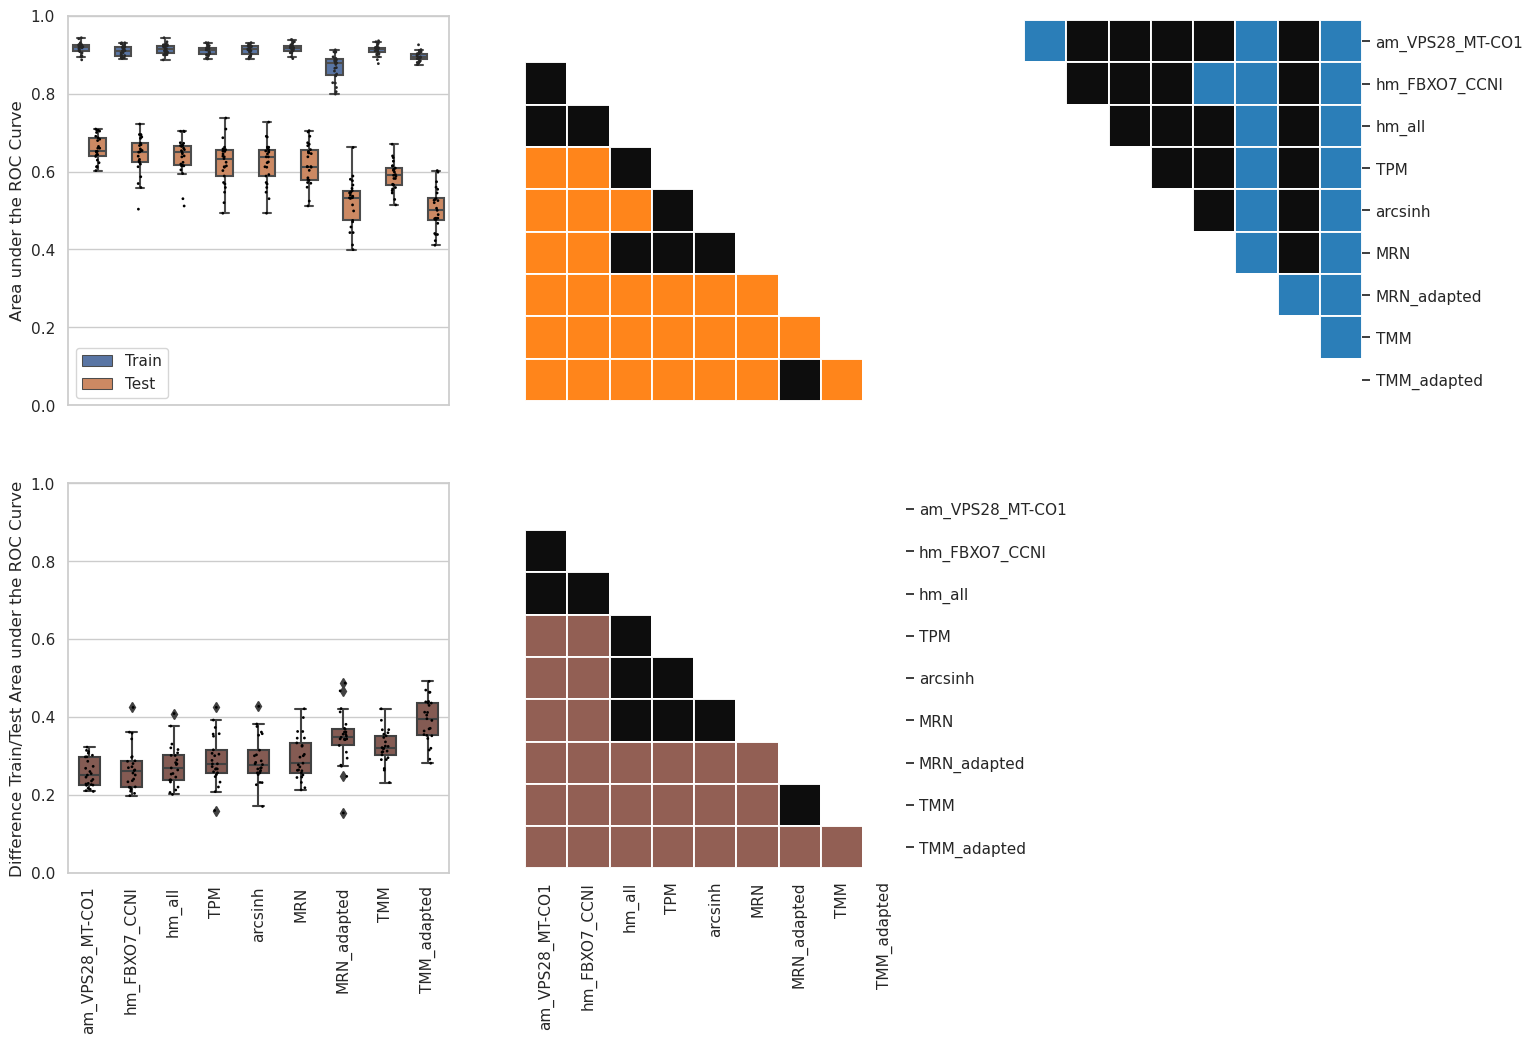

In [196]:
fig = plt.figure(figsize=(8.35*2, 8.35*4/3))

ax_tt = fig.add_subplot(231)
ax_tr_hm = fig.add_subplot(233)
ax_ts_hm = fig.add_subplot(232)
ax_diff = fig.add_subplot(234)
ax_diff_hm = fig.add_subplot(235)

x='Norm'
y='value'
# order=['pair_arcs_VPS28_MT-CO1_diff','TPM','arcsinh','MRN','MRN_transformer','TMM','TMM_transformer']
order=['am_VPS28_MT-CO1','hm_FBXO7_CCNI','hm_all','TPM','arcsinh','MRN','MRN_adapted','TMM','TMM_adapted']#[::-1]
hue='variable'
hue_order=['Train','Test']

data = res_ml_melt[res_ml_melt.Norm.isin(order)]
data_2 = res_diff[res_diff.Norm.isin(order)]

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=2, dodge=True, data=data, ax=ax_tt)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, fliersize=0, data=data, ax=ax_tt)
ax_tt.set_xticklabels([])
ax_tt.set_ylabel('Area under the ROC Curve')
ax_tt.set_xlabel('')
ax_tt.set_ylim([0,1])

handles, labels = ax_tt.get_legend_handles_labels()
ax_tt.legend(handles=np.array(handles)[-2:].tolist(), labels=np.array(labels)[-2:].tolist(), ncol=1)

pairs = list(itertools.combinations(order,2))
p_tr = []
p_ts = []
p_diff = []
for p in pairs:
    p_tr.append(wilcoxon(data[(data.variable=='Train') & (data.Norm==p[0])].value.values, data[(data.variable=='Train') & (data.Norm==p[1])].value.values).pvalue)
    p_ts.append(wilcoxon(data[(data.variable=='Test') & (data.Norm==p[0])].value.values, data[(data.variable=='Test') & (data.Norm==p[1])].value.values).pvalue)
    p_diff.append(wilcoxon(data_2[(data_2.Norm==p[0])].value.values, data_2[(data_2.Norm==p[1])].value.values).pvalue)

p_tr = false_discovery_control(p_tr)
p_ts = false_discovery_control(p_ts)
p_diff = false_discovery_control(p_diff)

df_p_tr = pd.DataFrame(pairs)
df_p_tr = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_tr['adj_pv'] = np.concatenate([p_tr, p_tr])
df_p_tr = df_p_tr.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap((df_p_tr.loc[order,order]<=0.05).astype(int), cmap=['black', '#1f77b4'],mask=np.tril(df_p_tr), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_tr_hm)
# ax_tr_hm.set_yticklabels([])
ax_tr_hm.set_ylabel('')
ax_tr_hm.set_xlabel('')
ax_tr_hm.grid(False)
ax_tr_hm.set_xticklabels([])
ax_tr_hm.yaxis.tick_right()
ax_tr_hm.set_yticklabels(ax_tr_hm.get_yticklabels(), rotation=0)

df_p_ts = pd.DataFrame(pairs)
df_p_ts = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_ts['adj_pv'] = np.concatenate([p_ts, p_ts])
df_p_ts = df_p_ts.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap((df_p_ts.loc[order,order]<=0.05).astype(int), cmap=['black', '#ff7f0e'],mask=np.triu(df_p_ts, k=0), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_ts_hm)
# 
# ax_ts_hm.yaxis.tick_right()
# ax_ts_hm.set_yticklabels(ax_ts_hm.get_yticklabels(), rotation=0)
ax_ts_hm.set_ylabel('')
ax_ts_hm.set_xlabel('')
ax_ts_hm.set_xticklabels([])
ax_ts_hm.set_yticklabels([])
ax_ts_hm.grid(False)


sns.stripplot(x=x, y=y, order=order, color='black', s=2, dodge=True, data=data_2, ax=ax_diff)
sns.boxplot(x=x, y=y, order=order, color='#8c564b', width=.5, data=data_2, ax=ax_diff)
ax_diff.set_ylabel('Difference Train/Test Area under the ROC Curve')
ax_diff.set_xlabel('')
ax_diff.set_xticklabels(ax_diff.get_xticklabels(), rotation=90)
ax_diff.set_ylim([0,1])

# annot_diff = Annotator(ax_diff, list(itertools.product(['pair_arcs_VPS28_MT-CO1_diff'],df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().index)),
#                        data=res_diff, x=x, y=y, order=order)
# annot_diff.configure(test=None, text_format='star', loc='inside', verbose=0)
# annot_diff.set_pvalues(df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().values)
# annot_diff.annotate()

df_p_diff = pd.DataFrame(pairs)
df_p_diff = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_diff['adj_pv'] = np.concatenate([p_diff, p_diff])
df_p_diff = df_p_diff.pivot(columns=0, index=1, values='adj_pv').fillna(1)

sns.heatmap((df_p_diff.loc[order,order]<=0.05).astype(int), cmap=['black', '#8c564b'],mask=np.triu(df_p_diff), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_diff_hm)
# ax_diff_hm.set_yticklabels([])
ax_diff_hm.yaxis.tick_right()
ax_diff_hm.set_yticklabels(ax_diff_hm.get_yticklabels(), rotation=0)
ax_diff_hm.set_ylabel('')
ax_diff_hm.set_xlabel('')
ax_diff_hm.grid(False)
    
# fig.tight_layout()
fig.savefig('./draft/FIG5BCDE_data_leakage.pdf', bbox_inches='tight', format='pdf', dpi=300)

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


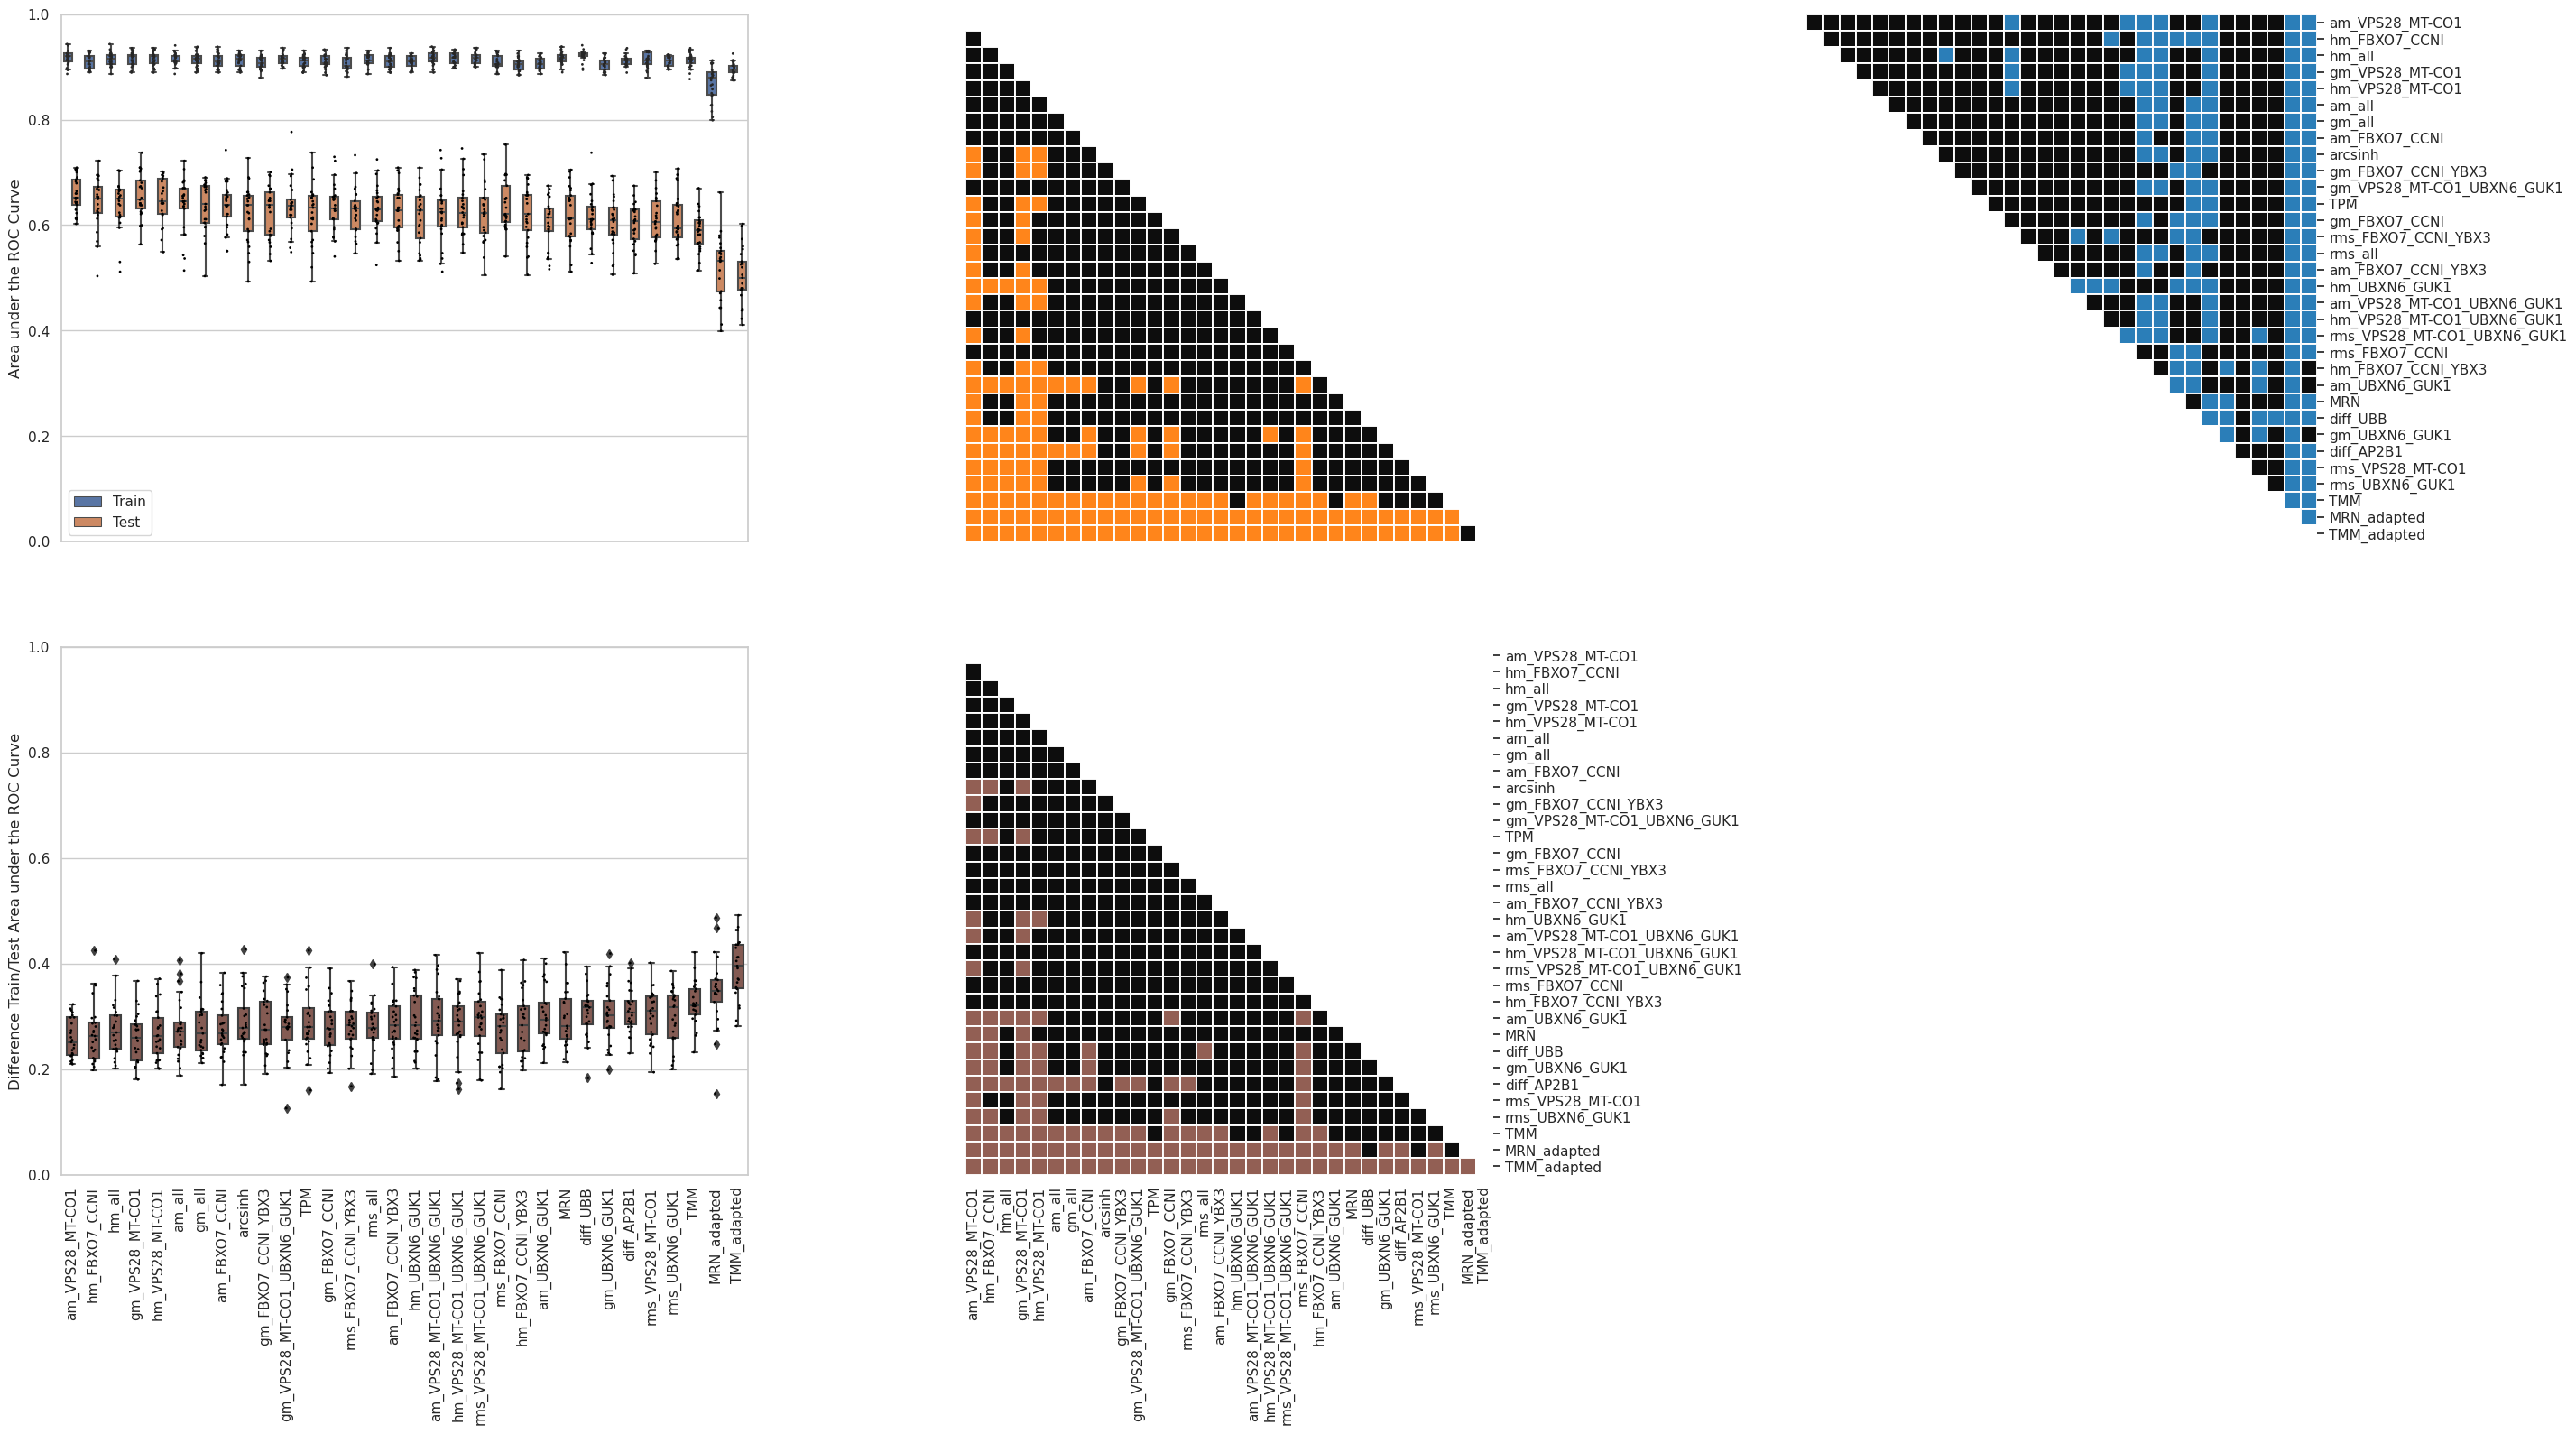

In [199]:
fig = plt.figure(figsize=(8.35*4, 8.35*2))

ax_tt = fig.add_subplot(231)
ax_tr_hm = fig.add_subplot(233)
ax_ts_hm = fig.add_subplot(232)
ax_diff = fig.add_subplot(234)
ax_diff_hm = fig.add_subplot(235)

x='Norm'
y='value'
# order=['pair_arcs_VPS28_MT-CO1_diff','TPM','arcsinh','MRN','MRN_transformer','TMM','TMM_transformer']
order=res_ml.sort_values(['Median_ts','Median_tr'], ascending=False).Norm.tolist()
hue='variable'
hue_order=['Train','Test']

data = res_ml_melt[res_ml_melt.Norm.isin(order)]
data_2 = res_diff[res_diff.Norm.isin(order)]

sns.stripplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, color='black', s=2, dodge=True, data=data, ax=ax_tt)
sns.boxplot(x=x, y=y, order=order, hue=hue, hue_order=hue_order, fliersize=0, data=data, ax=ax_tt)
ax_tt.set_xticklabels([])
ax_tt.set_ylabel('Area under the ROC Curve')
ax_tt.set_xlabel('')
ax_tt.set_ylim([0,1])

handles, labels = ax_tt.get_legend_handles_labels()
ax_tt.legend(handles=np.array(handles)[-2:].tolist(), labels=np.array(labels)[-2:].tolist(), ncol=1)

pairs = list(itertools.combinations(order,2))
p_tr = []
p_ts = []
p_diff = []
for p in pairs:
    p_tr.append(wilcoxon(data[(data.variable=='Train') & (data.Norm==p[0])].value.values, data[(data.variable=='Train') & (data.Norm==p[1])].value.values).pvalue)
    p_ts.append(wilcoxon(data[(data.variable=='Test') & (data.Norm==p[0])].value.values, data[(data.variable=='Test') & (data.Norm==p[1])].value.values).pvalue)
    p_diff.append(wilcoxon(data_2[(data_2.Norm==p[0])].value.values, data_2[(data_2.Norm==p[1])].value.values).pvalue)

p_tr = false_discovery_control(p_tr)
p_ts = false_discovery_control(p_ts)
p_diff = false_discovery_control(p_diff)

df_p_tr = pd.DataFrame(pairs)
df_p_tr = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_tr['adj_pv'] = np.concatenate([p_tr, p_tr])
df_p_tr = df_p_tr.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap((df_p_tr.loc[order,order]<=0.05).astype(int), cmap=['black', '#1f77b4'],mask=np.tril(df_p_tr), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_tr_hm)
# ax_tr_hm.set_yticklabels([])
ax_tr_hm.set_ylabel('')
ax_tr_hm.set_xlabel('')
ax_tr_hm.grid(False)
ax_tr_hm.set_xticklabels([])
ax_tr_hm.yaxis.tick_right()
ax_tr_hm.set_yticklabels(ax_tr_hm.get_yticklabels(), rotation=0)

df_p_ts = pd.DataFrame(pairs)
df_p_ts = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_ts['adj_pv'] = np.concatenate([p_ts, p_ts])
df_p_ts = df_p_ts.pivot(columns=0, index=1, values='adj_pv').fillna(1)
sns.heatmap((df_p_ts.loc[order,order]<=0.05).astype(int), cmap=['black', '#ff7f0e'],mask=np.triu(df_p_ts, k=0), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_ts_hm)
# 
# ax_ts_hm.yaxis.tick_right()
# ax_ts_hm.set_yticklabels(ax_ts_hm.get_yticklabels(), rotation=0)
ax_ts_hm.set_ylabel('')
ax_ts_hm.set_xlabel('')
ax_ts_hm.set_xticklabels([])
ax_ts_hm.set_yticklabels([])
ax_ts_hm.grid(False)


sns.stripplot(x=x, y=y, order=order, color='black', s=2, dodge=True, data=data_2, ax=ax_diff)
sns.boxplot(x=x, y=y, order=order, color='#8c564b', width=.5, data=data_2, ax=ax_diff)
ax_diff.set_ylabel('Difference Train/Test Area under the ROC Curve')
ax_diff.set_xlabel('')
ax_diff.set_xticklabels(ax_diff.get_xticklabels(), rotation=90)
ax_diff.set_ylim([0,1])

# annot_diff = Annotator(ax_diff, list(itertools.product(['pair_arcs_VPS28_MT-CO1_diff'],df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().index)),
#                        data=res_diff, x=x, y=y, order=order)
# annot_diff.configure(test=None, text_format='star', loc='inside', verbose=0)
# annot_diff.set_pvalues(df_p_diff[df_p_diff['pair_arcs_VPS28_MT-CO1_diff']<1]['pair_arcs_VPS28_MT-CO1_diff'].sort_values().values)
# annot_diff.annotate()

df_p_diff = pd.DataFrame(pairs)
df_p_diff = pd.concat([ pd.DataFrame(pairs), pd.DataFrame([(p[1],p[0]) for p in pairs])])
df_p_diff['adj_pv'] = np.concatenate([p_diff, p_diff])
df_p_diff = df_p_diff.pivot(columns=0, index=1, values='adj_pv').fillna(1)

sns.heatmap((df_p_diff.loc[order,order]<=0.05).astype(int), cmap=['black', '#8c564b'],mask=np.triu(df_p_diff), alpha=.95, square=True, linecolor='white', linewidths=.1, cbar=False, ax=ax_diff_hm)
# ax_diff_hm.set_yticklabels([])
ax_diff_hm.yaxis.tick_right()
ax_diff_hm.set_yticklabels(ax_diff_hm.get_yticklabels(), rotation=0)
ax_diff_hm.set_ylabel('')
ax_diff_hm.set_xlabel('')
ax_diff_hm.grid(False)
    
# fig.tight_layout()
fig.savefig('./draft/FIGS4_data_leakage.pdf', bbox_inches='tight', format='pdf', dpi=300)

# Improving the predictor

In [155]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_samples, silhouette_score
from sknetwork.clustering import Louvain, get_modularity
import xgboost as xgb

import hdbscan

In [156]:
genes = ['AP2B1', 'CCNI', 'FBXO7', 'GUK1', 'UBB', 'UBXN6', 'VPS28', 'YBX3', 'MT-CO1']
mkr = ['HOMER3','CD14','IFI27','ZEB2','IL18R1','DAAM2','GBP5','NKG7','PATL2','DGKH','SLAMF7']

## Get genes that are in microarray

In [231]:
df_gens = pd.read_csv('./Microarray_RNAseq_mygene_translation.csv', index_col=0, header=None, names=['GeneNames','TranslationStatus'])

df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'GeneNames'] = 'MT-CO1'
df_gens.loc[(df_gens.index.str.contains('1553538_s_at')),'TranslationStatus'] = 'ok'

df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'GeneNames'] = 'UBXN6'
df_gens.loc[(df_gens.index.str.contains('220757_s_at')),'TranslationStatus'] = 'ok'

In [232]:
adata = ad.read_h5ad('adata_RNAseq_louvain.h5ad')
adata_ml = adata[adata.obs.gse=='GSE175718', adata.var.index.isin(list(set(df_gens[df_gens.TranslationStatus=='ok'].GeneNames)))]
adata_ml

View of AnnData object with n_obs × n_vars = 384 × 20147
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count'

### Calcluate am_VPS28_MT-CO1

In [233]:
hkg.pp.log_transform(adata_ml, method='arcsinh')
s = ['VPS28', 'MT-CO1']
adata_ml.layers['am_'+'_'.join(s)] = (adata_ml.layers['arcsinh'].T - adata_ml[:,s].layers['arcsinh'].mean(axis=1)).T
adata_ml

/mnt/e/housekeeping_genes/housekeepingMinerPy/pp.py:140: ImplicitModificationWarning: Setting element `.layers['arcsinh']` of view, initializing view as actual.
  adata.layers[method] = np.arcsinh(X_)


AnnData object with n_obs × n_vars = 384 × 20147
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2'
    var: 'equivalent'
    layers: 'count', 'arcsinh', 'am_VPS28_MT-CO1'

## Detect outliers with HDBSCAN

Detec outliers to exclude them from the traning-testing process. this algorithm flag outliers with -1

In [234]:
ol_detection = hdbscan.HDBSCAN().fit(adata_ml.X)
print(np.unique(ol_detection.labels_, return_counts=True))
adata_ml.obs.loc[:,'outliers_hdbscan'] = ol_detection.labels_

(array([-1,  0,  1]), array([  5, 351,  28]))


We excluded SRR14675592 because it is only zeros for hkg

In [235]:
adata_ml[adata_ml.obs.index=='SRR14675592', genes].X

ArrayView([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [236]:
adata_ml.obs.loc[adata_ml.obs.index=='SRR14675592','outliers_hdbscan'] = -1

In [237]:
adata_ml.obs.groupby('outliers_hdbscan').count()

abmrh  tcmr   ar  gse  gse_time  gse_patient  louvain_group  \
outliers_hdbscan                                                                
-1                    6     6    6    6         6            6              6   
 0                  351   351  351  351       351          351            351   
 1                   27    27   27   27        27           27             27   

                  UMAP_1  UMAP_2  
outliers_hdbscan                  
-1                     6       6  
 0                   351     351  
 1                    27      27

## Excluding outliers

In total 6 sampels were excluded from the samples.

In [238]:
adata_ml = adata_ml[adata_ml.obs.outliers_hdbscan!=-1]
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 20147
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count', 'arcsinh', 'am_VPS28_MT-CO1'

## Excluding genes with zeros in rejection and non-rejection reater than 3/4 of total

In [239]:
adata_ml.obs.groupby('ar').count()*.25

/tmp/ipykernel_21743/1569926776.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_ml.obs.groupby('ar').count()*.25


abmrh   tcmr    gse  gse_time  gse_patient  louvain_group  UMAP_1  UMAP_2  \
ar                                                                              
0   60.75  60.75  60.75     60.75        60.75          60.75   60.75   60.75   
1   33.75  33.75  33.75     33.75        33.75          33.75   33.75   33.75   

    outliers_hdbscan  
ar                    
0              60.75  
1              33.75

In [240]:
# md_0 = np.median((adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0))
# md_1 = np.median((adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0))

set_0 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='0',:].X==0).sum(axis=0) > 60].var.index)
set_1 = set(adata_ml[:,(adata_ml[adata_ml.obs.ar=='1',:].X==0).sum(axis=0) > 33].var.index)

len(set_0), len(set_1), len(set_0.intersection(set_1))

(9860, 9547, 9501)

In [241]:
exc = list(set_0.intersection(set_1))

In [242]:
set(genes).intersection( set_0.intersection(set_1) )

set()

In [243]:
adata_ml = adata_ml[:,~adata_ml.var.index.isin(exc)]
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 10646
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count', 'arcsinh', 'am_VPS28_MT-CO1'

## Excluding genes related to immune pathways

In [17]:
from Bio.KEGG import REST

In [18]:
human_pathways = REST.kegg_list("pathway", "hsa").read()#.decode("utf-8").split("\n")

In [19]:
imm_paths = [h.split('\t')[0] for h in human_pathways.split("\n") if ('chemokine ' in h.lower()) or ('cytokine' in h.lower()) or ('b cell' in h.lower()) or ('t cell' in h.lower()) or ('killer cell' in h.lower())  or ('neutrophil' in h.lower()) or ('antigen' in h.lower()) or ('th1' in h.lower())  or ('il-' in h.lower()) or ('leukocyte' in h.lower()) or ('inflamm' in h.lower()) or ('tgf' in h.lower())  or ('jak-stat' in h.lower()) or ('tnf' in h.lower()) or ('mapk' in h.lower()) or ('ampk' in h.lower())  or ('notch' in h.lower()) or ('vegf' in h.lower()) or ('hif' in h.lower()) or ('foxo' in h.lower()) or ('calcium' in h.lower()) or ('mtor' in h.lower()) or ('camp' in h.lower()) or ('cgmp' in h.lower()) or ('toll' in h.lower()) or ('nod' in h.lower()) or ('rig' in h.lower()) or ('fc ' in h.lower()) or ('hematopoietic' in h.lower()) or ('coagulation cascades' in h.lower()) or ('platelet' in h.lower()) or ('cytosolic' in h.lower()) or ('c-type' in h.lower()) or ('leukocyte' in h.lower()) or ('intestinal immune' in h.lower())]
# imm_paths.sort()
print(imm_paths)

['hsa03260', 'hsa04010', 'hsa04330', 'hsa04350', 'hsa04370', 'hsa04630', 'hsa04668', 'hsa04066', 'hsa04068', 'hsa04020', 'hsa04024', 'hsa04022', 'hsa04152', 'hsa04150', 'hsa04060', 'hsa04061', 'hsa04640', 'hsa04610', 'hsa04611', 'hsa04613', 'hsa04620', 'hsa04621', 'hsa04622', 'hsa04623', 'hsa04625', 'hsa04650', 'hsa04612', 'hsa04660', 'hsa04658', 'hsa04659', 'hsa04657', 'hsa04662', 'hsa04664', 'hsa04666', 'hsa04670', 'hsa04672', 'hsa04062', 'hsa04920', 'hsa04961', 'hsa04750', 'hsa05170', 'hsa05321', 'hsa05340', 'hsa05412']


In [22]:
imm_genes = []
for hs in imm_paths:
    for line in REST.kegg_get(hs).read().split('\n'):
        section = line[:12].strip()
        if not section == '':
            current_section = section
        if current_section == "GENE":
            if ';' in line:
                gene_identifiers, gene_description = line[12:].split("; ")
                gene_id, gene_symbol = gene_identifiers.split()
                
                if not gene_symbol in imm_genes:
                    imm_genes.append(gene_symbol)

In [47]:
# with open('imm_genes.txt', 'w') as f:
#     f.write(','.join(imm_genes))

with open('imm_genes.txt', 'r') as f:
    imm_genes = f.read().split(',')

In [91]:
len(imm_genes)

2306

In [19]:
print('Not found in adata',set(imm_genes).difference(set(imm_genes).intersection(set(adata.var.index))))

Not found in adata {'HLA-DRB4', 'LILRA3', 'KIR2DS5', 'KIR2DS2', 'H2AB3', 'APOBEC3A_B', 'KIR2DS1', 'CCL3L1', 'KIR3DS1', 'KIR2DS3', 'HLA-DRB3', 'ATP6V1FP2', 'IGH', 'CCL4L1', 'C4B_2', 'KIR2DL5A', 'KIR2DL2'}


In [20]:
len(set(imm_genes).intersection(set(adata_ml.var.index)))

2192

In [92]:
adata_ml_not_imm = adata_ml[:,~adata_ml.var.index.isin(imm_genes)]
adata_ml_not_imm

# adata_ml = adata_ml[:,~adata_ml.var.index.isin(imm_genes)]
# adata_ml

View of AnnData object with n_obs × n_vars = 378 × 17955
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count'

In [49]:
adata_ml_imm = adata_ml[:,adata_ml.var.index.isin(imm_genes)]
adata_ml_imm

# adata_ml = adata_ml[:,adata_ml.var.index.isin(imm_genes+['VPS28','MT-CO1'])]
# adata_ml

View of AnnData object with n_obs × n_vars = 378 × 2194
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count'

## Correlation

### Reorder the genes from most expressed to less. 
Than the exclusion by correlation will retain high expressed genes

In [99]:
adata_ml.to_df().mean().sort_values(ascending=False)

Gene_name
HBB        320894.411022
HBA1        45179.209822
IFITM2       5234.657236
SNORD26      2506.286407
RPS29        2484.897322
               ...      
SEMA5A          0.039559
TTC28           0.039053
CCDC80          0.037000
KCNJ6           0.033778
ARFGEF3         0.030111
Length: 9367, dtype: float64

In [100]:
adata_ml = adata_ml[:,adata_ml.to_df().mean().sort_values(ascending=False).index]
adata_ml

View of AnnData object with n_obs × n_vars = 378 × 9367
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count'

### Calculate correlation distance cluster for HKG

In [374]:
t1 = time.time()
corr = pdist(adata_ml.X.T, metric='correlation')
t2 = time.time()
print((t2-t1)/60, 'min')

0.15046544075012208 min


In [375]:
t1 = time.time()
corr = np.abs(1-corr)
t2 = time.time()
print((t2-t1)/60, 'min')

0.005127616723378499 min


In [49]:
# corr = np.abs(corr)

In [19]:
# t1 = time.time()
# corr = np.where(corr<7, np.nan, corr)
# t2 = time.time()
# print((t2-t1)/60, 'min')

0.004464733600616455 min


In [376]:
t1 = time.time()
corr_df = pd.DataFrame(squareform(corr))
corr_df.to_csv('corr_dist.csv')
t2 = time.time()
print((t2-t1)/60, 'min')

1.753808601697286 min


In [340]:
import pandas as pd
import numpy as np

In [2]:
# corr_df = pd.read_csv('corr_dist.csv', index_col=0)
# corr_df = (1-corr_df).abs()

### Calculate Pearson correlation

In [101]:
t1 = time.time()
corr_df_imm = adata_ml_imm.to_df().corr()
corr_df_imm.to_csv('corr_pearson_imm.csv')
t2 = time.time()
print(int((t2-t1)//60),(t2-t1)%60, sep=':')

-5.0:20.347809314727783


In [ ]:
t1 = time.time()
corr_df_not_imm = adata_ml_not_imm.to_df().corr()
corr_df_not_imm.to_csv('corr_pearson_not_imm.csv')
t2 = time.time()
print(int((t2-t1)//60),(t2-t1)%60, sep=':')

In [31]:
corr_df_imm = pd.read_csv('corr_pearson_imm.csv', index_col=0)
corr_df_not_imm = pd.read_csv('corr_pearson_not_imm.csv', index_col=0)

In [61]:
corr_df_imm.head()

Gene_name     ABCC4     ACACA     ACACB     ACOX1     ACOX3     ACSL1  \
Gene_name                                                               
ABCC4      1.000000 -0.036953  0.096083 -0.006690  0.116809  0.173952   
ACACA     -0.036953  1.000000  0.229044  0.107029  0.138562 -0.016079   
ACACB      0.096083  0.229044  1.000000  0.259693  0.134324  0.152906   
ACOX1     -0.006690  0.107029  0.259693  1.000000  0.119931  0.509436   
ACOX3      0.116809  0.138562  0.134324  0.119931  1.000000  0.190620   

Gene_name     ACSL3     ACSL4     ACSL5     ACSL6  ...       WAS     WASF2  \
Gene_name                                          ...                       
ABCC4      0.332271  0.240779  0.132591  0.097428  ...  0.081654  0.207255   
ACACA      0.068820  0.007269  0.228798  0.103000  ...  0.208332  0.153012   
ACACB      0.215762  0.224493  0.340848  0.296180  ...  0.294581  0.312167   
ACOX1      0.184380  0.225563  0.199164  0.240600  ...  0.574741  0.435652   
ACOX3      0.212871  0.199742  0.216185  0.146084  ...  0.276165  0.213937   

Gene_name     WDR59      XIAP     YWHAE     ZAP70      ZBP1    ZCCHC3  \
Gene_name                                                               
ABCC4     -0.015242  0.123107  0.213358 -0.013337  0.145050 -0.005195   
ACACA      0.164376  0.026769  0.170864  0.269981 -0.049974  0.160070   
ACACB      0.228254  0.048407  0.367568  0.244044  0.147299  0.206026   
ACOX1      0.193468  0.057371  0.303125  0.162821  0.271416  0.328455   
ACOX3      0.095019  0.112851  0.287660  0.291298  0.124945  0.336279   

Gene_name   ZFYVE16     ZNFX1  
Gene_name                      
ABCC4      0.291639  0.088703  
ACACA      0.103759  0.202851  
ACACB      0.355219  0.309900  
ACOX1      0.370460  0.515294  
ACOX3      0.313105  0.255760  

[5 rows x 1281 columns]

In [ ]:
corr_df_not_imm.head()

### Exclude high correlated genes

In [102]:
upper = corr_df_imm.where(np.triu(np.ones(corr_df_imm.shape), k=1).astype(np.bool_))
to_drop_imm = [column for column in upper.columns if any(upper[column] > 0.8)]

In [ ]:
upper = corr_df_not_imm.where(np.triu(np.ones(corr_df_not_imm.shape), k=1).astype(np.bool_))
to_drop_not_imm = [column for column in upper.columns if any(upper[column] > 0.8)]

In [103]:
print(len(to_drop_imm), adata_ml.shape[1]-len(to_drop_imm), to_drop[-5:])
print(len(to_drop_not_imm), adata_ml.shape[1]-len(to_drop_not_imm), to_drop[-5:])

(1500, 7867, ['SRD5A1', 'COL6A3', 'PCDH9', 'JPH2', 'FBXO41'])

In [487]:
# with open('to_drop_.3.csv', 'w') as f:
#     f.write(','.join(to_drop))

# with open('to_drop_.3.csv', 'r') as f:
#     for line in f:
#         to_drop = line.split(',')

# to_drop = [int(d) for d in to_drop]
# to_drop = adata_ml.var.iloc[to_drop,:].index.tolist()
# print(to_drop[-5:])

In [104]:
print(set(genes).intersection(to_drop_imm))
print(set(genes).intersection(to_drop_not_imm))
for g in ['VPS28','MT-CO1']:#set(genes).intersection(to_drop):
    if g in to_drop_imm:
        to_drop_imm.remove(g)
    if g in to_drop_not_imm:
        to_drop_not_imm.remove(g)
print(set(genes).intersection(to_drop_imm))
print(set(genes).intersection(to_drop_not_imm))

set()
set()


In [139]:
# print(set(mkr).intersection(to_drop))
# for g in set(mkr).intersection(to_drop):
#     to_drop.remove(g)
# print(set(mkr).intersection(to_drop))

{'HOMER3', 'DAAM2', 'ZEB2', 'PATL2', 'CD14', 'IFI27', 'IL18R1', 'GBP5', 'SLAMF7', 'DGKH', 'NKG7'}


In [105]:
# adata_ml = adata_ml[:,~adata_ml.var.index.isin(to_drop)]
# adata_ml

View of AnnData object with n_obs × n_vars = 378 × 7867
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count'

### read features that can differentiate groups in same class

In [67]:
import pickle

In [68]:
with open('/mnt/d/housekeeping_genes/dict_boruta_groups_0.pkl', 'rb') as f:
   boruta_sets_g_0 = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_abmrh.pkl', 'rb') as f:
   boruta_sets_g_abmrh = pickle.load(f)

with open('/mnt/d/housekeeping_genes/dict_boruta_groups_1_tcmr.pkl', 'rb') as f:
   boruta_sets_g_tcmr = pickle.load(f)

fb_boruta_sets_g = dict()
for k in boruta_sets_g_tcmr.keys():
    aux = []
    if k in boruta_sets_g_0.keys():
        aux.extend([g for g in boruta_sets_g_0[k].keys()])

    if k in boruta_sets_g_abmrh.keys():
        aux.extend([g for g in boruta_sets_g_abmrh[k].keys()])

    if k in boruta_sets_g_tcmr.keys():
        aux.extend([g for g in boruta_sets_g_tcmr[k].keys()])
        
    fb_boruta_sets_g[k] = list(set(aux))

### Boruta feature selection first run

#### boruta immuno pathway genes

In [107]:
# boruta_sets_1 = dict()
aux_list = []
t0 = time.time()
rf_b = RandomForestClassifier(class_weight='balanced', n_estimators=500, bootstrap=True, min_samples_split=4)
for layer in ['am_VPS28_MT-CO1']:
        
    t1 = time.time()
    print(layer, end=': ')
    gn = []
    # aux = hkg.mining.set_boruta_selection(adata_ml[:,~adata_ml.var.index.isin(fb_boruta_sets_g[layer])],
    #                                       layer=layer, class_col='ar', n_set=5, rf_model=rf_b)

    aux = set_boruta_selection(adata_ml[:,~adata_ml.var.index.isin(fb_boruta_sets_g[layer]+to_drop_imm)],
                                          layer=layer, class_col='ar', n_set=10, rf_model=rf_b, alpha=.1)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])
    
    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_1 = dict(zip(f,c))

    t2 = time.time()
    print( np.round((t2-t1)/60, 2), end = ', ')
t3 = time.time()
print(int((t3-t0)//60), (t3-t0)%60, sep=':')
print(boruta_sets_1)

am_VPS28_MT-CO1: 12.22, 12.0:13.021981716156006
{'APTX': 1, 'CCDC92': 1, 'DNMT1': 1, 'HPCAL1': 1, 'LACTB': 1, 'LIMS4': 1, 'LINC-PINT': 1, 'MITD1': 1, 'NAPRT': 1, 'PCBP1-AS1': 1, 'PIGL': 1, 'PPM1N': 1, 'RNF213': 3, 'SFTPB': 1, 'SLAMF6': 3, 'STX17': 1}


In [111]:
fb = list(boruta_sets_1.keys())#['DNMT1', 'CCDC92', 'CALCOCO1', 'HOMER3', 'RABGGTB', 'MT1E', 'TVP23C', 'GSE1', 'TIA1', 'LINC00299', 'A1BG', 'CD14', 'LIMS4', 'ASXL2', 'LPP', 'RGS9', 'NENF', 'GBP5', 'SFTPB', 'SLAMF7', 'MARCHF7', 'PCBP1-AS1']
# for f in boruta_sets_1.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
print(fb)

['APTX', 'CCDC92', 'DNMT1', 'HPCAL1', 'LACTB', 'LIMS4', 'LINC-PINT', 'MITD1', 'NAPRT', 'PCBP1-AS1', 'PIGL', 'PPM1N', 'RNF213', 'SFTPB', 'SLAMF6', 'STX17']


In [ ]:
# am_VPS28_MT-CO1: 13.94, 13.939098004500071
# {'am_VPS28_MT-CO1': {'C2orf15': 1, 'CTSD': 1, 'GK': 1, 'GRN': 1, 'HPCAL1': 1, 'LINC-PINT': 1, 'PARP9': 2, 'PCBP1-AS1': 2, 'PPM1B': 2, 'SFTPB': 1, 'SMCHD1': 1, 'STAT1': 3, 'TOMM40': 1, 'YPEL5': 1}}

#### Boruta second run (without fb1)

In [114]:
boruta_sets_2 = dict()
aux_list = []
t0 = time.time()
for layer in ['am_VPS28_MT-CO1']:
        
    t1 = time.time()
    print(layer, end=': ')
    gn = []
    # aux = hkg.mining.set_boruta_selection(adata_ml[:,~adata_ml.var.index.isin(fb_boruta_sets_g[layer]+fb)],
    #                                       layer=layer, class_col='ar', n_set=10)
    aux = set_boruta_selection(adata_ml[:,~adata_ml.var.index.isin(fb_boruta_sets_g[layer]+to_drop_imm+fb)],
                                      layer=layer, class_col='ar', n_set=10, rf_model=rf_b, alpha=.1)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])
    
    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_2 = dict(zip(f,c))

    t2 = time.time()
    print( np.round((t2-t1)/60, 2), end = ', ')
t3 = time.time()
print((t3-t0)//60, (t3-t0)%60, sep=':')
print(boruta_sets_2)

am_VPS28_MT-CO1: 12.18, 12.0:10.969992637634277
{'CAMTA1': 1, 'CASC15': 1, 'FCRL3': 1, 'SNAPC3': 2, 'TFAM': 1, 'TNKS': 1, 'TOMM40': 1, 'ZBTB38': 1}


In [117]:
# Features in immune pathways
boruta_sets_1 = {'C1QA': 1, 'C2': 1, 'CD14': 7, 'DAG1': 1, 'FCGR1A': 2, 'G3BP1': 1, 'GBP4': 1, 'H2AJ': 1, 'HOMER3': 1, 'LPIN2': 1, 'MECOM': 1, 'PPM1B': 6, 'SNTB2': 1, 'TGIF2': 2} | {'BIRC2': 1, 'CASP1': 1, 'CBLB': 1, 'CREBBP': 1, 'GBP1': 1, 'LCP2': 1, 'POLR3D': 1, 'PPP1CC': 1, 'RIPK2': 1, 'TIMP1': 2}

# Features not in immune pathways
boruta_sets_2 = {'APTX': 1, 'CCDC92': 1, 'DNMT1': 1, 'HPCAL1': 1, 'LACTB': 1, 'LIMS4': 1, 'LINC-PINT': 1, 'MITD1': 1, 'NAPRT': 1, 'PCBP1-AS1': 1, 'PIGL': 1, 'PPM1N': 1, 'RNF213': 3, 'SFTPB': 1, 'SLAMF6': 3, 'STX17': 1} | {'CAMTA1': 1, 'CASC15': 1, 'FCRL3': 1, 'SNAPC3': 2, 'TFAM': 1, 'TNKS': 1, 'TOMM40': 1, 'ZBTB38': 1}

In [230]:
# fb = ['GRN', 'YPEL5', 'LINC-PINT', 'PARP9', 'C2orf15', 'SFTPB', 'STAT1', 'GK', 'PCBP1-AS1', 'HPCAL1', 'TOMM40', 'CTSD', 'SMCHD1', 'PPM1B']
fb_imm= []
for k,v in (boruta_sets_1).items(): #| boruta_sets_2
    if v > 1:
        fb_imm.append(k)
#     fb.extend(f.keys())
# fb = list(set(fb))
print(fb_imm)

fb_not_imm= []
for k,v in (boruta_sets_2).items(): #| boruta_sets_2
    if v > 1:
        fb_not_imm.append(k)
#     fb.extend(f.keys())
# fb = list(set(fb))
print(fb_not_imm)

['CD14', 'FCGR1A', 'PPM1B', 'TGIF2', 'TIMP1']
['RNF213', 'SLAMF6', 'SNAPC3']


In [165]:
# fb is from boruta
# adata_ml[:,fb+mkr].to_df().corr()[mkr].sort_values('SLAMF7', ascending=False)
# set(fb).intersection(set(mkr))
# CD14: GRN, HPCAL1, CTSD
# GBP5: STAT1, PARP9

# ['GRN', 'HPCAL1', 'CTSD', 'GBP5','PARP9']

In [248]:
fb = fb_imm + fb_not_imm
print(fb)

['CD14', 'FCGR1A', 'PPM1B', 'TGIF2', 'TIMP1', 'RNF213', 'SLAMF6', 'SNAPC3']


In [37]:
print(len(to_drop))
to_drop.extend(['GRN', 'HPCAL1', 'CTSD', 'GBP5','PARP9'])
print(len(to_drop))

4454
4459


In [249]:
np.sqrt(8)

2.8284271247461903

In [166]:
# adata_ml = adata_ml[:,~adata_ml.var.index.isin(to_drop)]
# adata_ml

AnnData object with n_obs × n_vars = 378 × 194
    obs: 'abmrh', 'tcmr', 'ar', 'gse', 'gse_time', 'gse_patient', 'louvain_group', 'UMAP_1', 'UMAP_2', 'outliers_hdbscan'
    var: 'equivalent'
    layers: 'count', 'arcsinh', 'am_VPS28_MT-CO1'

In [546]:
boruta_sets_ = dict()
aux_list = []
t0 = time.time()
for layer in ['am_VPS28_MT-CO1']:
        
    t1 = time.time()
    print(layer, end=': ')
    gn = []
    aux = hkg.mining.set_boruta_selection(adata_ml[:,~adata_ml.var.index.isin(fb_boruta_sets_g[layer])],
                                          layer=layer, class_col='ar', n_set=7)
    aux_list.append(aux)
    for g in aux:
        gn.extend(g['genes'])
    
    f,c = np.unique(gn, return_counts = True)
    if c.size > 0:
        boruta_sets_[layer] = dict(zip(f,c))

    t2 = time.time()
    print( np.round((t2-t1)/60, 2), end = ', ')
t3 = time.time()
print((t3-t0)/60)
print(boruta_sets_)

am_VPS28_MT-CO1: 13.74, 13.73962098757426
{'am_VPS28_MT-CO1': {'CD14': 1, 'CNN2': 1, 'GGT1': 1, 'PCBP1-AS1': 2, 'PPM1B': 2, 'RIPPLY3': 1, 'RNF213': 1, 'SMARCD2': 1, 'STAT1': 3, 'TMCC1': 1, 'TNKS': 1, 'TOMM40': 2}}


In [39]:
fb = ['GGT1', 'TMCC1', 'TNKS', 'STAT1', 'PCBP1-AS1', 'RIPPLY3', 'RNF213', 'CNN2', 'TOMM40', 'PPM1B', 'SMARCD2', 'CD14']
# for f in boruta_sets_.values():
#     fb.extend(f.keys())
# fb = list(set(fb))
print(fb)

['GGT1', 'TMCC1', 'TNKS', 'STAT1', 'PCBP1-AS1', 'RIPPLY3', 'RNF213', 'CNN2', 'TOMM40', 'PPM1B', 'SMARCD2', 'CD14']


### Modeling

In [212]:
mkr

['HOMER3',
 'CD14',
 'IFI27',
 'ZEB2',
 'IL18R1',
 'DAAM2',
 'GBP5',
 'NKG7',
 'PATL2',
 'DGKH',
 'SLAMF7']

In [267]:
n_jobs = 5
random_state = 42
scoring = {'Precision': make_scorer(precision_score,average='weighted', zero_division=0), 
           'Accuracy': make_scorer(accuracy_score),
           'Recall': make_scorer(recall_score,average='weighted', zero_division=0),
           'F1': make_scorer(f1_score,average='weighted', zero_division=0),
           'AUC': make_scorer(roc_auc_score,average='weighted', multi_class="ovo")
          }

parameters = {'classification__n_estimators': [150,200,500,1000, 1050, 1100, 1200,1300,1500,2000],
              'classification__criterion': ['gini','entropy','log_loss']}

model_params_dict = {  
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=random_state, class_weight='balanced',oob_score=True),#, n_jobs=n_jobs),# ),
        'params' : {
            'classification__n_estimators': [20,50,100,150,200,500,1000,2000], #
            'classification__criterion': ['gini'],
            'classification__min_samples_split' : list(range(2,9)),
            'classification__min_samples_leaf' : list(range(1,6)),
            'classification__max_features': [3, 5]
        }
    },
    'GradientBoostingClassifier':{
        'model':GradientBoostingClassifier(random_state=random_state, min_samples_split=4),
        'params' : {
            'classification__n_estimators': [50,100,150,200,500,1000,2000],
            'classification__learning_rate': [0.01, 0.05, .1, .2, .3],
            'classification__subsample': [1, .5],
            'classification__min_samples_split' : list(range(2,6,2)),
            'classification__min_samples_leaf' : list(range(1,4)),
            # 'classification__criterion': ['friedman_mse', 'squared_error'],
        }
    },   
    'AdaBoostClassifier':{
        'model':AdaBoostClassifier(random_state=random_state, algorithm='SAMME'),
        'params':{'classification__n_estimators': [50,100,150,200,500,1000, 2000],
                  'classification__learning_rate': [0.01, 0.02, 0.05, .1, .15, 0.3, 1],           
        }
    },
    'XGBClassifier':{
        'model':xgb.XGBClassifier(random_state=random_state),
        'params':{'classification__n_estimators': [50,100,200,500,1000,2000],
                  'classification__learning_rate': [0.01,.1, .2, .3],
                  'classification__subsample': [1, .5],
                  'classification__gamma': [0, .5, 1],
                  'classification__max_depth': [4, 5, 6],
                  # 'classification__lambda': [1, 2],
                  # 'classification__alpha': [0, 1],
        }
    },
    # 'mlp': {
    #     'model': MLPClassifier(random_state=random_state,max_iter=500),
    #     'params' : {
    #         'classification__activation': ['identity', 'logistic', 'tanh', 'relu'],
    #         # 'classification__solver': ['sgd', 'adam'],#'lbfgs', 
    #         # 'classification__learning_rate': ['constant', 'invscaling', 'adaptive'],
    #     }
    # },
    'gaussian': {
        'model': GaussianProcessClassifier(n_jobs=n_jobs),
        'params' : {
            'classification__random_state': [random_state],
        }
    },
    'knn': {
        'model': KNeighborsClassifier(n_jobs=n_jobs),
        'params' : {
            'classification__weights': ['uniform', 'distance'],
            'classification__algorithm': ['ball_tree', 'kd_tree'],#, 'brute','auto', 
            'classification__n_neighbors': [5, 10, 15, 20, 25],
        }
    },

    'svm_linear': {
        'model': SVC(random_state=random_state, class_weight='balanced'),
        'params' : {'classification__C':[0.1, 0.01, 0.001, 1, 10, 100], 'classification__kernel': ['linear'] }
            # 'params' : {'classification__C':[1, 10, 100, 1000, 10000], 'classification__kernel': ['linear'] }
        },
    'svm_rbf': {
            'model': SVC(random_state=random_state, class_weight='balanced'),
            'params' : {'classification__C':[0.1, 0.01, 0.001, 1, 10, 100, 1000], 'classification__kernel': ['rbf'], 'classification__gamma': [0.1, 0.01, 0.001]}
        },
    # 'svm_poly': {
    #         'model': SVC(random_state=random_state, class_weight='balanced'),
    #         'params' : {'classification__C':[1, 10, 100, 1000], 'classification__kernel': ['poly'], 'classification__gamma': [0.1, 0.01, 0.001, 0.0001]}
    #     },
}

sampling_dict = {'RandomUnderSampler': RandomUnderSampler(random_state=random_state),
                 'SMOTE': SMOTE(random_state=random_state),
                 'ADASYN': ADASYN(random_state=random_state)
                }

feature_selection_dict = {'SVC_feature_selection':SelectFromModel(SVC(kernel='linear',random_state=random_state), max_features=50),
                          'RF_feature_selection':SelectFromModel(RandomForestClassifier(random_state=random_state), max_features=50),
                          # 'Boruta_feature_selection':BorutaPy(RandomForestClassifier(random_state=random_state, class_weight='balanced'), n_estimators='auto', random_state=random_state)
                         }

# feature_selection_dict = {'SVC_feature_selection':RFE(SVC(kernel='linear',random_state=random_state), n_features_to_select=50),
#                           'RF_feature_selection':RFE(RandomForestClassifier(random_state=random_state, class_weight='class_weight'), n_features_to_select=50),
#                           'Boruta_feature_selection':BorutaPy(RandomForestClassifier(random_state=random_state, class_weight='class_weight'), n_estimators='auto', random_state=random_state)}

    # 'logisticRegression_l1': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l1'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__penalty': ['l2', 'elasticnet', None],
    #         'classification__class_weight': ['balanced', None],
    #         'classification__solver': ['liblinear', 'saga']
    #     }
    # },
    # 'logisticRegression_l2': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l2'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['lbfgs','liblinear', 'newton-cholesky','newton-cg','sag', 'saga'],
    #     }
    # },
    # 'logisticRegression_elasticnet': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty='l2'),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['saga'],
    #     }
    # },
    # 'logisticRegression_none': {
    #     'model': LogisticRegression(random_state=random_state, class_weight='balanced',penalty=None),
    #     'params' : {
    #         'classification__C':[1, 10, 100, 1000, 10000],
    #         'classification__solver': ['lbfgs', 'newton-cholesky','newton-cg','sag', 'saga'],
    #     }
    # },
    # # 'naive_bayes': {
    # # 'model': GaussianNB(),
    # #     'params' : {
    # #         'priors': [None],
    # #     }
    # # },

### nested gridsearch cross-validation

In [126]:
print(fb)
nested_score_dict = dict()

['CD14', 'FCGR1A', 'PPM1B', 'TGIF2', 'TIMP1', 'RNF213', 'SLAMF6', 'SNAPC3']


In [361]:
t1 = time.time()
# nested_score_dict = dict()
trns = 'am_VPS28_MT-CO1' 	

for ml_model in ['RandomForestClassifier']:#['AdaBoostClassifier']:#,'XGBClassifier','RandomForestClassifier','knn','GradientBoostingClassifier']:#model_params_dict.keys():
    t2 = time.time()
    print(ml_model, end='(')
    for trns in ['am_VPS28_MT-CO1']:
        
        gn_n = fb#list(set(fb + mkr))#['GRN', 'GBP5', 'PARP9', 'STAT1', 'GK', 'PCBP1-AS1', 'TOMM40', 'CTSD', 'TFAM', 'PPM1B', 'CD14', 'G3BP1']
        gn = np.where(adata_ml.var.index.isin(gn_n))[0]
            
        steps = [
            ('sampling', sampling_dict['RandomUnderSampler']),
            # ('normalization', StandardScaler()),
            ('featslc', ColumnExtractor( gn )),
            ('classification', model_params_dict[ml_model]['model'])
        ]
        
        X = adata_ml.layers[trns]
        X = np.nan_to_num(X, posinf=0,neginf=0)
        y = adata_ml.obs.ar.astype(int).values
        
        param_grid = model_params_dict[ml_model]['params']
        
        pipe = Pipeline(steps)
        
        #  KFold(n_splits=5, shuffle=True, random_state=random_state)
        # outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
        # outer_cv = StratifiedKFold(n_splits=10)#random_state=random_state, n_repeats=3)#3# RepeatedStratifiedKFold(random_state=random_state)# zip(train,test)# 5#  
        # inner_cv = StratifiedKFold(n_splits=3)#random_state=random_state, shuffle=True)#3# RepeatedStratifiedKFold(random_state=random_state, n_repeats=3)#LeaveOneOut()#3

        outer_cv = StratifiedKFold(n_splits=5)
        inner_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
        
        clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
        # clf = RandomizedSearchCV(n_iter=5, estimator=pipe, param_distributions=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
        # clf_dict[trns] = clf
        nested_score = cross_validate(clf, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
        nested_score_dict[ml_model+'|'+trns] = nested_score

        print('.', end='')
    t3 = time.time()
    print(' ', (t3-t2)/60, 'min', end=')\n')

t3 = time.time()
print((t3-t1), 's')
print((t3-t1)/60, 'min')

In [127]:
nested_score_dict[ml_model+'|'+trns] = nested_score

In [362]:
fb

['CD14', 'FCGR1A', 'PPM1B', 'TGIF2', 'TIMP1', 'RNF213', 'SLAMF6', 'SNAPC3']

In [ ]:
# adata_ml
# nested_score_dict

In [580]:
# outer_cv = StratifiedKFold(n_splits=5)
# inner_cv = StratifiedKFold(n_splits=10)

In [600]:
# for i,j in outer_cv.split(X, y):
#     for o,w in inner_cv.split(X[i], y[i]):
#         print(len(i), len(j), len(o), len(w))#, len(j))
#         print(len(i), len(j), o, w)
#     print('##')
#     break

In [227]:
# with open('/mnt/d/housekeeping_genes/gridSearch_FIG6_Thesis.csv','w') as f:
for k in nested_score_dict.keys():
    for i,e in enumerate(nested_score_dict[k]['estimator']):
        print(i, k, e.best_params_, round(nested_score_dict[k]['train_AUC'][i],2), round(nested_score_dict[k]['test_AUC'][i],2))
            # f.write(';'.join([str(i), k, str(e.best_params_), str(round(nested_score_dict[k]['train_AUC'][i],2)), str(round(nested_score_dict[k]['test_AUC'][i],2)),'\n']))

0 RandomForestClassifier|am_VPS28_MT-CO1 {'classification__criterion': 'gini', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 2, 'classification__n_estimators': 500} 0.93 0.65
1 RandomForestClassifier|am_VPS28_MT-CO1 {'classification__criterion': 'gini', 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 6, 'classification__n_estimators': 50} 0.94 0.6
2 RandomForestClassifier|am_VPS28_MT-CO1 {'classification__criterion': 'gini', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 7, 'classification__n_estimators': 100} 0.93 0.6
3 RandomForestClassifier|am_VPS28_MT-CO1 {'classification__criterion': 'gini', 'classification__min_samples_leaf': 1, 'classification__min_samples_split': 5, 'classification__n_estimators': 1000} 0.93 0.66
4 RandomForestClassifier|am_VPS28_MT-CO1 {'classification__criterion': 'gini', 'classification__min_samples_leaf': 4, 'classification__min_samples_split': 2, 'classification__n_estim

In [ ]:
# 0 AdaBoostClassifier|am_VPS28_MT-CO1 {'classification__learning_rate': 1, 'classification__n_estimators': 150} 0.83 0.62
# 1 AdaBoostClassifier|am_VPS28_MT-CO1 {'classification__learning_rate': 1, 'classification__n_estimators': 100} 0.8 0.56
# 2 AdaBoostClassifier|am_VPS28_MT-CO1 {'classification__learning_rate': 0.15, 'classification__n_estimators': 200} 0.75 0.59
# 3 AdaBoostClassifier|am_VPS28_MT-CO1 {'classification__learning_rate': 0.1, 'classification__n_estimators': 1000} 0.76 0.72
# 4 AdaBoostClassifier|am_VPS28_MT-CO1 {'classification__learning_rate': 1, 'classification__n_estimators': 50} 0.78 0.5

In [97]:
# nested_score_dict[k]

In [117]:
# nested_score_dict[ns]['estimator']#[0].best_params_]
# nested_score_dict[k]['estimator']#.best_params_

In [220]:
res_ml_test = []
res_ml_train = []
res_ml_be = []

for ns in nested_score_dict.keys():    
    res_ml_test.append(ns.split('|') + nested_score_dict[ns]['test_AUC'].tolist() + nested_score_dict[ns]['test_Accuracy'].tolist() + nested_score_dict[ns]['test_F1'].tolist())
    res_ml_train.append(ns.split('|') + nested_score_dict[ns]['train_AUC'].tolist() + nested_score_dict[ns]['train_Accuracy'].tolist() + nested_score_dict[ns]['train_F1'].tolist())
    # res_ml_be.append(ns.split('|') + )

In [123]:
print(res_ml_test)
print(res_ml_train)

[['random_forest', 'am_VPS28_MT-CO1', 0.6674225245653818, 0.6776266061980348, 0.5948601662887377, 0.6851851851851852, 0.6122685185185184, 0.7105263157894737, 0.7236842105263158, 0.5526315789473685, 0.68, 0.5866666666666667, 0.7046233230134158, 0.7162931600846777, 0.5557318452055294, 0.686099706744868, 0.5933225979602791], ['svm_linear', 'am_VPS28_MT-CO1', 0.655328798185941, 0.6258503401360545, 0.6069538926681783, 0.6574074074074073, 0.45717592592592593, 0.6842105263157895, 0.7105263157894737, 0.5789473684210527, 0.7066666666666667, 0.5333333333333333, 0.6842105263157895, 0.6779605263157894, 0.585989363653035, 0.6969607843137255, 0.5066666666666667], ['AdaBoostClassifier', 'am_VPS28_MT-CO1', 0.6636432350718064, 0.5978835978835979, 0.5929705215419501, 0.7199074074074074, 0.5196759259259258, 0.6842105263157895, 0.631578947368421, 0.5394736842105263, 0.6933333333333334, 0.52, 0.6865601503759399, 0.631578947368421, 0.5376395534290271, 0.6990685128573997, 0.5295930232558139]]
[['random_fores

### final model

In [476]:
rf = RandomForestClassifier(random_state=random_state, class_weight='balanced',oob_score=True, n_estimators=1000, criterion='gini', min_samples_split=2, min_samples_leaf=5, max_features=5)
# rf = RandomForestClassifier(random_state=random_state, class_weight='balanced',oob_score=True, n_estimators=1000, criterion='gini', min_samples_split=3, min_samples_leaf=2, max_features=5)
# rf = AdaBoostClassifier(random_state=random_state, algorithm='SAMME', n_estimators=1000, learning_rate=.01)
# rf = GradientBoostingClassifier(random_state=random_state, subsample=0.5, n_estimators=200, learning_rate=.05, min_samples_leaf=4, min_samples_split=2)
# rf = xgb.XGBClassifier(random_state=random_state, subsample=0.5, n_estimators=2000, learning_rate=.2, gamma=.5, max_depth=4)
# svm = SVC(random_state=random_state, class_weight='balanced', C=0.01)

In [479]:
print(list(set(fb + mkr)))
print(fb)
print(gn)

['IFI27', 'SLAMF6', 'ZEB2', 'FCGR1A', 'SNAPC3', 'DGKH', 'PATL2', 'RNF213', 'DAAM2', 'CD14', 'TGIF2', 'HOMER3', 'NKG7', 'GBP5', 'IL18R1', 'SLAMF7', 'PPM1B', 'TIMP1']
['CD14', 'FCGR1A', 'PPM1B', 'TGIF2', 'TIMP1', 'RNF213', 'SLAMF6', 'SNAPC3']
[]


In [375]:
adata_ml[:,gn].var.index

Index(['CD14', 'FCGR1A', 'PPM1B', 'RNF213', 'SLAMF6', 'SNAPC3', 'TGIF2',
       'TIMP1'],
      dtype='object', name='Gene_name')

In [485]:
t1 = time.time()
# cs_score_dict = dict()
trns = 'am_VPS28_MT-CO1' 	

t2 = time.time()
# print(ml_model, end='(')

gn_n = fb#list(set(fb + mkr))#fb#['GRN', 'GBP5', 'PARP9', 'STAT1', 'GK', 'PCBP1-AS1', 'TOMM40', 'CTSD', 'TFAM', 'PPM1B', 'CD14', 'G3BP1']
gn = np.where(adata_ml.var.index.isin(gn_n))[0]
    
steps = [
    ('sampling', sampling_dict['RandomUnderSampler']),
    # ('normalization', StandardScaler()),
    ('featslc', ColumnExtractor( gn )),
    ('classification', rf)
]

X = adata_ml.layers[trns]
X = np.nan_to_num(X, posinf=0,neginf=0)
y = adata_ml.obs.ar.astype(int).values


pipe = Pipeline(steps)

#  KFold(n_splits=5, shuffle=True, random_state=random_state)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
# outer_cv = StratifiedKFold(n_splits=10)#random_state=random_state, n_repeats=3)#3# RepeatedStratifiedKFold(random_state=random_state)# zip(train,test)# 5#  
# inner_cv = StratifiedKFold(n_splits=3)#random_state=random_state, shuffle=True)#3# RepeatedStratifiedKFold(random_state=random_state, n_repeats=3)#LeaveOneOut()#3

outer_cv = StratifiedKFold(n_splits=5)#RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=random_state)#
# inner_cv = RepeatedStratifiedKFold(n_splits=5)

# clf = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
# clf = RandomizedSearchCV(n_iter=5, estimator=pipe, param_distributions=param_grid, scoring=scoring, cv=inner_cv, refit='Accuracy', return_train_score=True, n_jobs=5)
# clf_dict[trns] = clf
nested_score = cross_validate(pipe, X=X, y=y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True, error_score='raise')
# cs_score_dict[ml_model+'|'+trns] = nested_score

print('.', end='')
t3 = time.time()
print(' ', (t3-t2)/60, 'min', end=')\n')

t3 = time.time()
print((t3-t1), 's')
print((t3-t1)/60, 'min')

.  0.07064360777537028 min)
4.23868989944458 s
0.07064483165740967 min


In [486]:
nested_score

{'fit_time': array([0.79529977, 0.80682993, 0.91441393, 0.76191998, 0.73953366]),
 'score_time': array([0.01576829, 0.01606536, 0.01614189, 0.01501203, 0.01470613]),
 'estimator': [Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                  ('featslc',
                   <__main__.ColumnExtractor object at 0x7fc51cf940e0>),
                  ('classification',
                   RandomForestClassifier(class_weight='balanced', max_features=5,
                                          min_samples_leaf=5, n_estimators=1000,
                                          oob_score=True, random_state=42))]),
  Pipeline(steps=[('sampling', RandomUnderSampler(random_state=42)),
                  ('featslc',
                   <__main__.ColumnExtractor object at 0x7fc51d6d7cb0>),
                  ('classification',
                   RandomForestClassifier(class_weight='balanced', max_features=5,
                                          min_samples_leaf=5, n_estimators=10

In [399]:
# 'test_Precision': array([0.74625903, 0.63791173, 0.64541375, 0.76455772, 0.576     ]),
#  'train_Precision': array([0.84706201, 0.87594123, 0.87061894, 0.85539637, 0.87694484]),
#  'test_Accuracy': array([0.72368421, 0.63157895, 0.57894737, 0.76      , 0.54666667]),
#  'train_Accuracy': array([0.81788079, 0.86754967, 0.84437086, 0.8349835 , 0.85808581]),
#  'test_Recall': array([0.72368421, 0.63157895, 0.57894737, 0.76      , 0.54666667]),
#  'train_Recall': array([0.81788079, 0.86754967, 0.84437086, 0.8349835 , 0.85808581]),
#  'test_F1': array([0.72891086, 0.63432018, 0.58598936, 0.76173252, 0.55530792]),
#  'train_F1': array([0.82154978, 0.86926853, 0.84745017, 0.8380698 , 0.86069213]),
#  'test_AUC': array([0.72751323, 0.60619803, 0.60695389, 0.74768519, 0.54050926]),
#  'train_AUC': array([0.83772432, 0.8722795 , 0.86449981, 0.84907407, 0.87321937])}

In [272]:
# 'test_Precision': array([0.72611216, 0.70589245, 0.68908858, 0.74327169, 0.72717949]),
#  'train_Precision': array([0.91247163, 0.92847682, 0.93277897, 0.92871287, 0.93300082]),
#  'test_Accuracy': array([0.72368421, 0.69736842, 0.63157895, 0.70666667, 0.68      ]),
#  'train_Accuracy': array([0.88410596, 0.91059603, 0.91721854, 0.91089109, 0.91749175]),
#  'test_Recall': array([0.72368421, 0.69736842, 0.63157895, 0.70666667, 0.68      ]),
#  'train_Recall': array([0.88410596, 0.91059603, 0.91721854, 0.91089109, 0.91749175]),
#  'test_F1': array([0.72477186, 0.70055402, 0.63880289, 0.71252907, 0.68623377]),
#  'train_F1': array([0.88644077, 0.91221955, 0.91866159, 0.91252762, 0.9189456 ]),
#  'test_AUC': array([0.70256992, 0.68216175, 0.65608466, 0.72222222, 0.70138889]),
#  'train_AUC': array([0.90979381, 0.93041237, 0.93556701, 0.93076923, 0.93589744])}

In [277]:
rf.feature_importances_

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [619]:
# outer_cv.split()
# hkg.mining.balance_resample(y_var=y, sample_size=100, )

array([ 34,   9, 230, 351, 367, 269, 322, 228,  12, 169,  64, 316, 343,
       261, 117, 245, 358,  23,  97, 194,  44,  28, 157,  41, 281, 248,
        14, 107, 135, 234, 162, 325,  35,  85,  27, 191, 139, 299, 208,
       372, 110, 180, 163,  25, 295,  98, 253,  54, 275, 171, 313, 239,
       200, 121,  76, 123, 246, 272, 334, 349, 232, 140, 215, 292, 100,
       182, 102, 231, 294, 149, 158, 289, 114,  40, 183, 170, 376,   8,
        79, 188, 224, 340,  96, 257, 312, 219,  42,  16,  50,  39,  59,
       144, 190, 270,  71, 138, 210, 293, 111,  58, 288, 196, 311,  65,
       137, 179,  46, 335, 362, 366, 148, 132,  91, 296, 353,  99, 164,
        17, 249, 240, 250,  90,  55,  62,  36, 336, 150,  45, 360, 238,
       303, 244, 120,   0, 201, 172,  84, 338, 348, 168,  52, 363, 129,
        78, 192, 203, 268, 153,  95, 223, 193,  30, 106, 369,  88, 274,
        93, 177, 189, 287, 166,  18, 258, 214, 233, 160, 118, 109, 354,
        21, 145, 205, 227, 330, 342,  24,  48, 278,  13,  60, 12

In [506]:
rf

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           random_state=42, subsample=0.5)

In [643]:
adata_ml.obs.groupby('ar').count()

abmrh  tcmr  gse  gse_time  gse_patient  louvain_group  UMAP_1  UMAP_2  \
ar                                                                           
0     243   243  243       243          243            243     243     243   
1     135   135  135       135          135            135     135     135   

    outliers_hdbscan  
ar                    
0                243  
1                135

### cross-shapley

In [200]:
import shap

In [502]:
y = adata_ml.obs.ar.values
X = adata_ml[:, fb].to_df('am_VPS28_MT-CO1')

In [686]:
t1 = time.time()
train_list = []
test_list = []

y_sh_tr_list = []
X_sh_tr_list = []

y_sh_ts_list = []
X_sh_ts_list = []

shap_values_list = []
feat_imp = []

y_sh_tr_true_list = []
y_sh_tr_pred_list = []
y_sh_tr_predproba_list = []

y_sh_ts_true_list = []
y_sh_ts_pred_list = []
y_sh_ts_predproba_list = []

X_ts_list = []
y_ts_list = []

X_tr_list = []
y_tr_list = []

# only for xgboost
# params = {'random_state': random_state,
#           'learning_rate': 0.3,
#           # 'verbose_eval ': False,
#           'subsample': 0.5}
i = 0
for tr, ts in outer_cv.split(X, y):
    print(len(tr),len(ts))
    train_list.append(tr)
    test_list.append(ts)

    y_sh_tr = hkg.mining.balance_resample(y_var=y[tr], sample_size=None )
    X_sh_tr = X.iloc[tr, :].iloc[y_sh_tr,:]
    y_sh_tr_list.append(y_sh_tr)
    X_sh_tr_list.append(X_sh_tr)    

    X_tr_list.append(X_sh_tr)
    y_tr_list.append(y[tr][y_sh_tr].astype(int))

    y_sh_ts = hkg.mining.balance_resample(y_var=y[ts], sample_size=None )
    X_sh_ts = X.iloc[ts,:].iloc[y_sh_ts,:]
    y_sh_ts_list.append(y_sh_ts)
    X_sh_ts_list.append(X_sh_ts)    

    X_ts_list.append(X_sh_ts)
    y_ts_list.append(y[ts][y_sh_ts].astype(int))

    # only for xgboost
    # rf = xgb.train(params, d_train, evals=[(d_test, "test")],)
    # d_train = xgb.DMatrix(X_sh_tr, label=y[tr][y_sh_tr].astype(int))
    # d_test = xgb.DMatrix(X_sh_ts, label=y[ts][y_sh_ts].astype(int))
    

    # if i == 0:
    rf.fit(X_sh_tr, y[tr][y_sh_tr].astype(int))
    feat_imp.append(rf.feature_importances_)
    y_sh_tr_true_list.append(y[tr][y_sh_tr].astype(int))
    y_sh_tr_pred_list.append(rf.predict(X_sh_tr))
    y_sh_tr_predproba_list.append(rf.predict_proba(X_sh_tr)[:,1])
    
    y_sh_ts_true_list.append(y[ts][y_sh_ts].astype(int))
    y_sh_ts_pred_list.append(rf.predict(X_sh_ts))
    y_sh_ts_predproba_list.append(rf.predict_proba(X_sh_ts)[:,1])



    # explainer = shap.TreeExplainer(rf)

    # explainer = shap.KernelExplainer(rf.predict_proba, shap.kmeans(X_sh_tr, 100))
    explainer = shap.explainers.Exact(rf.predict_proba, X_sh_tr)        
    shap_values = explainer(X_sh_ts)#, max_evals=131072)
    shap_values_list.append(shap_values[..., 1])
    print('.', end='')
    # break
    i+=1
t2 = time.time()
print(int((t2-t1)//60), (t2-t1)%60, sep=':')

302 76


ExactExplainer explainer: 55it [00:16,  1.30it/s]                                                                                                                             


.302 76


ExactExplainer explainer: 55it [00:17,  1.27it/s]                                                                                                                             


.302 76


ExactExplainer explainer: 55it [00:17,  1.30it/s]                                                                                                                             


.303 75


ExactExplainer explainer: 55it [00:17,  1.28it/s]                                                                                                                             


.303 75


ExactExplainer explainer: 55it [00:16,  1.26it/s]                                                                                                                             

.1:30.063071489334106


In [647]:
pd.DataFrame(feat_imp, columns=fb).max(axis=0)

CD14      0.189263
FCGR1A    0.159019
PPM1B     0.196580
TGIF2     0.095458
TIMP1     0.144893
RNF213    0.128529
SLAMF6    0.148485
SNAPC3    0.159084
dtype: float64

In [648]:
pd.DataFrame(feat_imp, columns=fb).min(axis=0)

CD14      0.123472
FCGR1A    0.098645
PPM1B     0.115384
TGIF2     0.080019
TIMP1     0.094259
RNF213    0.089269
SLAMF6    0.078921
SNAPC3    0.082117
dtype: float64

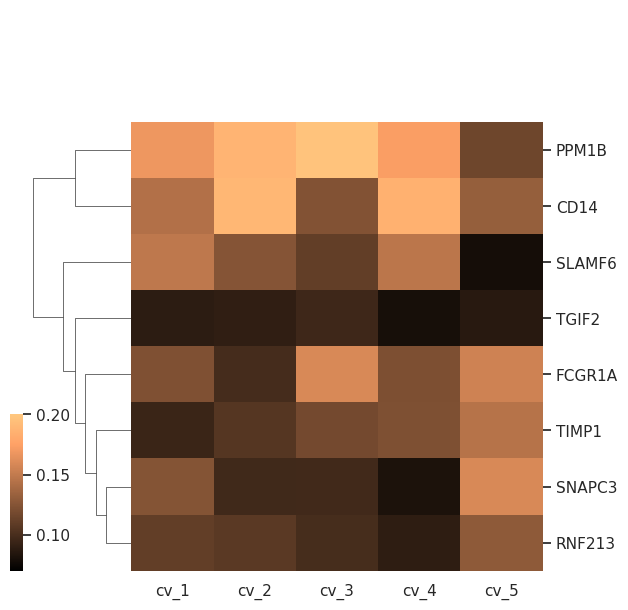

In [667]:
order = pd.DataFrame(feat_imp, columns=fb).mean(axis=0).sort_values(ascending=False).index
g = sns.clustermap(data=pd.DataFrame(feat_imp, columns=fb, index=['cv_'+str(i) for i in range(1,6)]).loc[:,order].T, col_cluster=False, figsize=(8.35*3/4,8.35*3/4), cmap='copper', z_score=None, cbar_pos=(0.0, 0.075, 0.02, 0.25),
                   cbar_kws={"orientation": "vertical"},vmin=0.07, vmax=.2)
g.savefig('./draft/FIG6C_rf_feat_import.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [663]:
auc_list = []
acc_list = []
f1s_list = []
metrics_df = []

for i,f1 in enumerate(y_sh_tr_true_list):
    auc_list.append( [roc_auc_score(y_sh_tr_true_list[i], y_sh_tr_predproba_list[i]), roc_auc_score(y_sh_ts_true_list[i], y_sh_ts_predproba_list[i])] )
    acc_list.append( [accuracy_score(y_sh_tr_true_list[i], y_sh_tr_pred_list[i]), accuracy_score(y_sh_ts_true_list[i],  y_sh_ts_pred_list[i])] )
    f1s_list.append( [f1_score(y_sh_tr_true_list[i],  y_sh_tr_pred_list[i]), f1_score(y_sh_ts_true_list[i],  y_sh_ts_pred_list[i])] )

for n,m in zip(['AUC','Accuracy','F1'],[auc_list,acc_list,f1s_list]):
    metrics_df.append(pd.DataFrame(auc_list, columns=['Train','Test']))
    metrics_df[-1]['Metric'] = n
    metrics_df[-1]['CV'] = range(1,6)
metrics_df = pd.concat(metrics_df)
metrics_df

Train      Test    Metric  CV
0  0.973937  0.806584       AUC   1
1  0.974280  0.724280       AUC   2
2  0.976423  0.691358       AUC   3
3  0.980538  0.736626       AUC   4
4  0.979938  0.584362       AUC   5
0  0.973937  0.806584  Accuracy   1
1  0.974280  0.724280  Accuracy   2
2  0.976423  0.691358  Accuracy   3
3  0.980538  0.736626  Accuracy   4
4  0.979938  0.584362  Accuracy   5
0  0.973937  0.806584        F1   1
1  0.974280  0.724280        F1   2
2  0.976423  0.691358        F1   3
3  0.980538  0.736626        F1   4
4  0.979938  0.584362        F1   5

In [578]:
from sklearn.metrics import RocCurveDisplay, auc

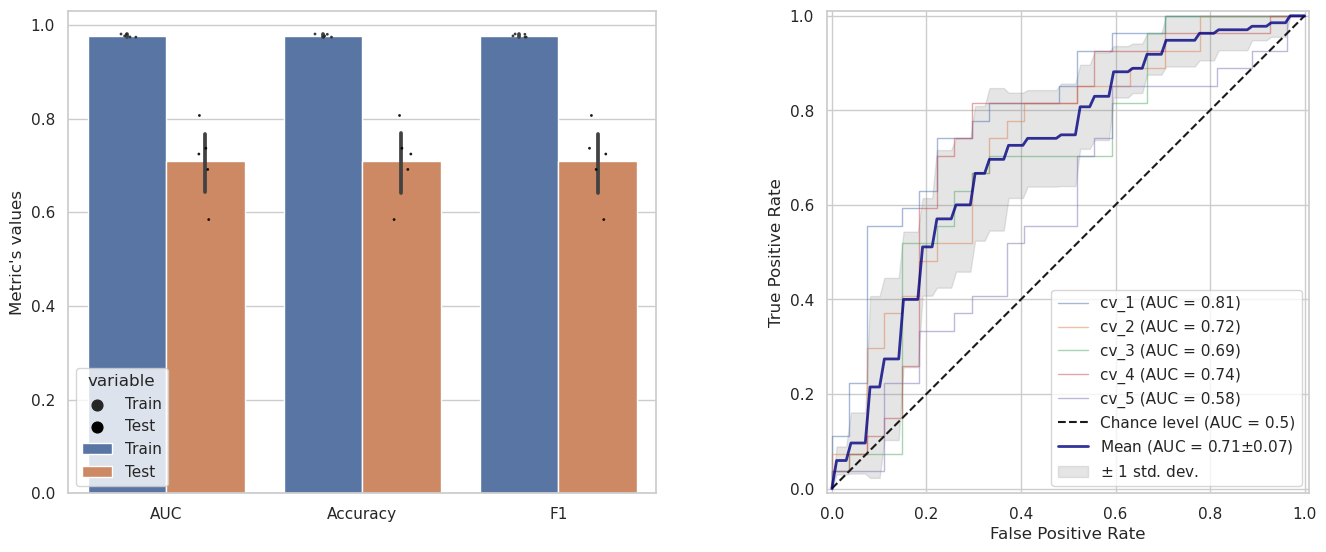

In [669]:
fig = plt.figure(figsize=(8.35*2,8.35*3/4))
ax_bar = fig.add_subplot(121)
sns.barplot(x='Metric', y='value',hue='variable', data=metrics_df.melt(id_vars = ['Metric','CV']), ax=ax_bar)
sns.stripplot(x='Metric', y='value',hue='variable', color='black', dodge=True, alpha=.9, s=2, data=metrics_df.melt(id_vars = ['Metric','CV']), ax=ax_bar)
ax_bar.set_xlabel('')
ax_bar.set_ylabel("Metric's values")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ax_roc = fig.add_subplot(122)

for i,y_true in enumerate(y_sh_ts_true_list):
    viz = RocCurveDisplay.from_predictions(y_true, y_sh_ts_predproba_list[i],
                                           name='cv_'+str(i+1), alpha=0.5, lw=1., ax=ax_roc, plot_chance_level=(i == 5 - 1))
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax_roc.plot(
    mean_fpr,
    mean_tpr,
    color="navy",
    label=r"Mean (AUC = %0.2f$\pm$%0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax_roc.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax_roc.legend(loc='lower right')

ax_roc.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    # title=f"Mean ROC curve with variability of\nfive cross-validations in rejection prediction",
)

fig.savefig('./draft/FIG6AB_rf_metrics.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [590]:
y_sh_ts_true_list

[]

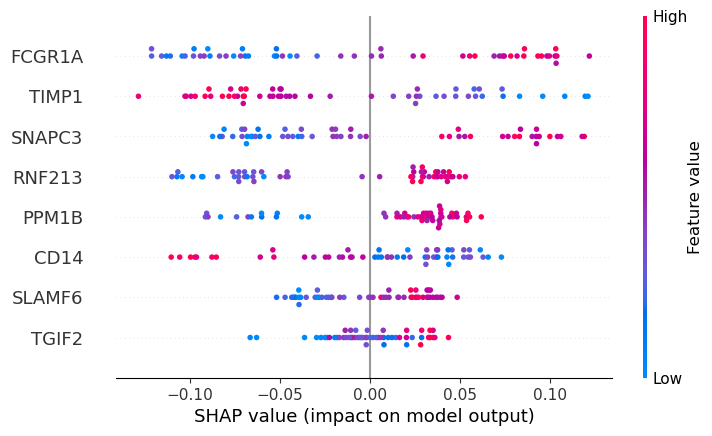

In [471]:
shap.plots.beeswarm(shap_values[..., 1], max_display=15)

In [672]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

In [474]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['royalblue','mediumvioletred','red'])
# matplotlib.cm.register_cmap("HKGcolormap", cmap)
# cpal = sns.color_palette("mycolormap", n_colors=64, desat=0.2)

In [689]:
# shap_values_list[0]

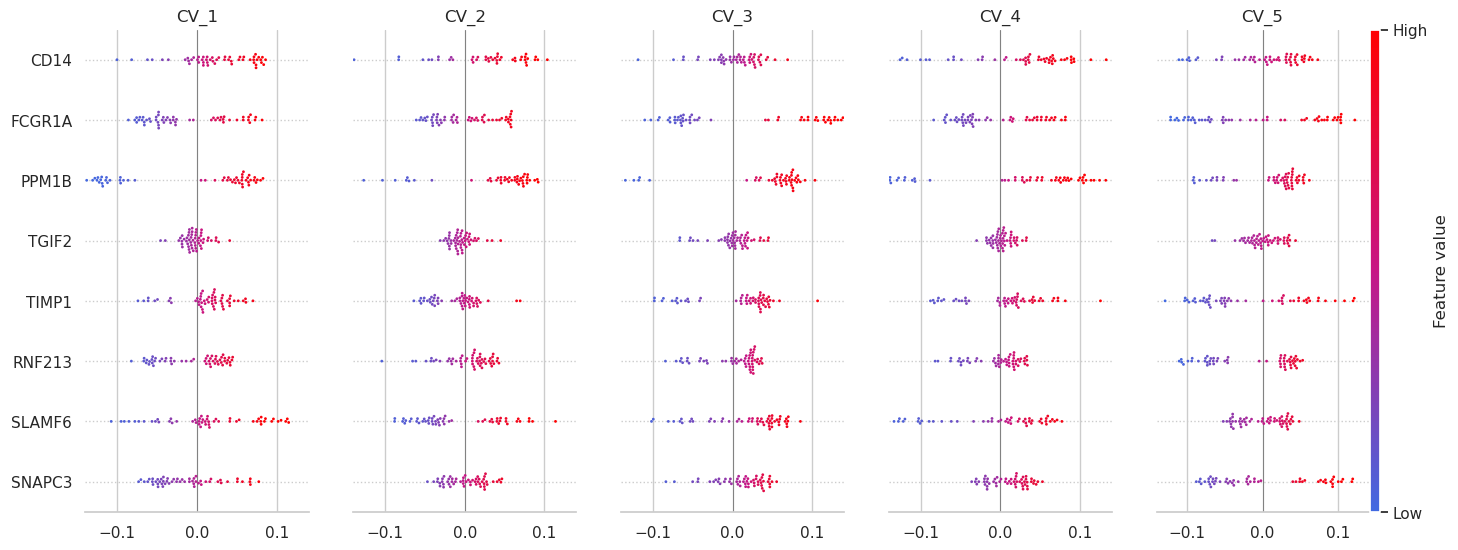

In [690]:
t1=time.time()
fig = plt.figure(figsize=(8.35*2,8.35*3/4))

for i,shp_v in enumerate(shap_values_list):
    
    if i == 0:
        ax_shp = fig.add_subplot(1,5,i+1)
    else:
        ax_shp = fig.add_subplot(1,5,i+1, sharex=ax_shp)
    
    data=pd.DataFrame(shp_v.values, columns=X.columns).melt()
    # data['ar'] = adata_ml[X_sh_ts_list[i].index,:].obs.ar.values.astype(int)
    # data = data.melt(id_vars='ar')
    
    
    norm = mpl.colors.Normalize(vmin=data['value'].min(), vmax=data['value'].max())
    
    # matplotlib.cm.register_cmap("mycolormap", cmap)
    # cpal = sns.color_palette("mycolormap", n_colors=64, desat=0.2)
    
    sns.swarmplot(y='Gene_name', x='value', hue='value', palette='HKGcolormap', s=2, data=data, ax=ax_shp)
    ax_shp.get_legend().remove()
    ax_shp.axvline(0, ls='-', lw=.7,color='gray')
    ax_shp.spines[['right', 'top','left']].set_visible(False)
    ax_shp.set_xlabel('')#SHAP value (impact on model output)')
    ax_shp.set_ylabel('')
    ax_shp.set_title('CV_'+str(i+1))  
    ax_shp.set_xlim([-.14, .14])
    if i > 0:
        ax_shp.set_yticklabels([])
        # ax.set_yticks([])

    ax_shp.grid(visible=True, axis='y', ls=':')
    # break
    if i==4:
        divider = make_axes_locatable(ax_shp)
        cax = divider.append_axes("right", size=.1, pad=.01)
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Feature value', cax=cax)
        cbar.outline.set_color(None)
        cbar.set_ticks([data['value'].min(),data['value'].max()], labels=['Low', 'High'])
# fig.tight_layout()
t2=time.time()
fig.savefig('./draft/FIG6D_shap_swarm.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [698]:
print(y_sh_ts_predproba_list[0].argmax(), y_sh_ts_predproba_list[0].argmin())
print(y_sh_ts_true_list[0][31], y_sh_ts_pred_list[0][31], y_sh_ts_true_list[0][14], y_sh_ts_pred_list[0][14])

31 14
1 1 0 0


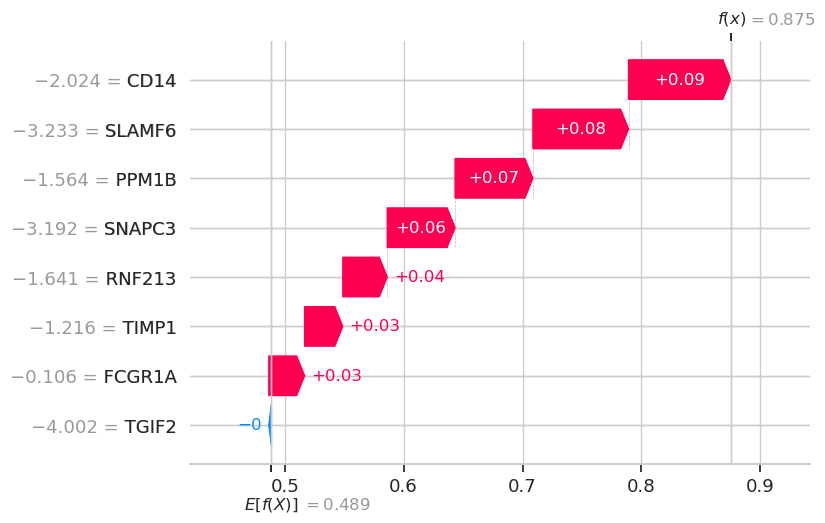

In [730]:
# fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][31], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_best1.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [710]:
ax

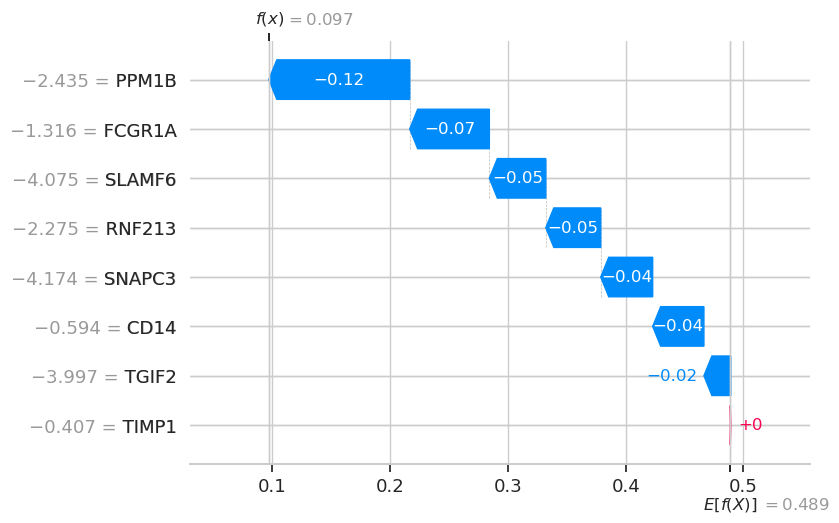

In [731]:
# fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][14], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_best0.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [700]:
y_sh_ts_predproba_list[0]

array([0.22016731, 0.36509819, 0.2167698 , 0.56764505, 0.51578697,
       0.78990694, 0.51180182, 0.31491585, 0.24538436, 0.4699218 ,
       0.25318815, 0.18957601, 0.42142273, 0.13322246, 0.09704297,
       0.35792698, 0.3760056 , 0.55915983, 0.54137266, 0.34358515,
       0.65716685, 0.41337975, 0.47490353, 0.39054978, 0.17513058,
       0.5698862 , 0.43356851, 0.47198226, 0.83736862, 0.38894761,
       0.58623154, 0.87515301, 0.52172792, 0.56260827, 0.3625853 ,
       0.57434586, 0.40071572, 0.25396238, 0.52276781, 0.55087778,
       0.69227811, 0.494333  , 0.65676316, 0.53999523, 0.57929504,
       0.59358906, 0.67624013, 0.68086515, 0.64162988, 0.38790542,
       0.5853986 , 0.62938139, 0.62404259, 0.84486357])

In [705]:
for i,(t,p) in enumerate(zip(y_sh_ts_true_list[0],y_sh_ts_pred_list[0])):
    if t!=p:
        print(i, y_sh_ts_true_list[0][i],y_sh_ts_pred_list[0][i],y_sh_ts_predproba_list[0][i])

3 0 1 0.5676450529518643
4 0 1 0.5157869749789254
5 0 1 0.789906940677142
6 0 1 0.5118018185246128
17 0 1 0.5591598259111032
18 0 1 0.5413726640963099
20 0 1 0.657166850633027
25 0 1 0.5698862012686319
27 1 0 0.471982260266393
29 1 0 0.3889476107655672
34 1 0 0.3625853008532568
36 1 0 0.40071572176963016
37 1 0 0.2539623774101714
41 1 0 0.4943329995511882
49 1 0 0.38790542245422244


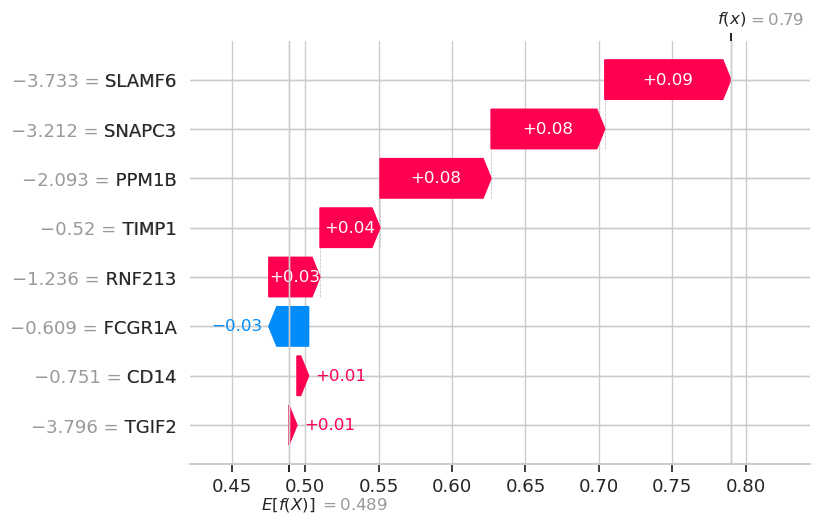

In [720]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][5], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_worst01.pdf', bbox_inches='tight', format='pdf', dpi=300)

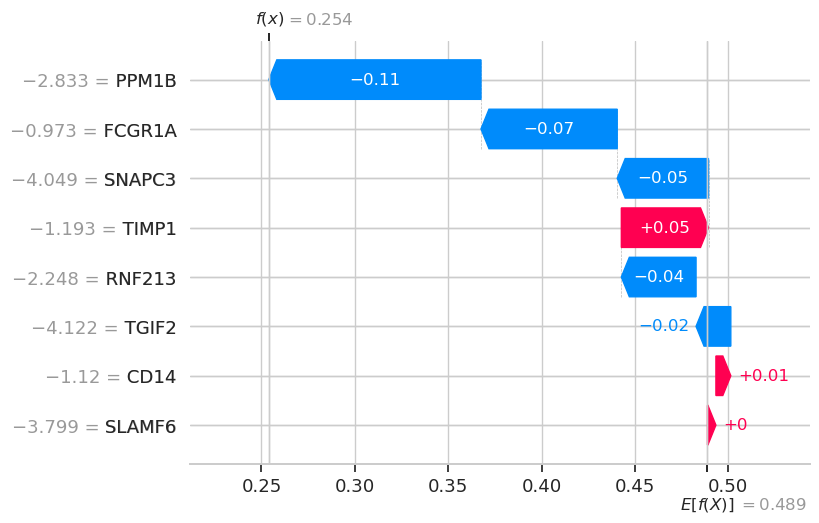

In [724]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][37], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_worst10.pdf', bbox_inches='tight', format='pdf', dpi=300)

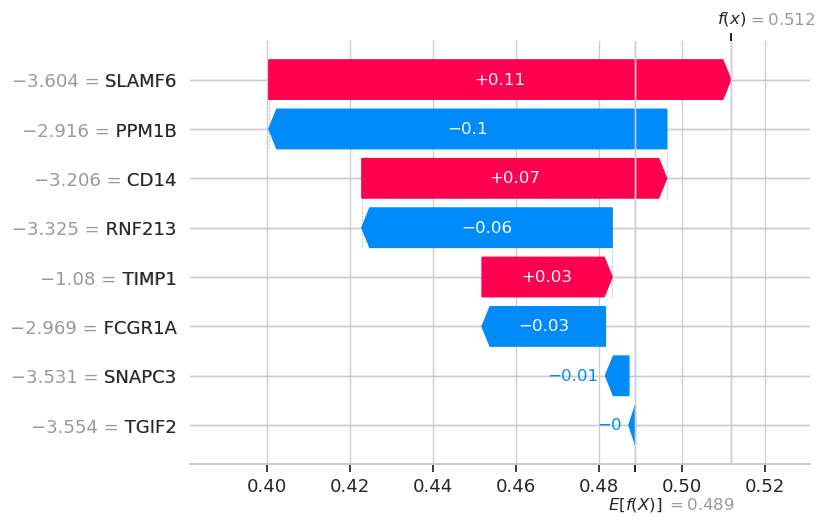

In [728]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][6], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_doubt01.pdf', bbox_inches='tight', format='pdf', dpi=300)

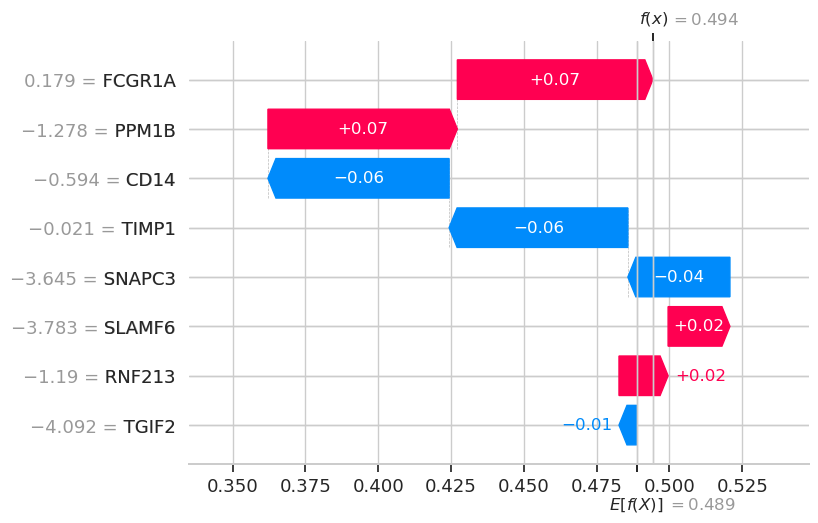

In [729]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][41], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_doubt10.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [732]:
for i,(t,p) in enumerate(zip(y_sh_ts_true_list[0],y_sh_ts_pred_list[0])):
    if t==p:
        print(i, y_sh_ts_true_list[0][i],y_sh_ts_pred_list[0][i],y_sh_ts_predproba_list[0][i])

0 0 0 0.22016731387377636
1 0 0 0.36509819139408856
2 0 0 0.2167697988415093
7 0 0 0.314915853182765
8 0 0 0.2453843628249977
9 0 0 0.46992179753940594
10 0 0 0.2531881457852433
11 0 0 0.1895760119782178
12 0 0 0.4214227260097998
13 0 0 0.13322246321789669
14 0 0 0.0970429692039986
15 0 0 0.35792697820325475
16 0 0 0.37600560141612804
19 0 0 0.34358514514381383
21 0 0 0.4133797530900474
22 0 0 0.47490352840743677
23 0 0 0.39054978224819525
24 0 0 0.17513057778994315
26 0 0 0.433568513031516
28 1 1 0.837368617330382
30 1 1 0.5862315372879614
31 1 1 0.8751530140611024
32 1 1 0.5217279169360053
33 1 1 0.5626082675107836
35 1 1 0.5743458563194633
38 1 1 0.5227678075794165
39 1 1 0.5508777760122574
40 1 1 0.692278109351949
42 1 1 0.6567631604377742
43 1 1 0.5399952322746061
44 1 1 0.5792950448459357
45 1 1 0.5935890637742037
46 1 1 0.6762401337568519
47 1 1 0.6808651465837227
48 1 1 0.6416298829223748
50 1 1 0.5853986015532456
51 1 1 0.6293813877728749
52 1 1 0.6240425880320233
53 1 1 0.844

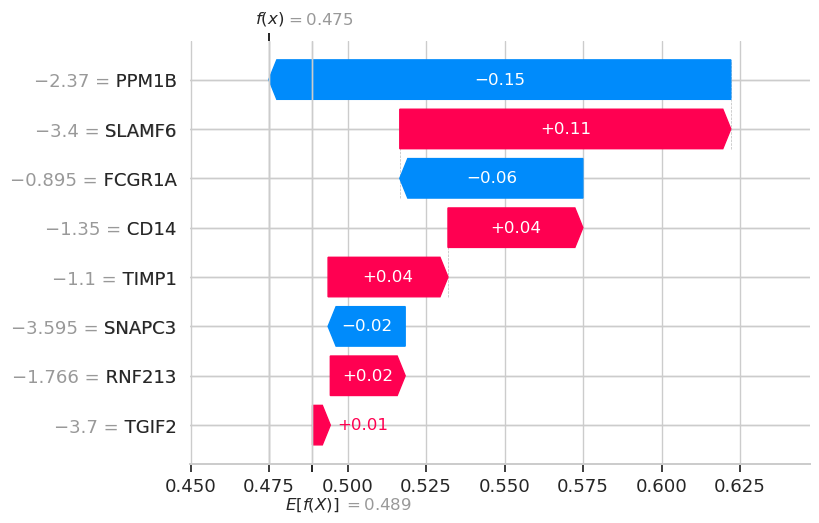

In [736]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][22], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_doubt00.pdf', bbox_inches='tight', format='pdf', dpi=300)

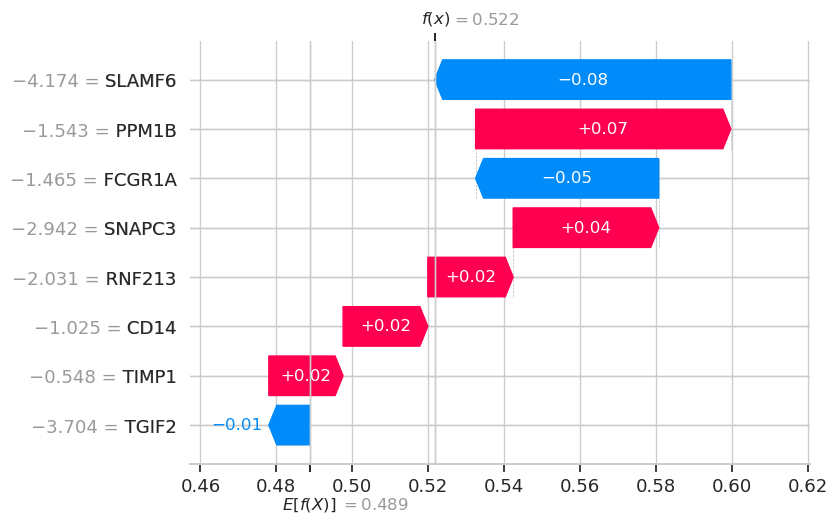

In [740]:
fig = plt.figure(figsize=(8.35,8.35/2))
shap.plots.waterfall(shap_values_list[0][32], max_display=15, show=True)
# plt.savefig('./draft/FIG6E_shap_doubt11.pdf', bbox_inches='tight', format='pdf', dpi=300)

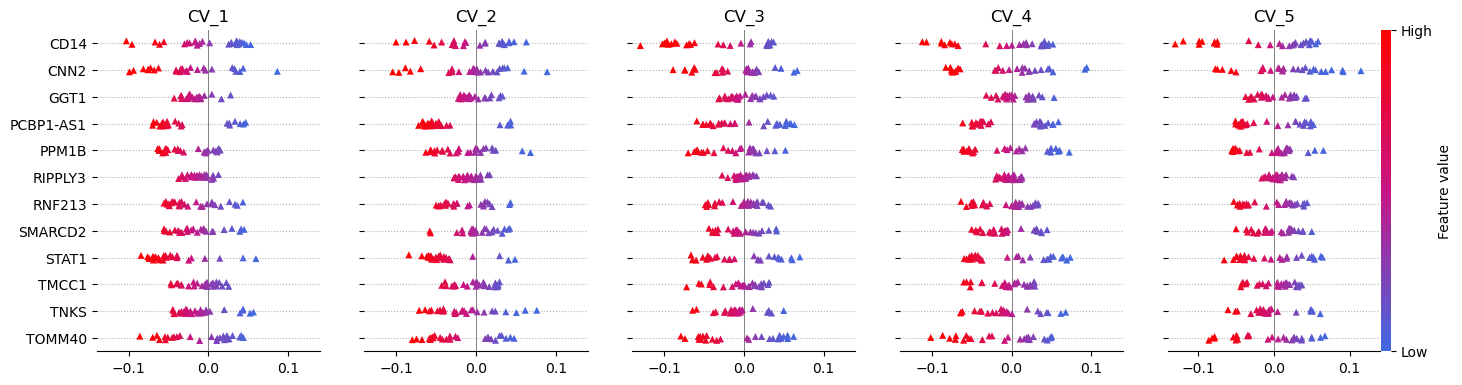

In [1087]:
t1=time.time()
fig = plt.figure(figsize=(8.35*2,8.35/2))

for i,shp_v in enumerate(shap_values_list):
    
    if i == 0:
        ax = fig.add_subplot(1,5,i+1)
    else:
        ax = fig.add_subplot(1,5,i+1, sharex=ax)
    
    data=pd.DataFrame(shp_v.values, columns=rf.feature_names_in_)
    data['ar'] = adata_ml[X_sh_ts_list[i].index,:].obs.ar.values.astype(int)
    data = data.melt(id_vars='ar')
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['royalblue','mediumvioletred','red'])
    norm = mpl.colors.Normalize(vmin=data['value'].min(), vmax=data['value'].max())
    
    # matplotlib.cm.register_cmap("mycolormap", cmap)
    # cpal = sns.color_palette("mycolormap", n_colors=64, desat=0.2)
    
    sns.stripplot(y='variable', x='value', hue='value', marker='^', palette='mycolormap', s=5, data=data[data.ar==0], ax=ax)
    # sns.stripplot(y='variable', x='value', hue='value', marker='v', palette='mycolormap', s=5, data=data[data.ar==1], ax=ax)
    ax.get_legend().remove()
    ax.axvline(0, ls='-', lw=.7,color='gray')
    ax.spines[['right', 'top','left']].set_visible(False)
    ax.set_xlabel('')#SHAP value (impact on model output)')
    ax.set_ylabel('')
    ax.set_title('CV_'+str(i+1))  
    ax.set_xlim([-.14, .14])
    if i > 0:
        ax.set_yticklabels([])
        # ax.set_yticks([])

    ax.grid(visible=True, axis='y', ls=':')
    # break
    if i==4:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=.1, pad=.01)
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Feature value', cax=cax)
        cbar.outline.set_color(None)
        cbar.set_ticks([data['value'].min(),data['value'].max()], labels=['Low', 'High'])
# fig.tight_layout()
t2=time.time()

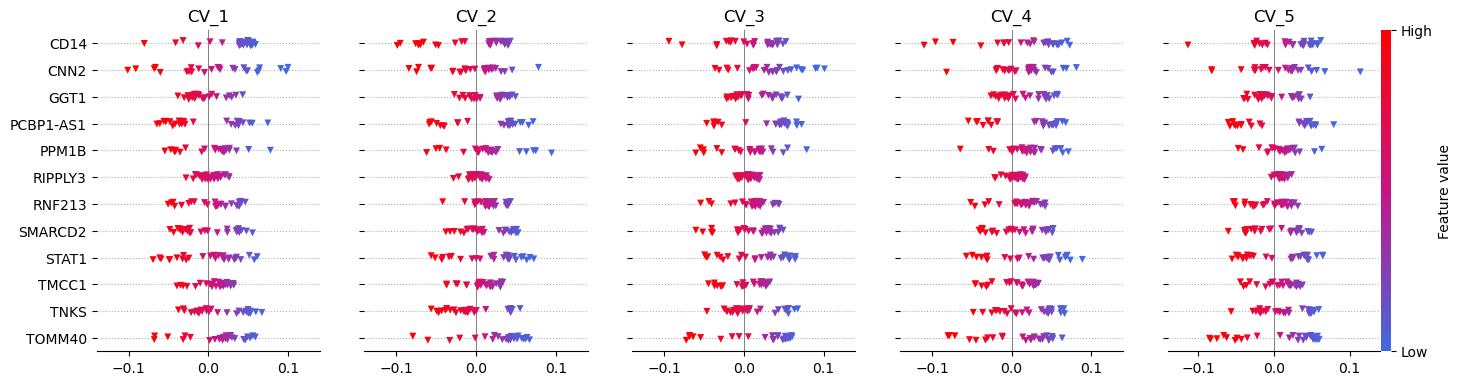

In [1088]:
t1=time.time()
fig = plt.figure(figsize=(8.35*2,8.35/2))

for i,shp_v in enumerate(shap_values_list):
    
    if i == 0:
        ax = fig.add_subplot(1,5,i+1)
    else:
        ax = fig.add_subplot(1,5,i+1, sharex=ax)
    
    data=pd.DataFrame(shp_v.values, columns=rf.feature_names_in_)
    data['ar'] = adata_ml[X_sh_ts_list[i].index,:].obs.ar.values.astype(int)
    data = data.melt(id_vars='ar')
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['royalblue','mediumvioletred','red'])
    norm = mpl.colors.Normalize(vmin=data['value'].min(), vmax=data['value'].max())
    
    # matplotlib.cm.register_cmap("mycolormap", cmap)
    # cpal = sns.color_palette("mycolormap", n_colors=64, desat=0.2)
    
    # sns.stripplot(y='variable', x='value', hue='value', marker='^', palette='mycolormap', s=5, data=data[data.ar==0], ax=ax)
    sns.stripplot(y='variable', x='value', hue='value', marker='v', palette='mycolormap', s=5, data=data[data.ar==1], ax=ax)
    ax.get_legend().remove()
    ax.axvline(0, ls='-', lw=.7,color='gray')
    ax.spines[['right', 'top','left']].set_visible(False)
    ax.set_xlabel('')#SHAP value (impact on model output)')
    ax.set_ylabel('')
    ax.set_title('CV_'+str(i+1))  
    ax.set_xlim([-.14, .14])
    if i > 0:
        ax.set_yticklabels([])
        # ax.set_yticks([])

    ax.grid(visible=True, axis='y', ls=':')
    # break
    if i==4:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size=.1, pad=.01)
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Feature value', cax=cax)
        cbar.outline.set_color(None)
        cbar.set_ticks([data['value'].min(),data['value'].max()], labels=['Low', 'High'])
# fig.tight_layout()
t2=time.time()

In [1085]:
print(int((t2-t1)//60),((t2-t1)%60), sep=':')

2:44.669411420822144


In [1080]:
data=pd.DataFrame(shp_v.values, columns=rf.feature_names_in_)
data['ar'] = adata_ml[X_sh_ts_list[i].index,:].obs.ar.values.astype(int)
data = data.melt(id_vars='ar')
data

ar variable     value
0     0     CD14 -0.130277
1     0     CD14  0.046850
2     0     CD14 -0.004901
3     0     CD14 -0.078814
4     0     CD14  0.058349
..   ..      ...       ...
643   1   TOMM40 -0.042883
644   1   TOMM40 -0.084959
645   1   TOMM40  0.059803
646   1   TOMM40  0.038765
647   1   TOMM40  0.051897

[648 rows x 3 columns]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1042]:
[data['value'].min(),data['value'].max()],['Low','High']

([-0.13027672277943647, 0.11489911082946912], ['Low', 'High'])

In [1045]:
cbar.set_ticks([data['value'].min(),data['value'].max()],['Low','High'])

TypeError: Colorbar.set_ticks() takes 2 positional arguments but 3 were given

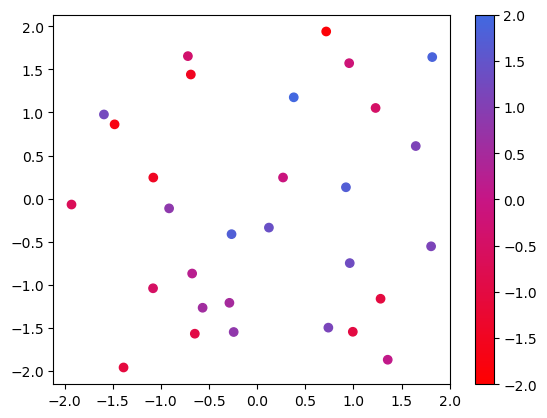

In [1019]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red",'mediumvioletred',"royalblue"])

plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [999]:
# define our colors using Lch
# note that we intentionally vary the lightness during interpolation so as to better
# enable the eye to see patterns (since patterns are most easily recognized through
# lightness variability)
blue_lch = [54.0, 70.0, 4.6588]
l_mid = 40.0
red_lch = [54.0, 90.0, 0.35470565 + 2 * np.pi]
gray_lch = [55.0, 0.0, 0.0]
blue_rgb = lch2rgb(blue_lch)
red_rgb = lch2rgb(red_lch)
gray_rgb = lch2rgb(gray_lch)
white_rgb = np.array([1.0, 1.0, 1.0])

light_blue_rgb = np.array([127.0, 196, 252]) / 255
light_red_rgb = np.array([255.0, 127, 167]) / 255

# define a perceptually uniform color scale using the Lch color space
reds = []
greens = []
blues = []
alphas = []
nsteps = 100
l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps // 2)) + list(np.linspace(l_mid, red_lch[0], nsteps // 2))
c_vals = np.linspace(blue_lch[1], red_lch[1], nsteps)
h_vals = np.linspace(blue_lch[2], red_lch[2], nsteps)
for pos, l, c, h in zip(np.linspace(0, 1, nsteps), l_vals, c_vals, h_vals):  # noqa: E741
    lch = [l, c, h]
    rgb = lch2rgb(lch)
    reds.append((pos, rgb[0], rgb[0]))
    greens.append((pos, rgb[1], rgb[1]))
    blues.append((pos, rgb[2], rgb[2]))
    alphas.append((pos, 1.0, 1.0))

red_blue = LinearSegmentedColormap("red_blue", {"red": reds, "green": greens, "blue": blues, "alpha": alphas})
red_blue.set_bad(gray_rgb, 1.0)
red_blue.set_over(gray_rgb, 1.0)
red_blue.set_under(gray_rgb, 1.0)  # "under" is incorrectly used instead of "bad" in the scatter plot

NameError: name 'lch2rgb' is not defined

In [339]:
i = 0
train = []
test = []
for tr, ts in outer_cv.split(X, y):
    train.append(tr)
    test.append(ts)
    # break

In [340]:
y_sh_tr = hkg.mining.balance_resample(y_var=y[tr], sample_size=None )
X_sh_tr = X.iloc[tr, :].iloc[y_sh_tr,:]
print(y_sh_tr.shape)

(216,)


In [341]:
y_sh_ts = hkg.mining.balance_resample(y_var=y[ts], sample_size=None )
X_sh_ts = X.iloc[ts,:].iloc[y_sh_ts,:]
print(y_sh_ts.shape)

(54,)


In [342]:
rf.fit(X_sh_tr, y[tr][y_sh_tr].astype(int))

RandomForestClassifier(class_weight='balanced', max_features=5,
                       min_samples_leaf=5, n_estimators=1000, oob_score=True,
                       random_state=42)

In [343]:
y_sh_tr_true = y[tr][y_sh_tr].astype(int)
y_sh_tr_pred = rf.predict(X_sh_tr)
y_sh_tr_predproba = rf.predict_proba(X_sh_tr)

y_sh_ts_true = y[ts][y_sh_ts].astype(int)
y_sh_ts_pred = rf.predict(X_sh_ts)
y_sh_ts_predproba = rf.predict_proba(X_sh_ts)

In [344]:
roc_auc_score(y_sh_tr_true, y_sh_tr_predproba[:, 1]), roc_auc_score(y_sh_ts_true, y_sh_ts_predproba[:, 1])
accuracy_score(y_sh_tr_true, y_sh_tr_pred), accuracy_score(y_sh_ts_true, y_sh_ts_pred)
f1_score(y_sh_tr_true, y_sh_tr_pred), f1_score(y_sh_ts_true, y_sh_ts_pred)

(0.9790809327846365, 0.5802469135802469)

(0.8981481481481481, 0.5555555555555556)

(0.9, 0.5384615384615384)

In [321]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [322]:
confusion_matrix(y_sh_tr_true, y_sh_tr_pred)

array([[95, 13],
       [ 9, 99]])

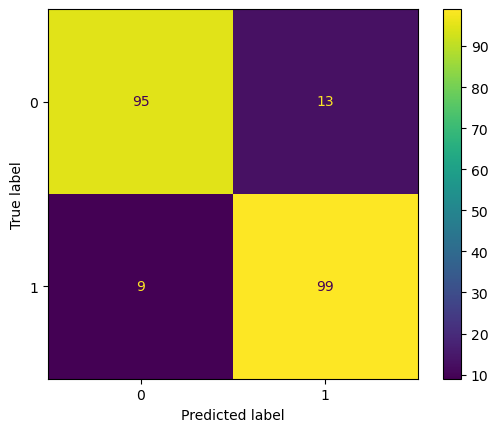

In [323]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_sh_tr_true, y_sh_tr_pred))#, normalize='true'))
disp.plot()

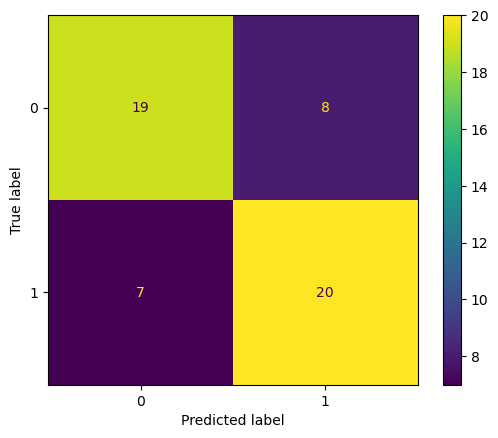

In [324]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_sh_ts_true, y_sh_ts_pred))#, normalize='true'))
disp.plot()

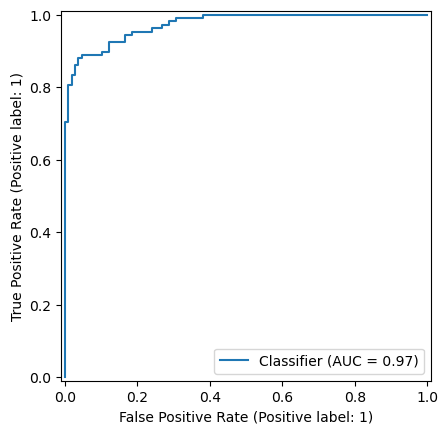

In [325]:
RocCurveDisplay.from_predictions(y_sh_tr_true, y_sh_tr_predproba[:, 1])

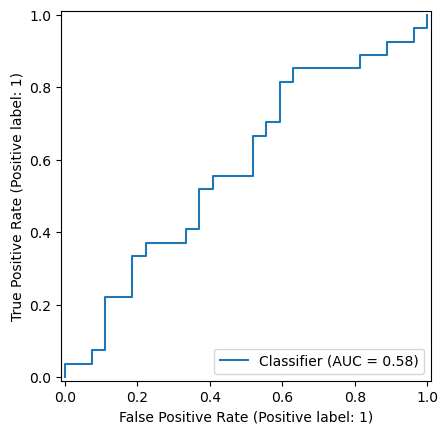

In [556]:
RocCurveDisplay.from_predictions(y_sh_ts_true, y_sh_ts_predproba[:, 1])

In [557]:
y_sh_ts_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Shapley: feature importance

In [327]:
import shap

In [347]:
t1=time.time()
explainer = shap.explainers.Exact(rf.predict_proba, X_sh_tr)
shap_values = explainer(X_sh_ts)
shap_values = shap_values[..., 1]
t2=time.time()
print(int((t2-t1)//60),((t2-t1)%60), sep=':')

ExactExplainer explainer: 55it [00:16,  1.27it/s]                                                                                                                             

0:16.50180435180664


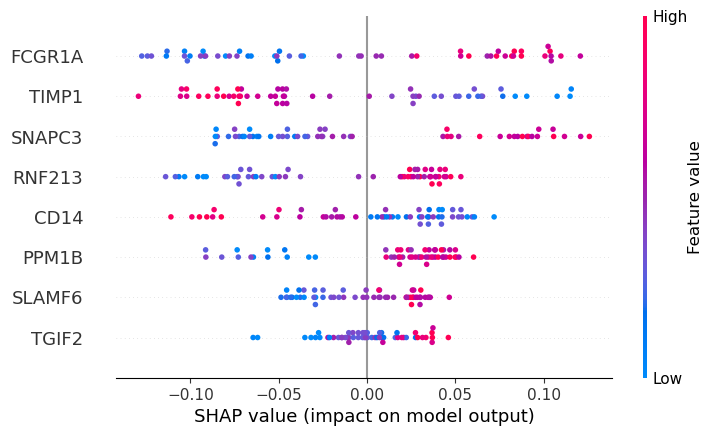

In [348]:
shap.plots.beeswarm(shap_values, max_display=15)#, color_bar=['#00224e', '#67000d'], color_bar_label=['Rejection' , 'Nr' ])

In [330]:
y_sh_ts_predict = rf.predict(X_sh_ts)
y_sh_ts_predict

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [331]:
y_sh_ts_true = adata_ml[ts,:][y_sh_ts,:].obs.ar.astype(int).values
y_sh_ts_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [961]:
true0_pred0 = []
true1_pred1 = []
true0_pred1 = []
true1_pred0 = []

for i, (t,p) in enumerate(zip(y_sh_ts_true, y_sh_ts_predict)):
    if (t==0) and (p==0):
        true0_pred0.append(i)
    elif (t==1) and (p==1):
        true1_pred1.append(i)
    elif (t==0) and (p==1):
        true0_pred1.append(i)
    elif (t==1) and (p==0):
        true1_pred0.append(i)

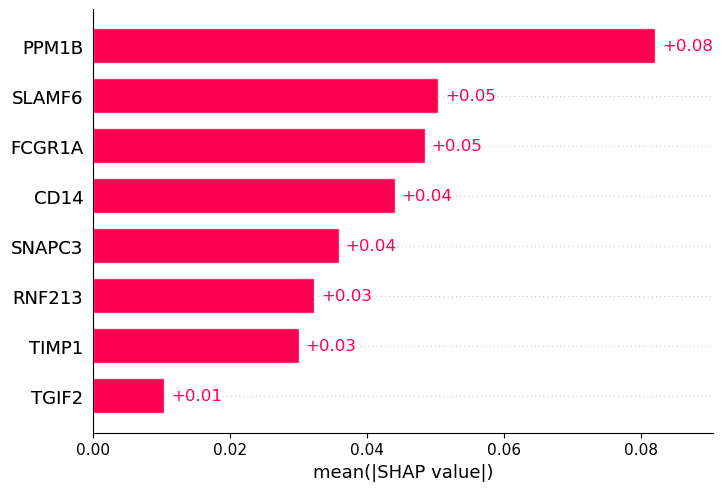

In [333]:
shap.plots.bar(shap_values, max_display=15)

In [974]:
np.abs(shap_values.values).mean(axis=0).round(2)

array([0.05, 0.04, 0.02, 0.04, 0.02, 0.01, 0.03, 0.03, 0.04, 0.02, 0.03,
       0.05])

In [968]:
# fig = plt.figure(figsize=(15,5))
# ax_all = fig.add_subplot(151)
# ax_0 = fig.add_subplot(152)
# ax_1 = fig.add_subplot(153)
# shap.plots.bar(shap_values, max_display=15, ax=ax_all)
# shap.plots.bar(shap_values[true0_pred0], max_display=15, ax=ax_0)
# shap.plots.bar(shap_values, max_display=15, ax=ax_1)
# shap.plots.bar(shap_values, max_display=15, ax=ax_all)
# shap.plots.bar(shap_values, max_display=15, ax=ax_all)


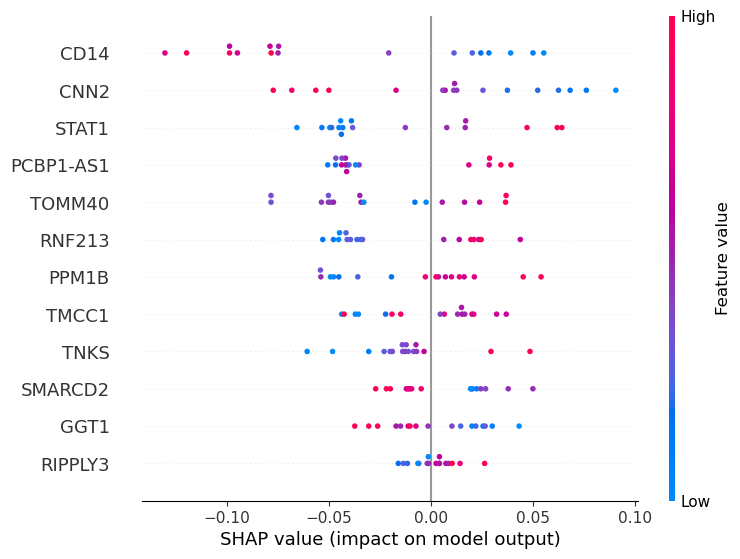

In [966]:
shap.plots.beeswarm(shap_values[true0_pred0], max_display=15)

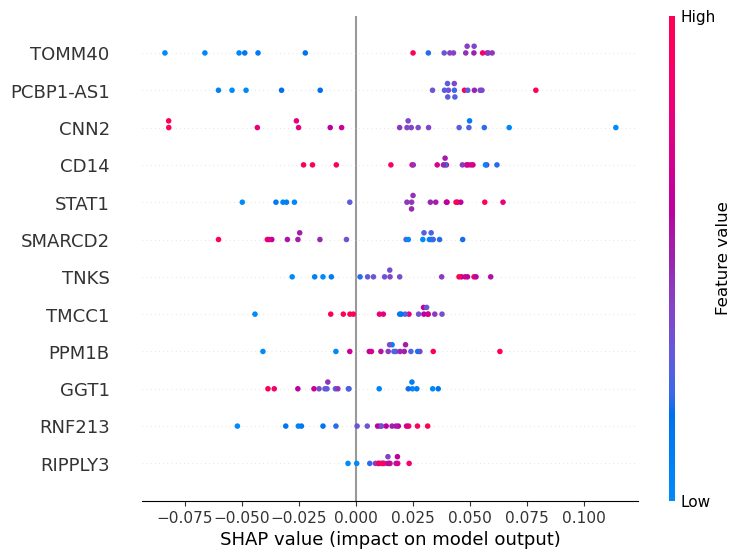

In [967]:
shap.plots.beeswarm(shap_values[true1_pred1], max_display=15)

ExactExplainer explainer: 55it [01:55,  2.32s/it]                                                                                                                             


In [786]:
shap_values.data = np.round(shap_values.data, 2)

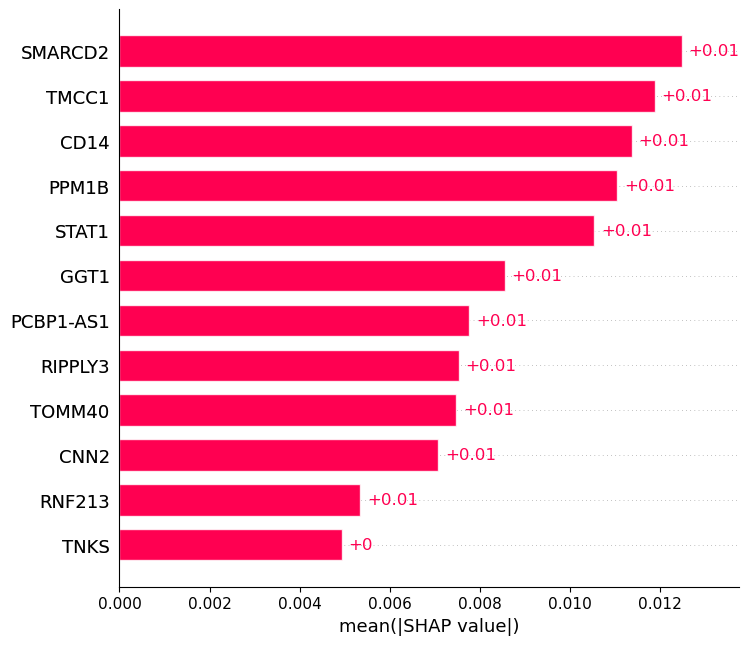

In [852]:
shap.plots.bar(shap_values, max_display=15)

In [819]:
len([int(y_) for y_ in y[ts][y_sh_ts]])

54

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

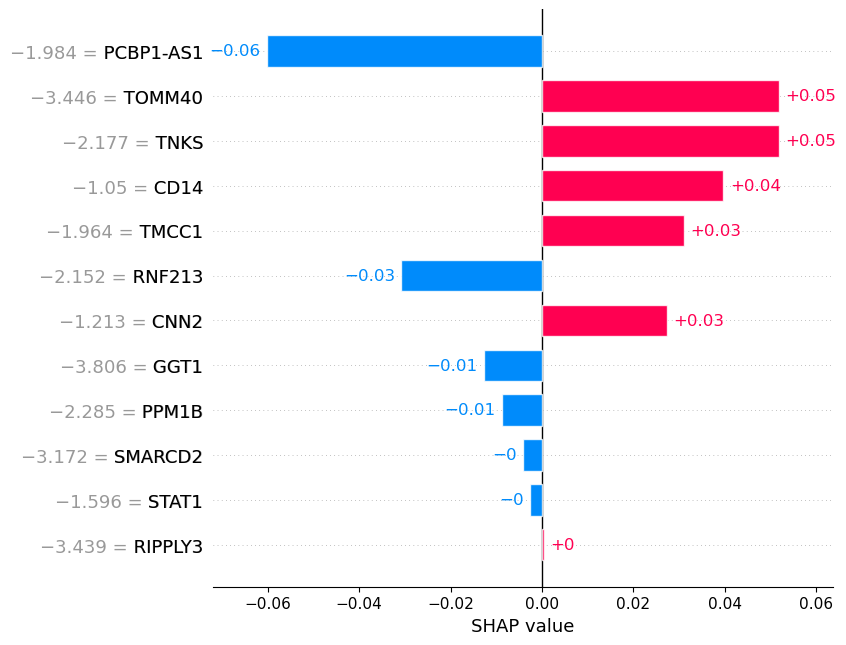

In [975]:
shap.plots.bar(shap_values[-1], max_display=15)

In [349]:
 rf.predict_proba(X_sh_ts)

array([[0.39357887, 0.60642113],
       [0.20543989, 0.79456011],
       [0.53058365, 0.46941635],
       [0.72038733, 0.27961267],
       [0.38910352, 0.61089648],
       [0.17315227, 0.82684773],
       [0.72242387, 0.27757613],
       [0.42679834, 0.57320166],
       [0.82088349, 0.17911651],
       [0.56739645, 0.43260355],
       [0.52813707, 0.47186293],
       [0.73807216, 0.26192784],
       [0.77960859, 0.22039141],
       [0.40806952, 0.59193048],
       [0.22258273, 0.77741727],
       [0.76950671, 0.23049329],
       [0.43742159, 0.56257841],
       [0.48898376, 0.51101624],
       [0.80682945, 0.19317055],
       [0.34451137, 0.65548863],
       [0.73988831, 0.26011169],
       [0.74982621, 0.25017379],
       [0.75308142, 0.24691858],
       [0.66902948, 0.33097052],
       [0.62401913, 0.37598087],
       [0.87144073, 0.12855927],
       [0.36266666, 0.63733334],
       [0.3382697 , 0.6617303 ],
       [0.60319621, 0.39680379],
       [0.43780875, 0.56219125],
       [0.

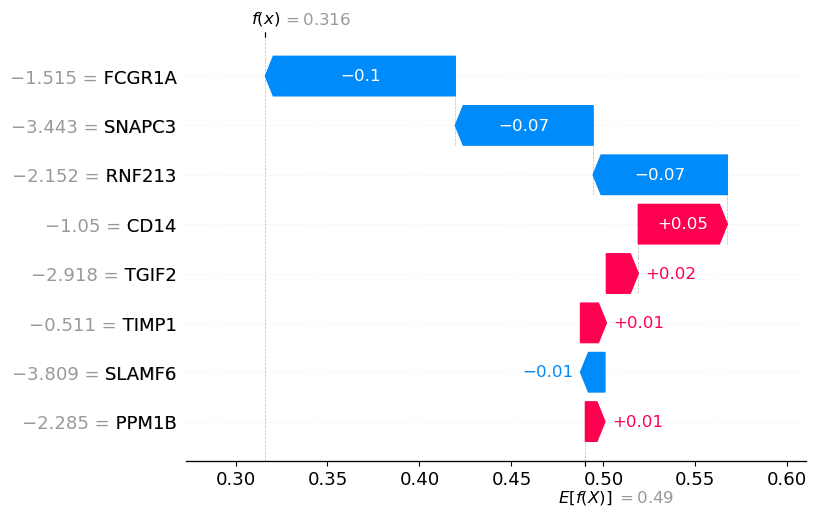

In [350]:
shap.plots.waterfall(shap_values[-1], max_display=15)

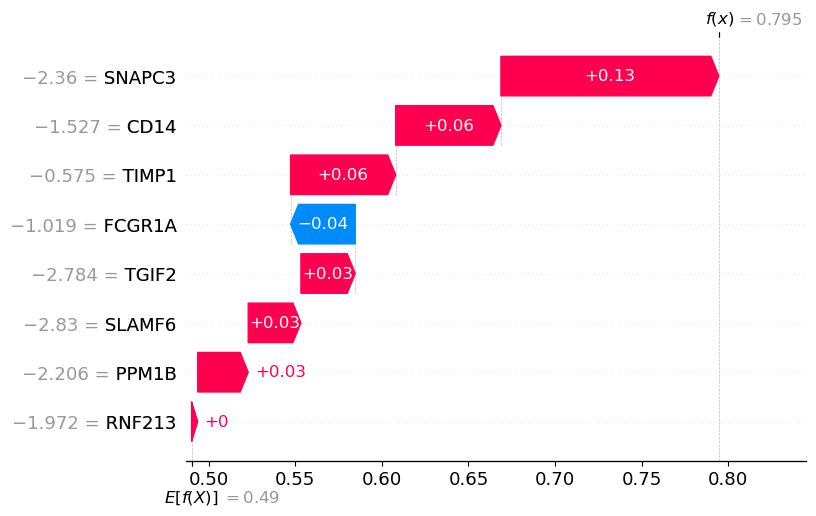

In [351]:
shap.plots.waterfall(shap_values[1], max_display=15)

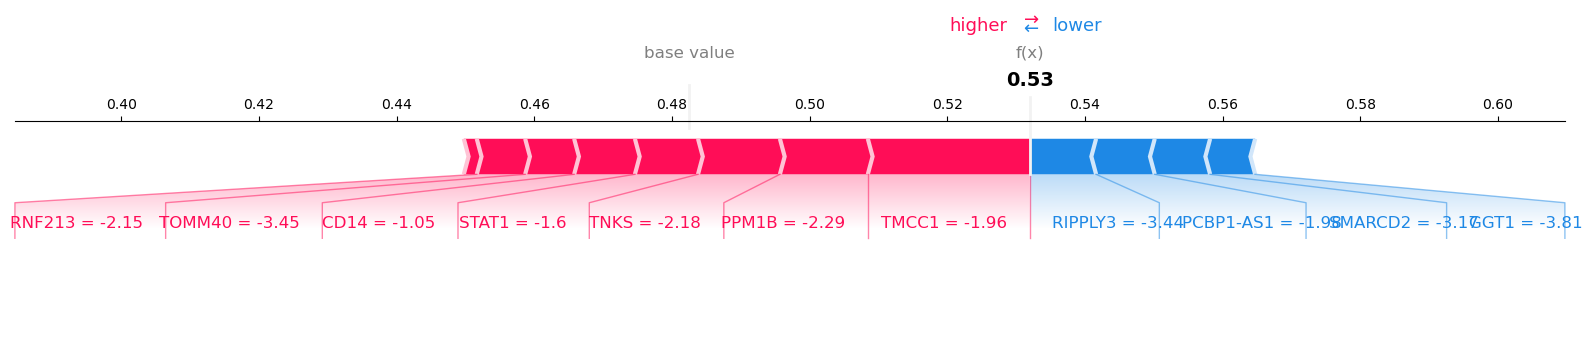

In [796]:
shap.plots.force(shap_values[-1], matplotlib=True, text_rotation=0)

In [774]:
print(rf.predict_proba(X_sh_ts)), print(rf.predict(X_sh_ts))

[[0.53778431 0.46221569]
 [0.49179574 0.50820426]
 [0.53576808 0.46423192]
 [0.61076162 0.38923838]
 [0.49676177 0.50323823]
 [0.48367745 0.51632255]
 [0.52499072 0.47500928]
 [0.57833818 0.42166182]
 [0.54029027 0.45970973]
 [0.53334578 0.46665422]
 [0.54877692 0.45122308]
 [0.59135548 0.40864452]
 [0.59966305 0.40033695]
 [0.57963493 0.42036507]
 [0.53141763 0.46858237]
 [0.56249937 0.43750063]
 [0.52003088 0.47996912]
 [0.5407048  0.4592952 ]
 [0.5440893  0.4559107 ]
 [0.50983528 0.49016472]
 [0.55183038 0.44816962]
 [0.53082123 0.46917877]
 [0.53306882 0.46693118]
 [0.51274627 0.48725373]
 [0.62626552 0.37373448]
 [0.60607213 0.39392787]
 [0.52427521 0.47572479]
 [0.44988405 0.55011595]
 [0.53069603 0.46930397]
 [0.47210721 0.52789279]
 [0.42263195 0.57736805]
 [0.5028636  0.4971364 ]
 [0.48358789 0.51641211]
 [0.48149769 0.51850231]
 [0.44481679 0.55518321]
 [0.48358979 0.51641021]
 [0.49187383 0.50812617]
 [0.46479913 0.53520087]
 [0.50231647 0.49768353]
 [0.47089913 0.52910087]


(None, None)

In [773]:
shap_values[0]

.values =
array([-0.0346393 ,  0.00185965, -0.00654185,  0.01141487,  0.0160409 ,
        0.00709569, -0.00219266, -0.0080468 ,  0.00910535, -0.00426653,
       -0.00168793, -0.00843768])

.base_values =
0.4825119974502736

.data =
array([-0.16845319, -1.01550209, -3.80067809, -1.14190604, -1.43973679,
       -2.60394013, -1.77907262, -3.12959069, -1.38230897, -1.35636203,
       -3.9834386 , -3.74579765])

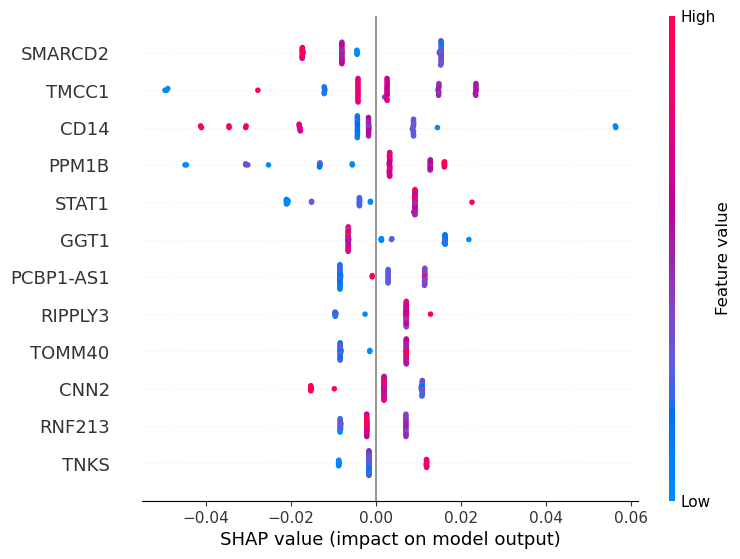

In [744]:
shap_values

.values =
array([[-0.0346393 ,  0.00185965, -0.00654185,  0.01141487,  0.0160409 ,
         0.00709569, -0.00219266, -0.0080468 ,  0.00910535, -0.00426653,
        -0.00168793, -0.00843768],
       [-0.0043915 ,  0.01090007, -0.00655245, -0.00090589,  0.0127669 ,
         0.00712958,  0.007036  , -0.01740042, -0.00391549,  0.00200708,
         0.01189966,  0.00711871],
       [-0.00178035,  0.00185721, -0.00654448,  0.00282398, -0.03067921,
         0.00710234,  0.00701013, -0.00805648,  0.00911844,  0.00257173,
        -0.00879411,  0.00709072],
       [-0.01782374,  0.01062255,  0.0036294 , -0.00837942, -0.03019245,
         0.00695688, -0.00830433,  0.01495717, -0.02073858, -0.04927929,
        -0.00166746,  0.00694565],
       [-0.00439899,  0.01089365,  0.01626567, -0.00853303,  0.00319809,
         0.00712992, -0.00847054,  0.01533693, -0.00391467, -0.01221889,
        -0.00168138,  0.00711948],
       [ 0.00882451,  0.01090112, -0.00655005, -0.00090331,  0.00320397,
         0.0

In [591]:
i = 0
error = []
for l,p in zip(y,rf.predict(X_sh)):
    if l!=p:
        error.append(i)
    i+=1

/mnt/d/hkg_wsl_env/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [622]:
# adata_ml[error,:].obs#.groupby(['abmrh','tcmr']).count().sort_values('outliers_hdbscan')

In [574]:
med = np.median(X_sh, axis=0).reshape((1, X_sh.shape[1]))

In [575]:
med

array([[-0.95414079, -1.05258545, -3.66165536, -1.69318735, -2.05034823,
        -3.3534552 , -1.91672217, -3.14837949, -1.60574351, -1.82504681,
        -3.91108924, -3.64556602]])

In [576]:

# 

# # get just the explanations for the positive class
# shap_values = shap_values[..., 1]

In [577]:
shap_values = explainer(X_sh)

ExactExplainer explainer: 379it [00:12,  6.07it/s]                                                                                                                            


In [579]:
# y

In [580]:
# np.where(y==1)

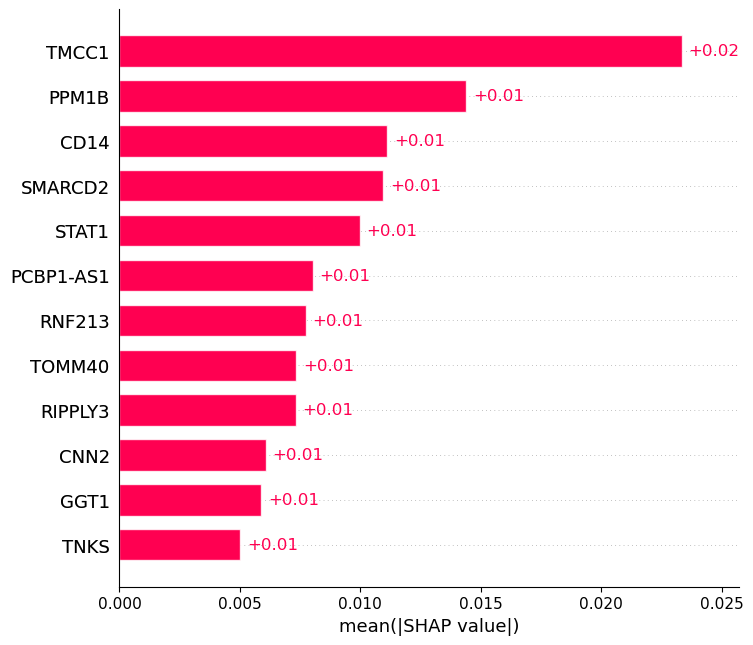

In [581]:
shap.plots.bar(shap_values, max_display=15)

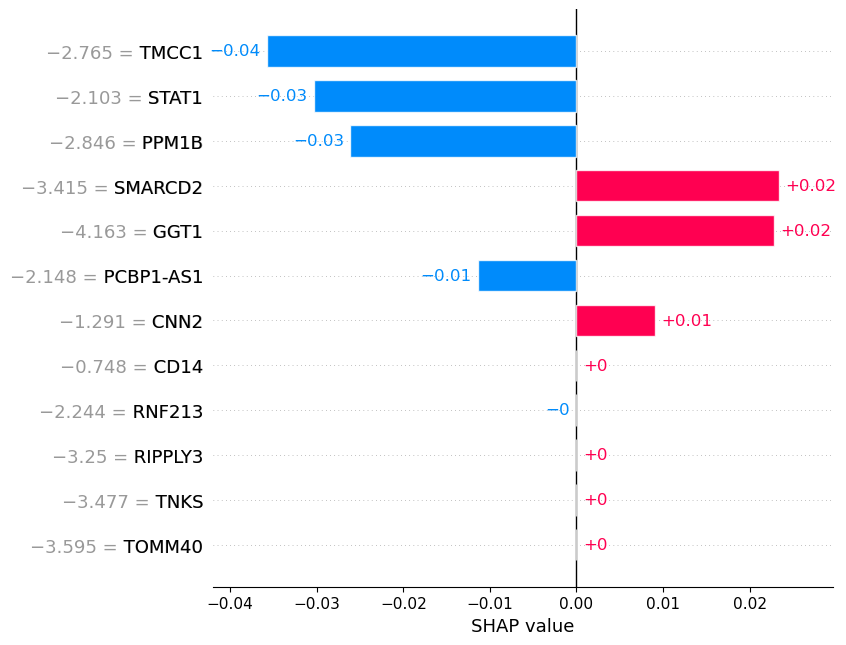

In [604]:
shap.plots.bar(shap_values[error[-1]], max_display=15)

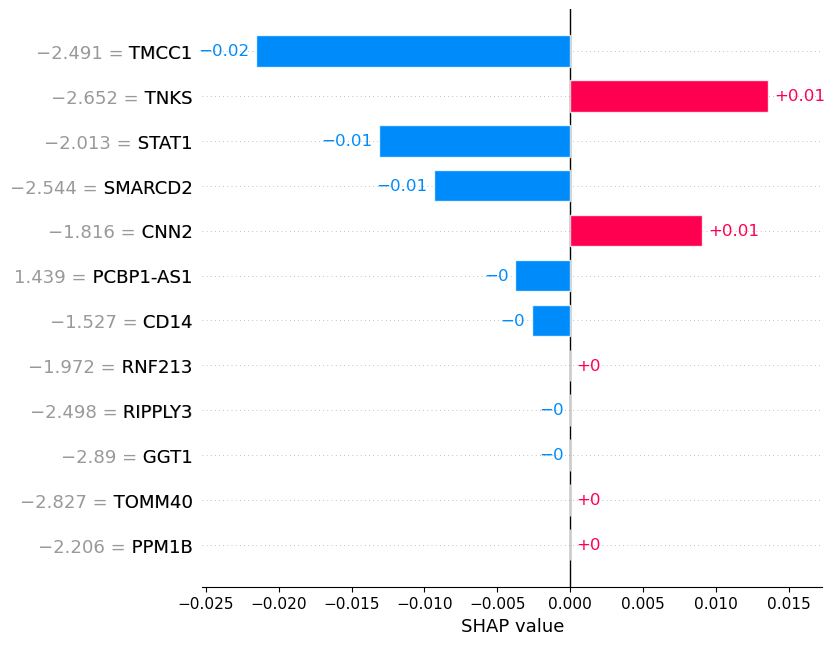

In [606]:
shap.plots.bar(shap_values[error[-4]], max_display=15)

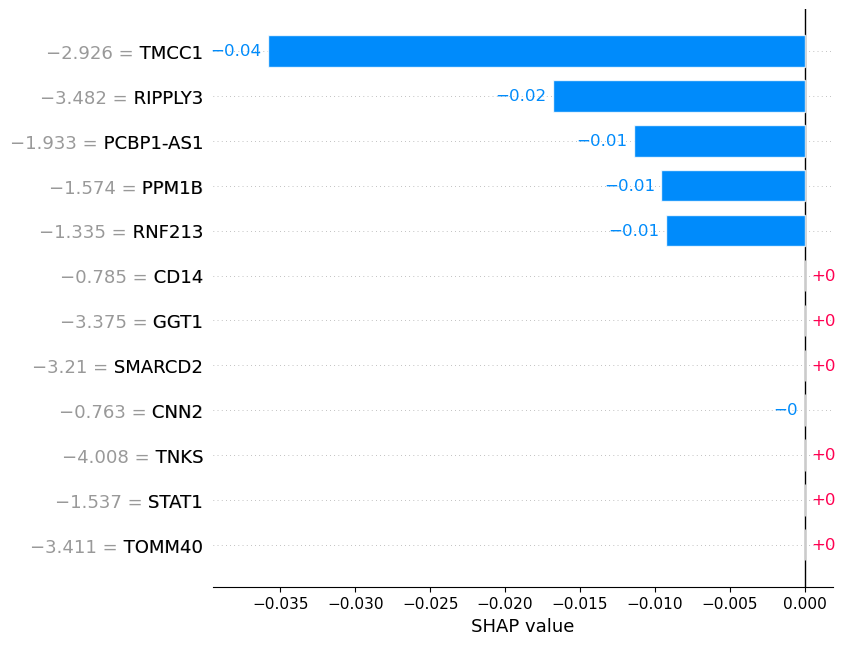

In [614]:
shap.plots.bar(shap_values[1], max_display=15)

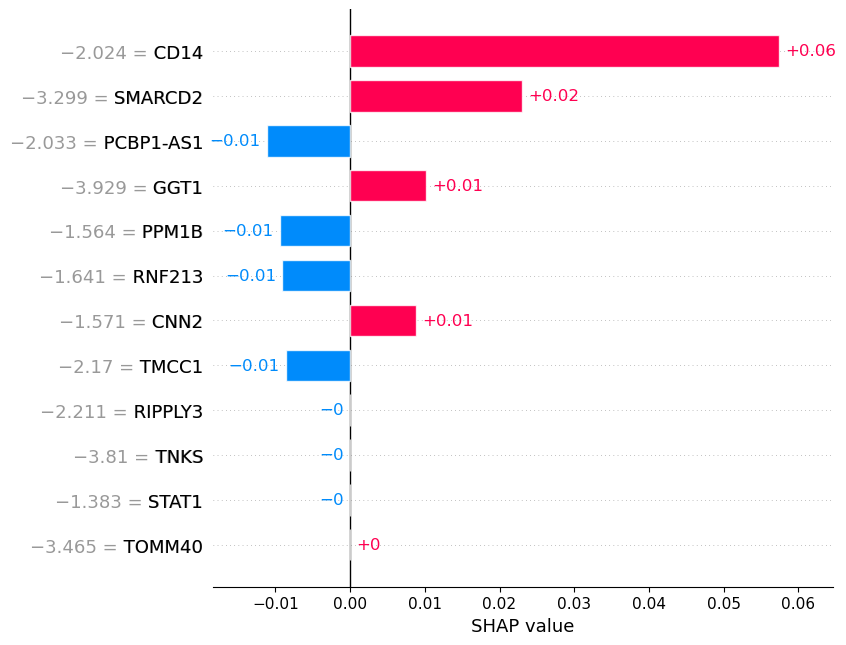

In [615]:
shap.plots.bar(shap_values[0], max_display=15)

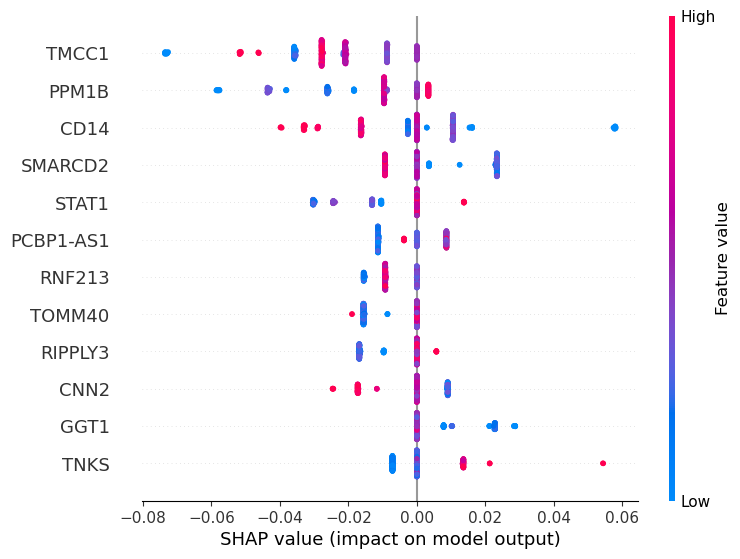

In [583]:
shap.plots.beeswarm(shap_values, max_display=15)

In [474]:
shap_values.values.shape

(378, 14)

In [359]:
gn

array([1259, 1775, 2697, 2757, 2818, 2977, 4916, 4940, 5297, 6963, 7378,
       7850])

In [363]:
adata_ml[:,gn].to_df()

Gene_name         CD14       CTSD     G3BP1       GBP5        GK        GRN  \
SRR14675534   5.821682  12.459092  3.305956   6.775332  0.272418  12.895823   
SRR14675535  13.046552  20.976843  1.932009   3.136434  0.269954  61.210152   
SRR14675536  12.224912  17.883097  2.269477  13.134927  2.056871  76.283630   
SRR14675537  10.331694  20.044304  1.060473  19.575792  0.978944  56.142904   
SRR14675538  21.022414  16.424371  4.685173   1.862152  1.308786  42.437585   
...                ...        ...       ...        ...       ...        ...   
SRR14675913  10.124442  26.662844  7.170145   1.296177  1.493098  43.196926   
SRR14675914  12.385216  11.961584  3.598947   1.187182  0.199074  11.563105   
SRR14675915  19.185812  22.805225  5.570582   9.948323  3.399389  37.010041   
SRR14675916  26.856780  12.869667  5.148068   2.615732  1.529448  16.426732   
SRR14675917  12.245818  25.592530  2.446764   1.380292  0.177900  19.230222   

Gene_name        PARP9  PCBP1-AS1     PPM1B      STAT1       TFAM    TOMM40  
SRR14675534   5.653087   5.772013  9.265762  11.114112   5.112237  1.207387  
SRR14675535   5.538127   4.086697  5.893198   6.119692   1.833673  0.681032  
SRR14675536   9.863295   9.598259  7.405459  14.117889   3.814989  0.681352  
SRR14675537  11.169385   7.383223  6.068474  18.225164   0.168769  0.517264  
SRR14675538   4.126795   3.867868  3.260036   3.349424   0.000000  0.287210  
...                ...        ...       ...        ...        ...       ...  
SRR14675913   3.992068   8.588048  7.878025   8.064018   6.846704  0.767565  
SRR14675914   1.178156   4.731223  3.380542   4.718448   5.047007  1.162703  
SRR14675915  11.287880  15.134240  6.129366  21.138353  15.707252  2.532774  
SRR14675916   1.607411   8.845695  7.932355   8.560677   8.467138  1.096037  
SRR14675917   3.631174   4.525973  1.992488   7.332209   3.188694  0.438456  

[378 rows x 12 columns]

In [330]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X[:,gn], y)

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

In [311]:
np.median(X)

-3.6714178534834754

In [ ]:
'classification__n_estimators': [10,20,25,30,40,50,100,150,200], #
            'classification__criterion': ['entropy','gini'],
            'classification__min_samples_split' : list(range(2,9)),
            'classification__min_samples_leaf' : list(range(1,6)),

In [78]:
n=6#26#
res_ml_test = pd.DataFrame(res_ml_test)
res_ml_test.columns = ['Model', 'Norm'] + ['cv_ts'+str(i) for i in range(1,n)] 
res_ml_test['Mean_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].mean(axis=1)
res_ml_test['Median_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].median(axis=1)
# res_ml_test['Std_ts'] = res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)
# res_ml_test['1/Std_ts'] = 1/res_ml_test[['cv_ts'+str(i) for i in range(1,n)]].std(axis=1)

res_ml_train = pd.DataFrame(res_ml_train)
res_ml_train.columns = ['Model', 'Norm'] + ['cv_tr'+str(i) for i in range(1,n)]
res_ml_train['Mean_tr'] = res_ml_train[['cv_tr'+str(i) f
                                        or i in range(1,n)]].mean(axis=1)
res_ml_train['Median_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].median(axis=1)
# res_ml_train['Std_tr'] = res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)
# res_ml_train['1/Std_tr'] = 1/res_ml_train[['cv_tr'+str(i) for i in range(1,n)]].std(axis=1)

res_ml = res_ml_train.merge(res_ml_test, on=['Model', 'Norm'])
res_ml['delta_ts_tr'] = res_ml.Median_tr - res_ml.Median_ts
# res_ml.sort_values(['Median_ts','Median_tr'], ascending=False)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4037248880.py, line 11)

In [72]:
res_ml.to_csv('/mnt/d/housekeeping_genes/gridSearch_FIG6_Thesis_cvs_v1.csv')#.drop(['Model','Norm'], axis=1)[['cv_ts'+str(i) for i in range(1,n)]].T

In [587]:
res_rf_melt = []
res_rf_melt.append(res_ml.drop(['Model','Norm'], axis=1)[['cv_ts'+str(i) for i in range(1,n)]].T.reset_index(drop=True))
# res_rf_melt[-1]['variable'] = 'Test'

res_rf_melt.append(res_ml.drop(['Model','Norm'], axis=1)[['cv_tr'+str(i) for i in range(1,n)]].T.reset_index(drop=True))

res_rf_melt = pd.concat(res_rf_melt, axis=1)
res_rf_melt.columns = ['Test','Train']
# res_rf_melt[-1]['variable'] = 'Train'

# res_ml_melt = pd.concat(res_ml_melt)

In [40]:
# print(to_drop[:-50])

In [34]:
corr_df.loc[corr_df['30']>=.7,:]#.sort_values()

0         1         2         3         4         5         6  \
28     0.217770  0.070964  0.093670  0.391800  0.126438  0.079666  0.505954   
30     0.371918  0.081706  0.175450  0.512789  0.170355  0.225665  0.528492   
37     0.382275  0.038289  0.136249  0.378911  0.241573  0.131437  0.507299   
220    0.200988  0.116170  0.042262  0.421175  0.041249  0.055012  0.564279   
307    0.203921  0.022139  0.154547  0.454478  0.119485  0.176850  0.592161   
...         ...       ...       ...       ...       ...       ...       ...   
10455  0.213522  0.059177  0.077127  0.389546  0.038076  0.088885  0.547164   
10466  0.159479  0.166160  0.033224  0.332986  0.025196  0.027827  0.520090   
10497  0.226326  0.049603  0.100826  0.454151  0.105396  0.149368  0.562801   
10611  0.224928  0.003198  0.155852  0.420027  0.141503  0.194420  0.532306   
10622  0.249880  0.081468  0.074197  0.417979  0.079764  0.095899  0.557739   

              7         8         9  ...     10636     10637     10638  \
28     0.188226  0.119956  0.108377  ...  0.606492  0.067040  0.027636   
30     0.156132  0.145049  0.227550  ...  0.628498  0.001638  0.040038   
37     0.157790  0.155531  0.069990  ...  0.604279  0.078118  0.007768   
220    0.091313  0.045925  0.072622  ...  0.647524  0.152039  0.046214   
307    0.153930  0.060018  0.109240  ...  0.628246  0.069888  0.084408   
...         ...       ...       ...  ...       ...       ...       ...   
10455  0.075814  0.056658  0.100680  ...  0.599668  0.138531  0.020865   
10466  0.024596  0.055085  0.011119  ...  0.565933  0.222808  0.092200   
10497  0.154638  0.093279  0.087535  ...  0.647279  0.104440  0.011789   
10611  0.187121  0.157639  0.183392  ...  0.602667  0.029060  0.067821   
10622  0.104861  0.054178  0.060388  ...  0.669880  0.125349  0.015257   

          10639     10640     10641     10642     10643     10644     10645  
28     0.379902  0.101223  0.299308  0.097459  0.225688  0.029249  0.240141  
30     0.404807  0.115607  0.416644  0.290026  0.265283  0.156267  0.314709  
37     0.372827  0.084622  0.330848  0.165948  0.249060  0.040806  0.267312  
220    0.357369  0.016319  0.255767  0.054545  0.186571  0.033026  0.185833  
307    0.332948  0.090228  0.338091  0.159512  0.225671  0.061868  0.291241  
...         ...       ...       ...       ...       ...       ...       ...  
10455  0.389931  0.016436  0.281279  0.059237  0.137146  0.003774  0.252962  
10466  0.320415  0.084807  0.213843  0.034796  0.066763  0.112994  0.162531  
10497  0.415745  0.081909  0.303042  0.140271  0.269727  0.049611  0.244248  
10611  0.384509  0.079747  0.307830  0.175883  0.245812  0.051292  0.262374  
10622  0.409771  0.043485  0.275480  0.079266  0.218475  0.005366  0.238085  

[68 rows x 10646 columns]

In [45]:
corr_df['30'].sort_values().tail(50)

10371    0.731871
3414     0.734013
2528     0.735093
9474     0.735495
5832     0.735998
9091     0.736629
28       0.736871
5872     0.737046
6274     0.737081
37       0.738824
789      0.742600
10497    0.743358
3828     0.744341
5964     0.744758
2100     0.749316
6033     0.750128
4010     0.752857
10255    0.757257
6651     0.757973
5973     0.758744
5253     0.758811
6269     0.759168
307      0.764642
1781     0.766474
3476     0.767059
4244     0.767168
8932     0.767319
9773     0.767610
5944     0.768351
10611    0.768703
6755     0.770313
9568     0.778277
10455    0.779551
7271     0.784381
6181     0.786933
4001     0.790061
2989     0.794573
6968     0.794680
10361    0.796159
10466    0.801198
10400    0.806872
10055    0.808223
2117     0.810641
6569     0.812165
5559     0.815450
7584     0.823764
10622    0.824771
3040     0.824951
220      0.837107
30       1.000000
Name: 30, dtype: float64

In [51]:
corr_df.drop(corr_df[to_drop], axis=1).loc[30,:].sort_values()

4407    0.000053
3317    0.000075
1181    0.000161
8097    0.000190
1291    0.000272
          ...   
5955    0.648035
1321    0.650420
5285    0.679662
3352    0.682740
28      0.736871
Name: 30, Length: 6187, dtype: float64

In [52]:
'28' in to_drop

False

In [ ]:
corr_melt = corr_df.melt(ignore_index=False)
# corr_melt

In [10]:
corr_melt = corr_melt.dropna().reset_index()

In [6]:

corr_melt.columns = ['V1', 'V2', 'corr_d']
corr_melt[['V1', 'V2']] = corr_melt[['V1', 'V2']].astype(int)
corr_melt

V1     V2  corr_d
0          0      0     0.0
1          1      1     0.0
2          2      2     0.0
3          3      3     0.0
4          4      4     0.0
...      ...    ...     ...
13976  13976  13976     0.0
13977  13977  13977     0.0
13978  13978  13978     0.0
13979  13979  13979     0.0
13980  13980  13980     0.0

[13981 rows x 3 columns]

In [5]:
corr_df

0    1    2    3    4   5   6   7   8   9  ...  13971  13972  13973  \
0      0.0  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
1      NaN  0.0  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
2      NaN  NaN  0.0  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
3      NaN  NaN  NaN  0.0  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
4      NaN  NaN  NaN  NaN  0.0 NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
...    ...  ...  ...  ...  ...  ..  ..  ..  ..  ..  ...    ...    ...    ...   
13976  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
13977  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
13978  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
13979  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   
13980  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN  ...    NaN    NaN    NaN   

       13974  13975  13976  13977  13978  13979  13980  
0        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...      ...    ...    ...    ...    ...    ...    ...  
13976    NaN    NaN    0.0    NaN    NaN    NaN    NaN  
13977    NaN    NaN    NaN    0.0    NaN    NaN    NaN  
13978    NaN    NaN    NaN    NaN    0.0    NaN    NaN  
13979    NaN    NaN    NaN    NaN    NaN    0.0    NaN  
13980    NaN    NaN    NaN    NaN    NaN    NaN    0.0  

[13981 rows x 13981 columns]

In [4]:
corr_melt

variable  value
0            0    0.0
1            0    NaN
2            0    NaN
3            0    NaN
4            0    NaN
...        ...    ...
13976    13980    NaN
13977    13980    NaN
13978    13980    NaN
13979    13980    NaN
13980    13980    0.0

[195468361 rows x 2 columns]

In [54]:
# Since max correlation distance is 2, I replace inf by 2
# coarr[np.isinf(corr)] = 10

In [58]:
# corr[np.isnan(corr)] = 10

In [190]:
t1 = time.time()
Z = sch.average(corr)
t2 = time.time()
print((t2-t1)/60, 'min')

0.13900508483250937 min


### Calculate silhouette_score calinski_harabasz_score davies_bouldin_score to evaluate t for flat clustering

In [192]:
adata_ml.X.T.shape[1], adata_ml.X.T.shape[1]/2

(378, 189.0)

In [206]:
print(list(range(2,195, 6)))
print(list(range(2,300, 3)))

[2, 8, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 80, 86, 92, 98, 104, 110, 116, 122, 128, 134, 140, 146, 152, 158, 164, 170, 176, 182, 188, 194]
[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 236, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299]


In [209]:
s_score_mean = dict()
s_score_samples = dict()

dict_keys([2, 8, 14, 20, 26, 32, 38, 44, 50, 56, 62, 68, 74, 80, 86, 92, 98, 104, 110, 116, 122, 128, 134, 140, 146, 152, 158, 164, 170, 176, 182, 188, 194])

In [210]:
for t in range(2,320, 3):
    if t not in s_score_mean.keys():
        nodes = sch.fcluster(Z, t=t, criterion="maxclust")
        # print(t, np.unique(nodes))
        s_score_mean[t] = [silhouette_score(adata_ml.X.T, nodes, metric='correlation'),
                           calinski_harabasz_score(adata_ml.X.T , nodes),
                           davies_bouldin_score(adata_ml.X.T , nodes)]
        
        # s_score_samples[t] = silhouette_samples(adata_ml.X.T , nodes, metric='correlation')
        print(t,end=' | ')

df_scores = pd.DataFrame(s_score_mean, index=['silhouette_score','calinski_harabasz_score','davies_bouldin_score']).T
df_scores

5 | 11 | 17 | 23 | 29 | 35 | 41 | 47 | 53 | 59 | 65 | 71 | 77 | 83 | 89 | 95 | 101 | 107 | 113 | 119 | 125 | 131 | 137 | 143 | 149 | 155 | 161 | 167 | 173 | 179 | 185 | 191 | 197 | 200 | 203 | 206 | 209 | 212 | 215 | 218 | 221 | 224 | 227 | 230 | 233 | 236 | 239 | 242 | 245 | 248 | 251 | 254 | 257 | 260 | 263 | 266 | 269 | 272 | 275 | 278 | 281 | 284 | 287 | 290 | 293 | 296 | 299 | 302 | 305 | 308 | 311 | 314 | 317 | 

silhouette_score  calinski_harabasz_score  davies_bouldin_score
2            0.224865                 0.000325              2.735671
8            0.151528                 9.703457              2.369645
14           0.135515                 5.222707              2.376162
20           0.118877                 3.571903              2.422306
26           0.110664                 2.713486              2.347097
..                ...                      ...                   ...
305          0.062330                 0.262477              2.724831
308          0.062134                 0.259855              2.719207
311          0.062200                 0.257284              2.721186
314          0.061633                 0.254762              2.710902
317          0.062691                 0.252289              2.707827

[106 rows x 3 columns]

In [211]:
df_scores.to_csv('df_scores_ml.csv', index=0)

In [17]:
# corr

In [20]:
# corr_df = pd.DataFrame(squareform(corr))
# corr_df.to_csv('corr_dist.csv')

In [6]:
corr_df = pd.read_csv('corr_dist.csv', index_col=0)

In [5]:
# corr_df = corr_df.drop('Unnamed: 0', axis=1)

In [27]:
corr_df

0        0
1        0
2        0
3        0
4        0
        ..
10641    0
10642    0
10643    0
10644    0
10645    0
Length: 10646, dtype: int64

In [10]:
corr_df_nan = pd.DataFrame(np.where(corr_df<.7, np.nan, corr_df))

In [12]:
corr_melt = corr_df_nan.melt(ignore_index=False)
# corr_melt['value'] = (1-corr_melt['value']).abs()
corr_melt

variable     value
0             0       NaN
1             0  0.746368
2             0  0.721084
3             0  0.742567
4             0       NaN
...         ...       ...
10641     10645       NaN
10642     10645       NaN
10643     10645  0.746262
10644     10645       NaN
10645     10645       NaN

[113337316 rows x 2 columns]

In [14]:
corr_melt = corr_melt.dropna().reset_index()
corr_melt.columns = ['V1', 'V2', 'corr_d']
corr_melt[['V1', 'V2']] = corr_melt[['V1', 'V2']].astype(int)
corr_melt

V1     V2    corr_d
0             1      0  0.746368
1             2      0  0.721084
2             3      0  0.742567
3             6      0  0.766557
4             7      0  0.748361
...         ...    ...       ...
56628153  10633  10645  0.717719
56628154  10634  10645  0.758585
56628155  10637  10645  0.750947
56628156  10638  10645  0.761486
56628157  10643  10645  0.746262

[56628158 rows x 3 columns]

In [15]:
corr_melt.sort_values('corr_d')

V1    V2    corr_d
35893238  6481  6655  0.700000
34917865  6655  6481  0.700000
22892336  7856  4250  0.700000
41880925  4250  7856  0.700000
20811505  8601  3865  0.700000
...        ...   ...       ...
24471245  3652  4551  1.521135
19994251  7536  3705  1.546221
40374827  3705  7536  1.546221
5956353   3705  1120  1.553553
19987965  1120  3705  1.553553

[56628158 rows x 3 columns]

In [ ]:
corr_melt_006 = corr_melt[corr_melt.value>=0.6]#.reset_index()#.to_csv('.corr_leq0.01.csv')
corr_melt_006 = corr_melt.reset_index()
corr_melt_006.columns = ['V1','V2','corr_dist']
corr_melt_006[['V1','V2']] = corr_melt_006[['V1','V2']].astype(int)

In [ ]:
corr_melt_006

In [47]:
corr_melt_001['set'] = corr_melt_001.apply(lambda x: set([x['V1'],x['V2']]), axis=1)#.sort_values('corr_dist')

In [ ]:
corr_melt_001.sort_values('corr_dist').drop_duplicates(subset='set')

In [ ]:
louvain = Louvain()
labels = louvain.fit_predict(corr)

In [2]:
labels

NameError: name 'labels' is not defined

In [ ]:
fig = plt.figure(figsize=(15,5))
ax_bar = fig.add_subplot(111)
# ax_dn = fig.add_subplot(122)a
sns.barplot(x='index',y='value',hue='variable',data=df_scores.iloc[:,:3].melt(ignore_index=False).reset_index(), ax=ax_bar)
ax_bar.set_title('clusters_metrics')

# dn = sch.dendrogram(Z, orientation='right', no_labels=False, labels=adata_ml.var.index.tolist(),color_threshold=.4, above_threshold_color='black',  ax=ax_dn)
# ax_dn.set_title('dendrogram t=.4 (4 clusters)')
fig.tight_layout()
# fig.savefig(fname='./draft/FIGS3_scores.pdf', bbox_inches='tight', format='pdf', dpi=300)

In [3]:
corr

NameError: name 'corr' is not defined

In [14]:
1-pdist([[1,4,5], [-2,-8,-10], [-2,-8,-10]], metric='correlation')

array([-1., -1.,  1.])